In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import lovelyplots
import matplotlib.pyplot as plt
plt.rcParams['axes.formatter.useoffset'] = False
plt.style.use(['ipynb'])

cgtp_dense_color = plt.cm.get_cmap('Reds')(0.8)
cgtp_sparse_color = plt.cm.get_cmap('Reds')(0.4)
matrixtp_color = plt.cm.get_cmap('Reds')(0.1) 

# Updated blue variants
gtp_naive_color = plt.cm.get_cmap('Blues')(0.8)   # Navy Blue
gtp_original_color = plt.cm.get_cmap('Blues')(0.4) # Sky Blue
vgtp_naive_color = plt.cm.get_cmap('Blues')(1.0)   # Pastel Blue

import numpy as np

/tmp/ipykernel_2506649/2287846885.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cgtp_dense_color = plt.cm.get_cmap('Reds')(0.8)
/tmp/ipykernel_2506649/2287846885.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cgtp_sparse_color = plt.cm.get_cmap('Reds')(0.4)
/tmp/ipykernel_2506649/2287846885.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  matrixtp_color = plt.cm.get_cmap('Reds')(0.1)
/tmp/ipykernel_2506649/2287846885.py:12: MatplotlibDeprecationWar

In [4]:
df_nsight = pd.read_csv("../benchmarking/csv/nsight_profiling.csv").sort_values('lmax')
df_jax = pd.read_csv("../benchmarking/csv/walltime_gpu_jax.csv").sort_values('lmax')
df_cpu = pd.read_csv("../benchmarking/csv/walltime_cpu_jax.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../benchmarking/csv/walltime_tetris_jax.csv'

In [11]:
import e3nn_jax as e3nn
from freedom.tensor_products.vector_spherical_harmonics import VSHCoeffs
from matplotlib.ticker import FuncFormatter


def format_fn(tick_val, tick_pos):
    return int(tick_val) if tick_val.is_integer() else tick_val
        
def query_nsight(df, irreps_type, tensor_product_type, batch, property):
    result = df[(df['irreps_type'] == irreps_type) \
        & (df['tensor_product_type'] == tensor_product_type) \
        & (df['batch'] == batch)][property]
    
    # Replace 0 or 0.0 with None
    result = result.apply(lambda x: None if (x == 0 or x == 0.0) else x)
    return result

def query_tetris(df, tensor_product_type, multipliticity, batch, property):
    return df[(df['tensor_product_type'] == tensor_product_type) \
        & (df['multipliticity'] == multipliticity) \
        & (df['batch'] == batch)][property]

def plot_tetris_walltime_by_lmax(df, multipliticity, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_tetris(df, "clebsch-gordan-dense", multipliticity, batch, "lmax"), query_tetris(df, "clebsch-gordan-dense", multipliticity, batch, "Time")*1000, label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_tetris(df, "clebsch-gordan-sparse", multipliticity, batch, "lmax"), query_tetris(df, "clebsch-gordan-sparse", multipliticity, batch, "Time")*1000, label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color) 
    #TODO: Add Matrix TP here

    ax.semilogy(query_tetris(df, "gaunt-s2grid", multipliticity, batch, "lmax"), query_tetris(df, "gaunt-s2grid", multipliticity, batch, "Time")*1000, label="Gaunt (Naive Grid)", color=gtp_naive_color) 
    ax.semilogy(query_tetris(df, "gaunt-2d-fourier", multipliticity, batch, "lmax"), query_tetris(df, "gaunt-2d-fourier", multipliticity, batch, "Time")*1000, label="Gaunt (Fourier Grid)", color=gtp_original_color) 
    ax.semilogy(query_tetris(df, "vector-gaunt-s2grid", multipliticity, batch, "lmax"), query_tetris(df, "vector-gaunt-s2grid", multipliticity, batch, "Time")*1000, label="Vector Gaunt (Naive Grid)", color=vgtp_naive_color) 
    ax.set_ylabel("Walltime per iteration (ms)", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3)
    ax.set_xticks(range(1, 7))
    
    ax.set_title(f"Tetris iteration time (GPU) multipliticity={multipliticity} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/tetris_walltime_by_lmax_{multipliticity}_{batch}.pdf")
    fig.show()


def plot_tetris_walltime_by_params(df, multipliticity, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_tetris(df, "clebsch-gordan-dense", multipliticity, batch, "parameters"), query_tetris(df, "clebsch-gordan-dense", multipliticity, batch, "Time")*1000, label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_tetris(df, "clebsch-gordan-sparse", multipliticity, batch, "parameters"), query_tetris(df, "clebsch-gordan-sparse", multipliticity, batch, "Time")*1000, label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color) 
    #TODO: Add Matrix TP here

    ax.loglog(query_tetris(df, "gaunt-s2grid", multipliticity, batch, "parameters"), query_tetris(df, "gaunt-s2grid", multipliticity, batch, "Time")*1000, label="Gaunt (Naive Grid)", color=gtp_naive_color) 
    ax.loglog(query_tetris(df, "gaunt-2d-fourier", multipliticity, batch, "parameters"), query_tetris(df, "gaunt-2d-fourier", multipliticity, batch, "Time")*1000, label="Gaunt (Fourier Grid)", color=gtp_original_color) 
    ax.loglog(query_tetris(df, "vector-gaunt-s2grid", multipliticity, batch, "parameters"), query_tetris(df, "vector-gaunt-s2grid", multipliticity, batch, "Time")*1000, label="Vector Gaunt (Naive Grid)", color=vgtp_naive_color) 
    ax.set_ylabel("Walltime per iteration (ms)", fontsize=10)
    ax.set_xlabel("Number of Parameters")
    # ax.set_ylim(10**-2, 10**3)
    # ax.set_xticks(range(1, 7))
    
    ax.set_title(f"Tetris iteration time (GPU) multipliticity={multipliticity} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/tetris_walltime_by_params_{multipliticity}_{batch}.pdf")
    fig.show()

def plot_walltimes_normalized_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "Time")*1000/query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "normalization"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","CGTP-sparse" , batch, "normalization"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","Matrix-TP" , batch, "normalization"), label="Matrix TP", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","GTP-grid" , batch, "normalization"), label="Gaunt (Naive Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","GTP-fourier" , batch, "normalization"), label="Gaunt (Fourier Grid)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","VGTP-grid" , batch, "normalization"), label="Vector Gaunt (Naive Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("Walltime (ms) / $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Normalized Walltime (GPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_normalized_gpu_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_walltimes_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "Time")*1000, label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")*1000, label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")*1000, label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")*1000, label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")*1000, label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "Time")*1000, label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("Walltime (ms)", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3) 
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Walltime (GPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_gpu_{irreps_type}_{batch}.pdf")
    fig.show()
    

def plot_walltimes_cpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "Time")*1000, label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")*1000, label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")*1000, label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")*1000, label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")*1000, label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "Time")*1000, label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("Walltime (ms)", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3) 
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Walltime (CPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_cpu_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_all_gflops_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "all GFLOPs"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GFLOPs", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])


    ax.set_title(f"Total GFLOPs for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')

    fig.savefig(f"../benchmarking/plots/total_all_gflops_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_all_gflops_normalized_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "normalization"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","CGTP-sparse" , batch, "normalization"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","Matrix-TP" , batch, "normalization"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","GTP-grid" , batch, "normalization"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","GTP-fourier" , batch, "normalization"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","VGTP-grid" , batch, "normalization"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GFLOPs/ $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])


    ax.set_title(f"Total Normalized GFLOPs for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')

    fig.savefig(f"../benchmarking/plots/total_normalized_all_gflops_{irreps_type}_{batch}.pdf")
    fig.show()
    
def plot_peak_gb_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "GB/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "GB/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "GB/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "GB/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "GB/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "GB/s"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GB/s")
    ax.set_xlabel("$L_{max}$")
    ax.text(4.3, 1500, "DRAM: 768 GB/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(768, linestyle='--', color='blue')
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Peak Bandwidth for {irreps_type} batch={batch}", fontsize=12)
    ax.set_ylim(10**-3, 10**3.5)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.savefig(f"../benchmarking/plots/peak_gbs_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_all_gb_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "GB"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "GB"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "GB"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "GB"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "GB"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "GB"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GB")
    ax.set_xlabel("$L_{max}$")
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_title(f"Total DRAM Read + Writes for {irreps_type} batch={batch}", fontsize=12)
    # ax.set_ylim(10**-4.5, 10**2)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.tight_layout()
    fig.savefig(f"../benchmarking/plots/total_gb_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_peak_all_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "all GFLOPs/s"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**2, 10**6)
    ax.axhline(153450, linestyle='--', color='teal')
    ax.text(4.68, 250000, "TF32 + FP32: 153.45 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.set_xticks(range(1, 11))
    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"Peak Throughput for {irreps_type} for batch={batch}", fontsize=12)
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.savefig(f"../benchmarking/plots/peak_all_gflops_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_peak_cc_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "CC GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "CC GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "CC GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "CC GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "CC GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "CC GFLOPs/s"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**2, 10**6)
    ax.text(4.68, 35500, "FP32: 17.05 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(17050, linestyle='--', color='teal')
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"FP32 Average Throughput for {irreps_type}", fontsize=12)
    ax.grid(linestyle='--')
    
    fig.savefig(f"../benchmarking/plots/peak_cc_gflops_{irreps_type}_{batch}.pdf")
    fig.show()
    
def plot_peak_tc_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()

    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "TC GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "TC GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "TC GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "TC GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "TC GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "VGTP-grid", batch, "TC GFLOPs/s"), label="Vector Gaunt (Grid)", marker="^", color=vgtp_naive_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**2, 10**6)
    ax.text(4.68, 315500, "TF32: 136.4 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(136400, linestyle='--', color='purple')
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_xticks(range(1, 11))
    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"Tensor Cores Average Throughput for {irreps_type}", fontsize=12)
    ax.grid(linestyle='--')
    
    fig.savefig(f"../benchmarking/plots/peak_tc_gflops_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_iclr_sweep(irreps_type, batch):
    plot_walltimes_gpu(df_nsight, irreps_type, batch)
    plot_walltimes_cpu(df_cpu, irreps_type, batch)
    plot_peak_tc_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_walltimes_normalized_gpu(df_nsight, irreps_type, batch)
    plot_all_gflops_gpu(df_nsight, irreps_type,  batch)
    plot_all_gflops_normalized_gpu(df_nsight, irreps_type,  batch)
    plot_peak_all_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_peak_tc_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_peak_cc_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_all_gb_gpu(df_nsight, irreps_type,  batch)
    plot_peak_gb_s_gpu(df_nsight, irreps_type, batch)


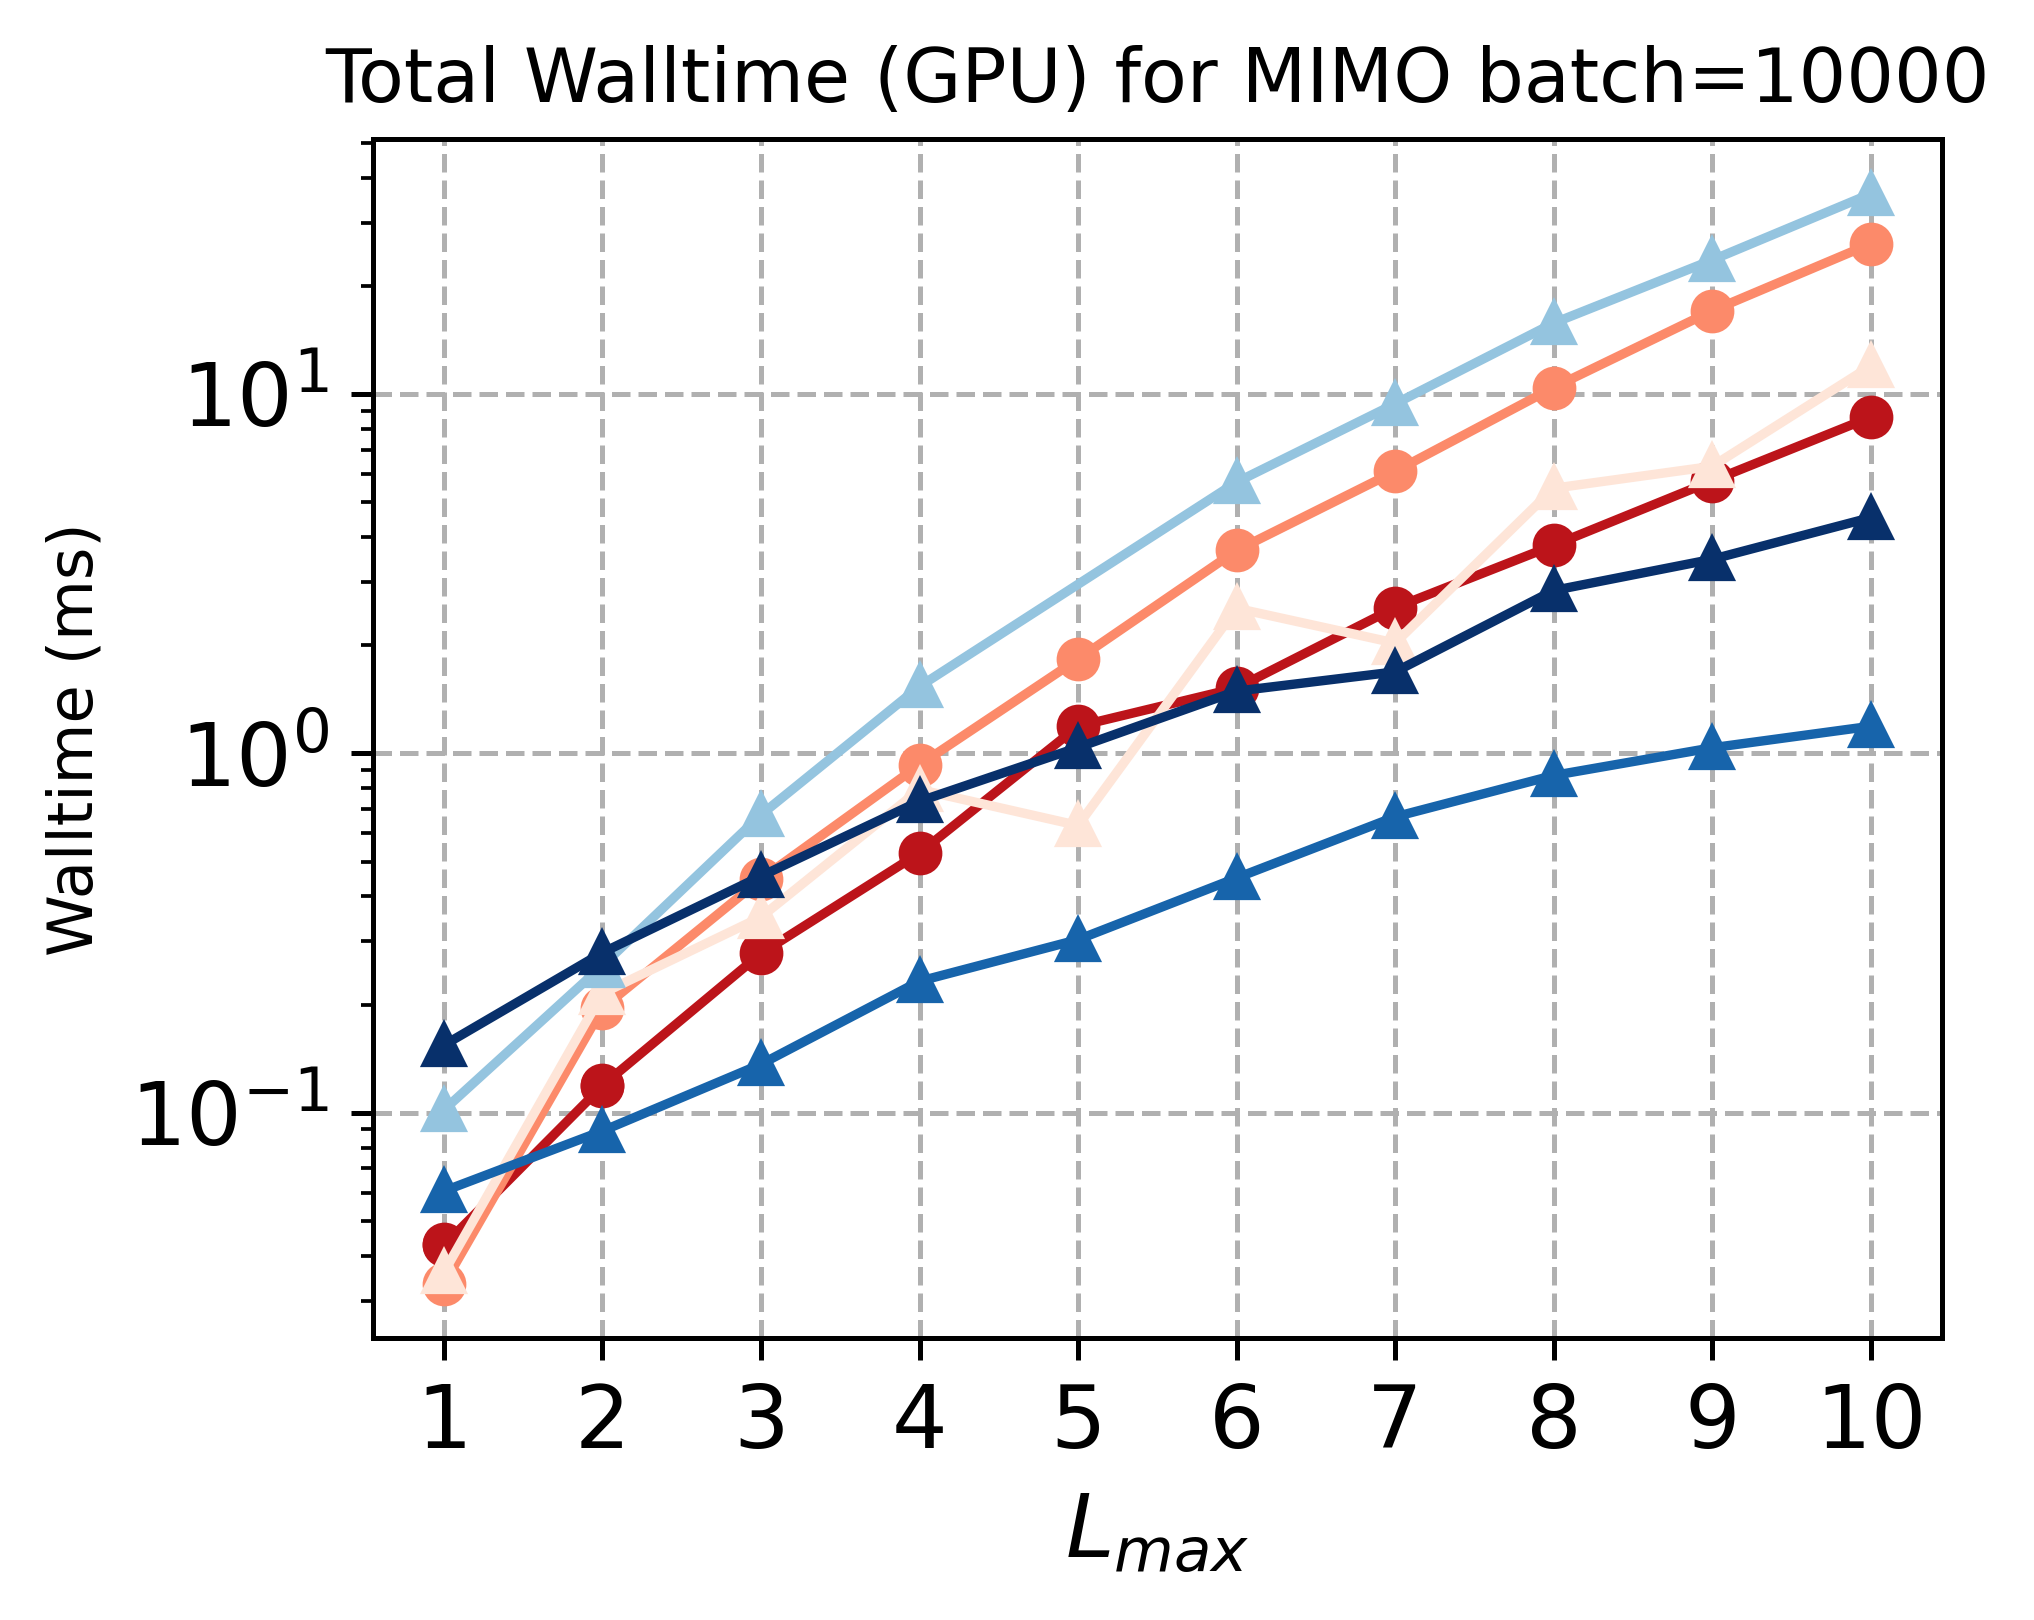

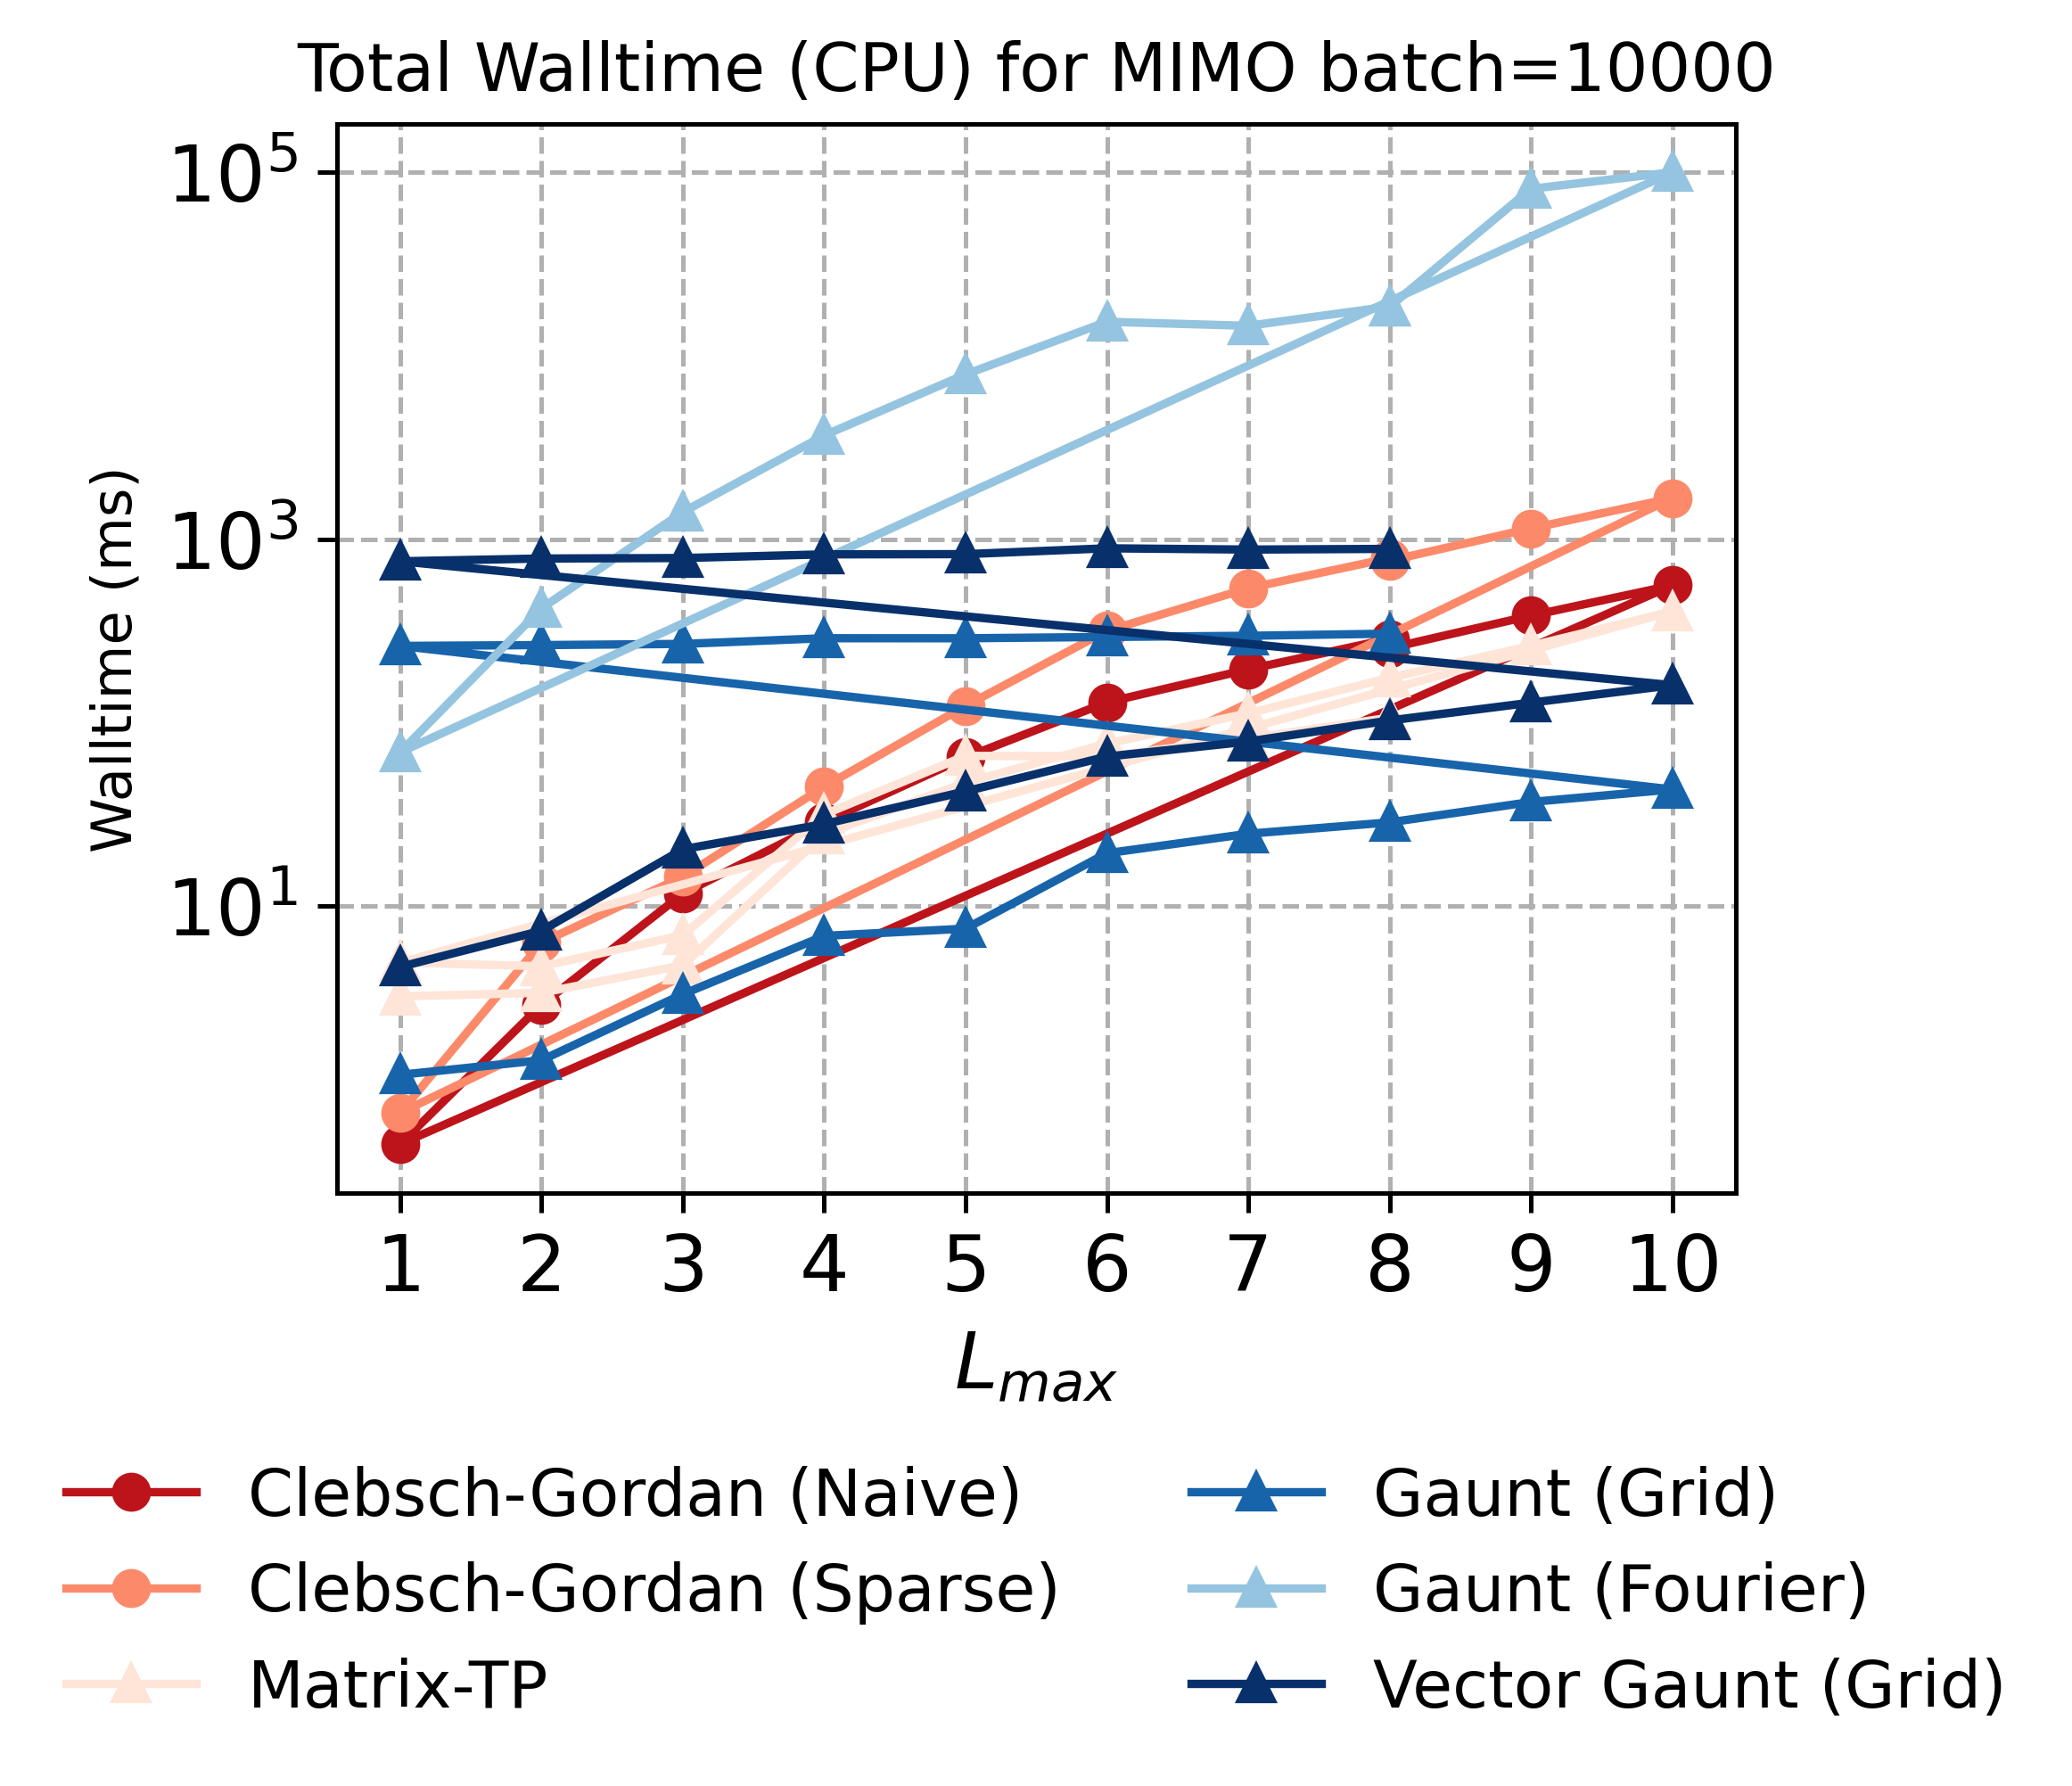

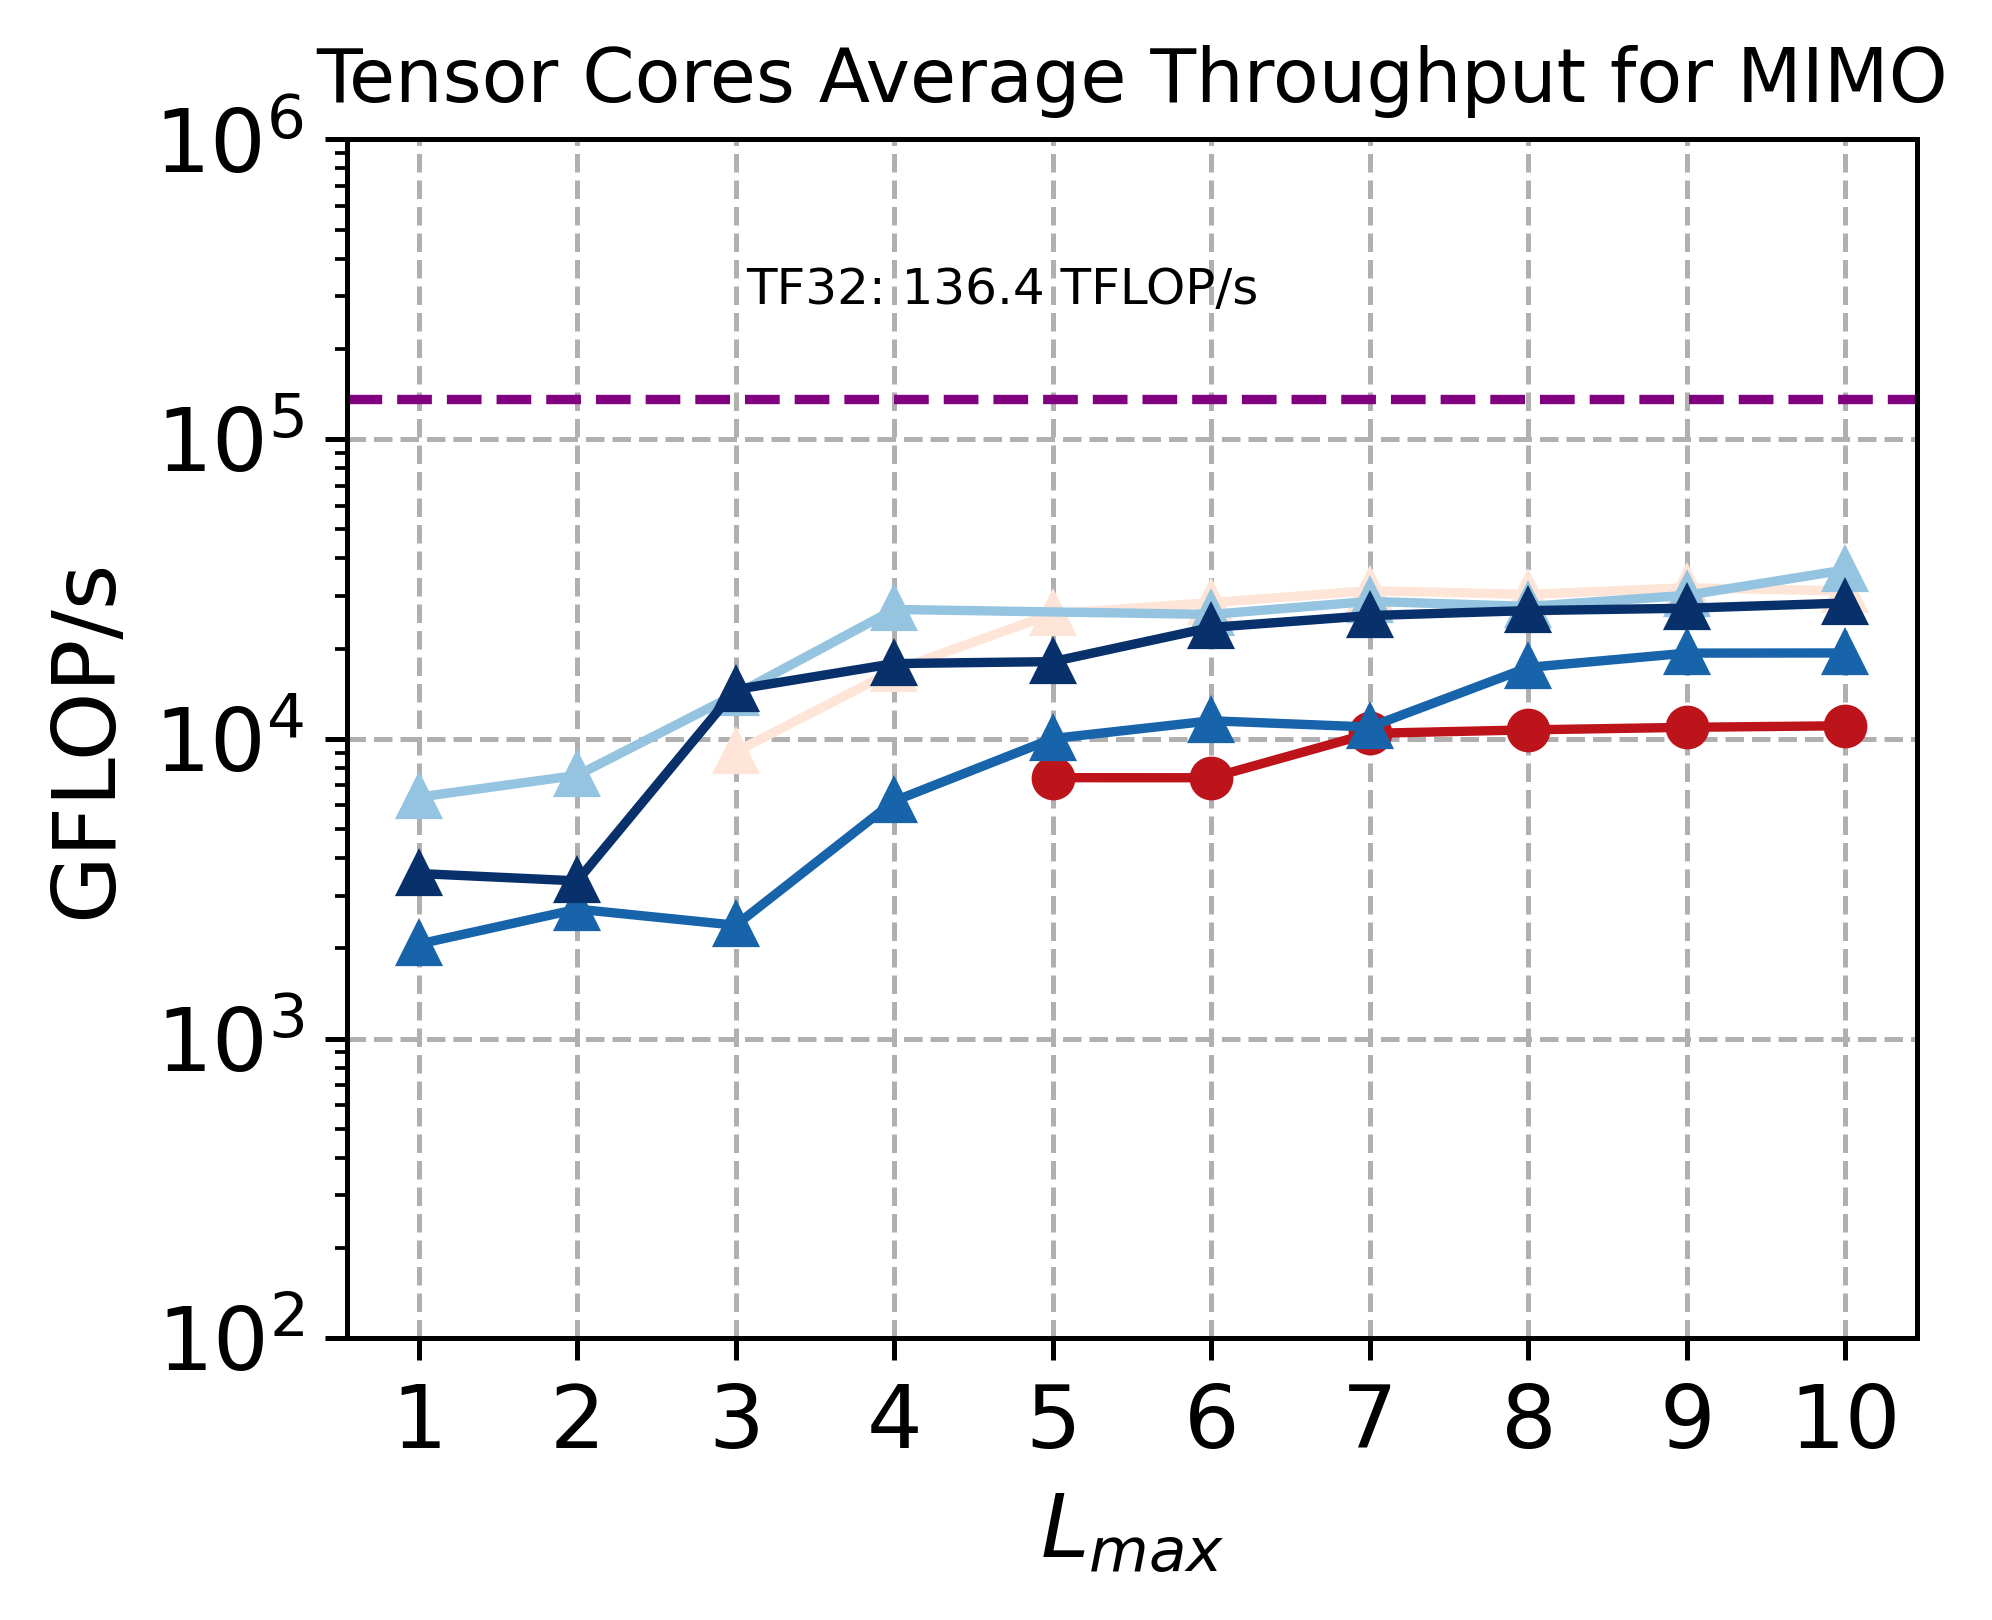

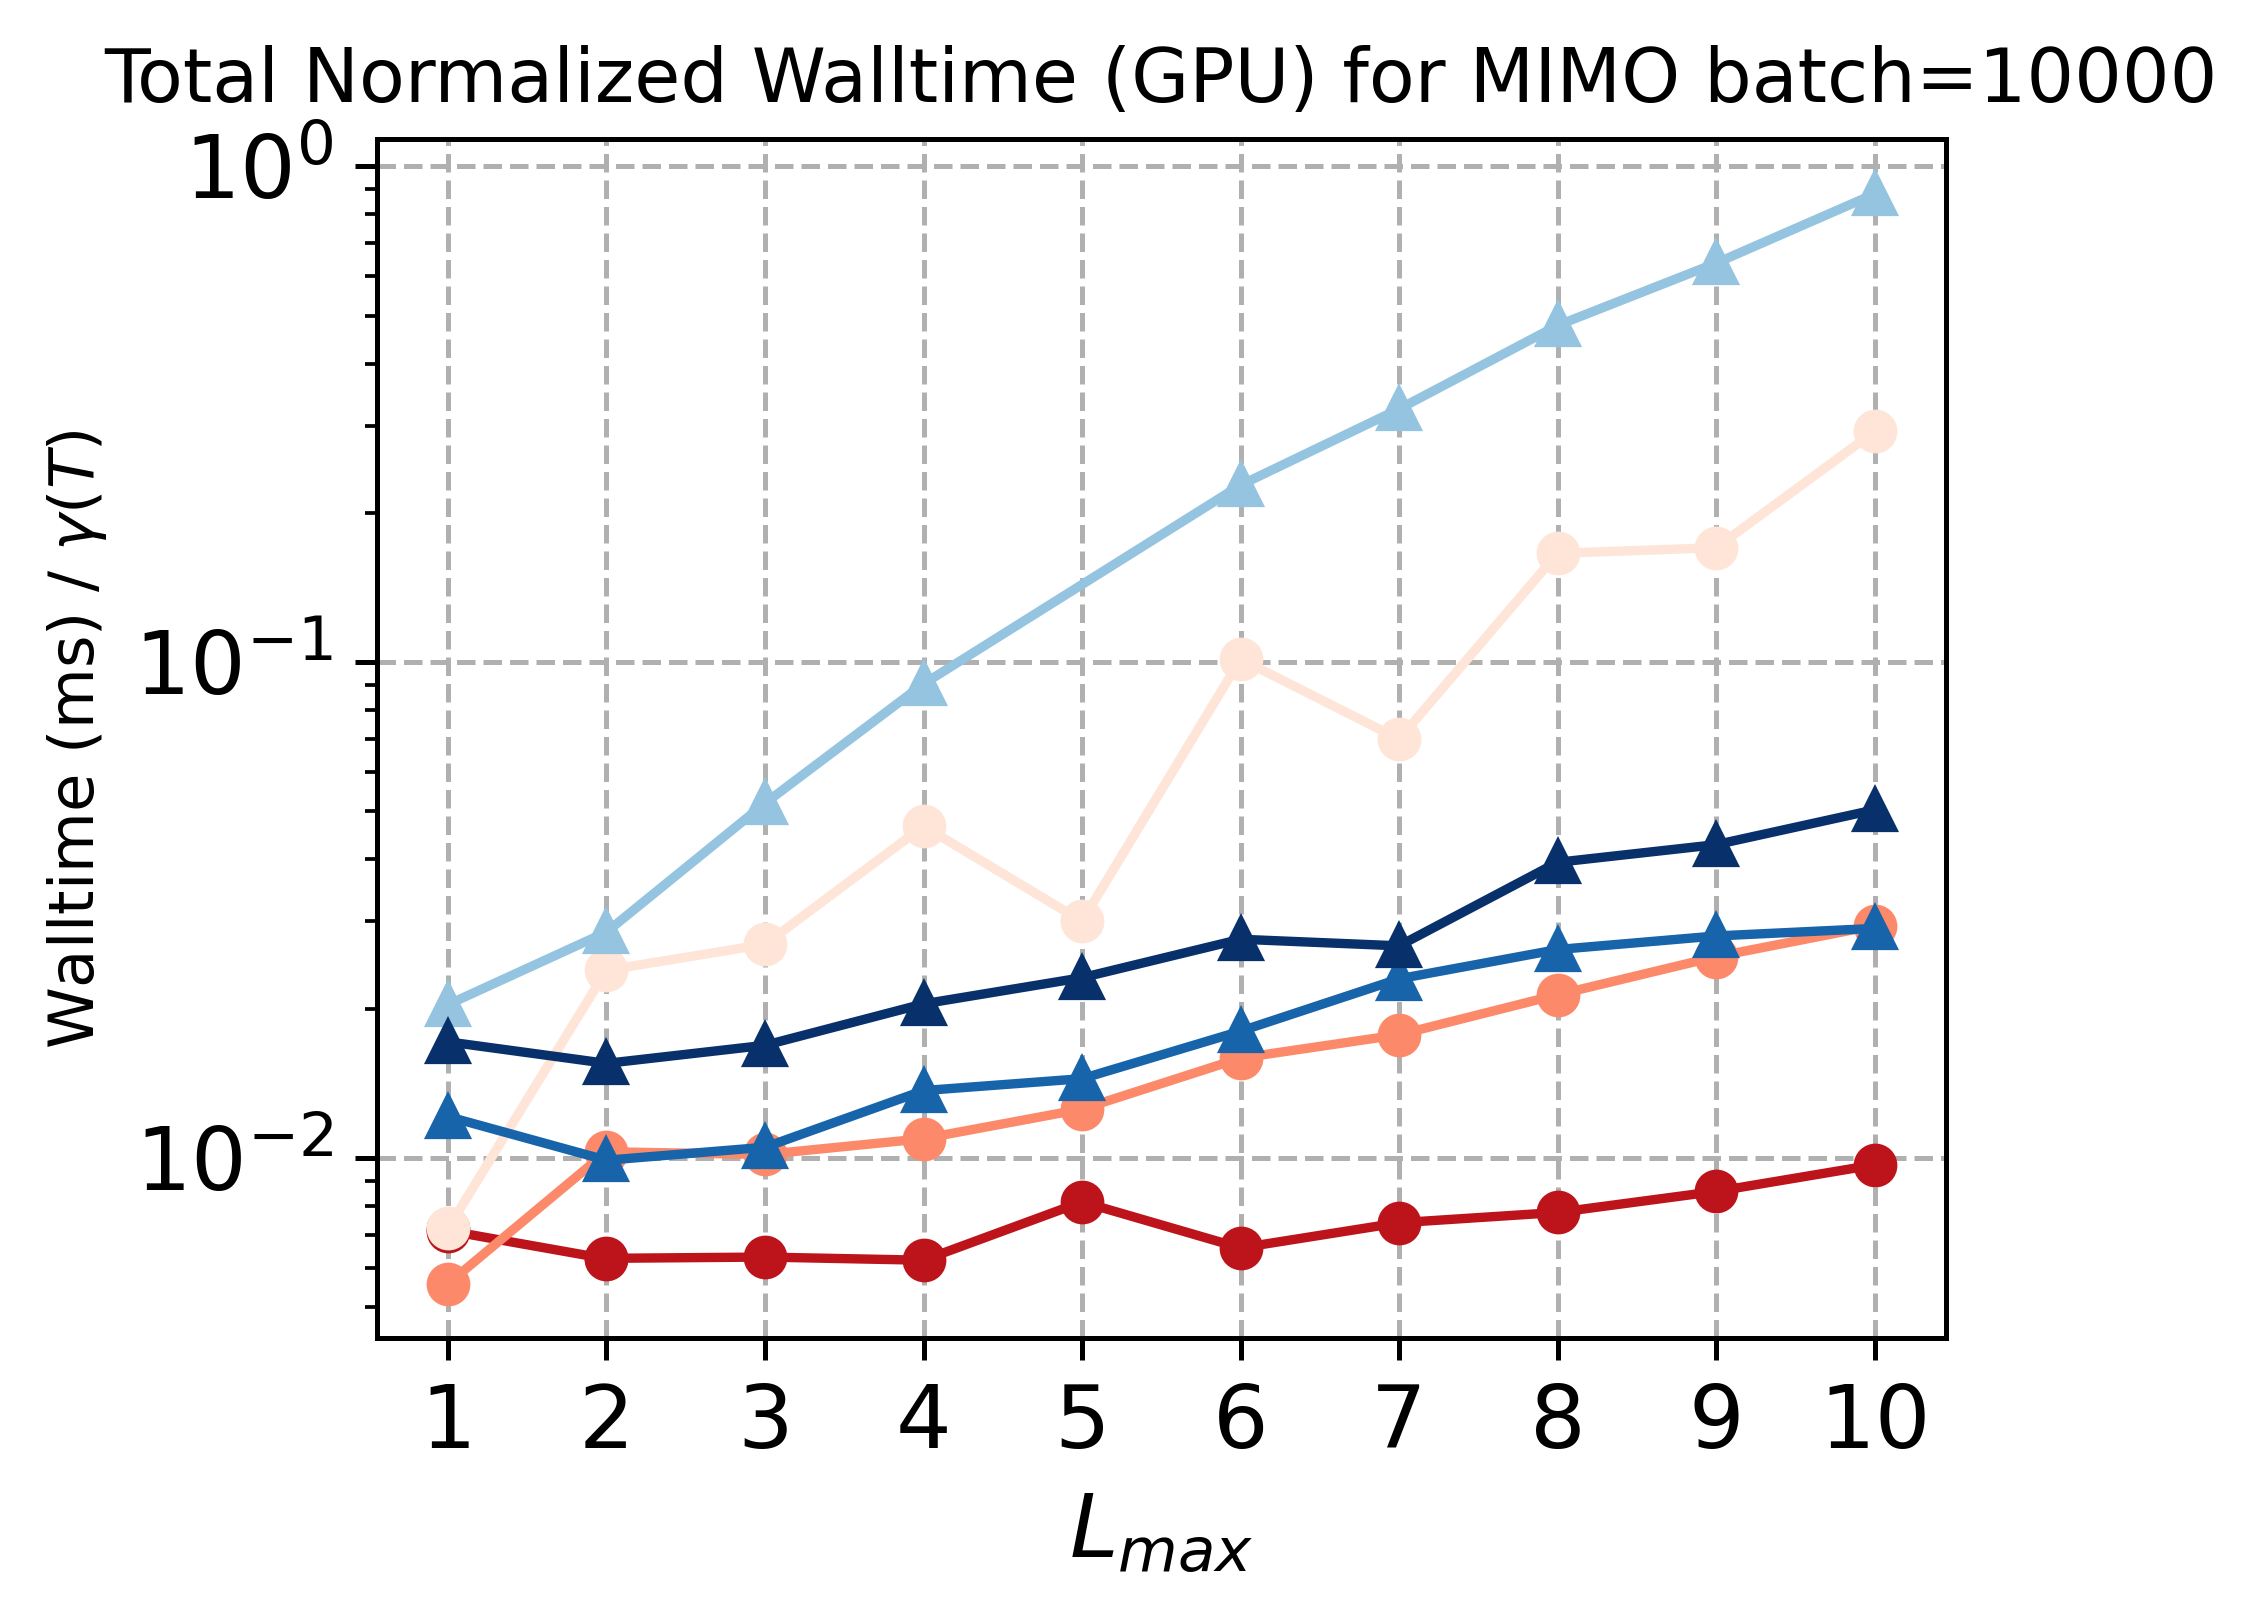

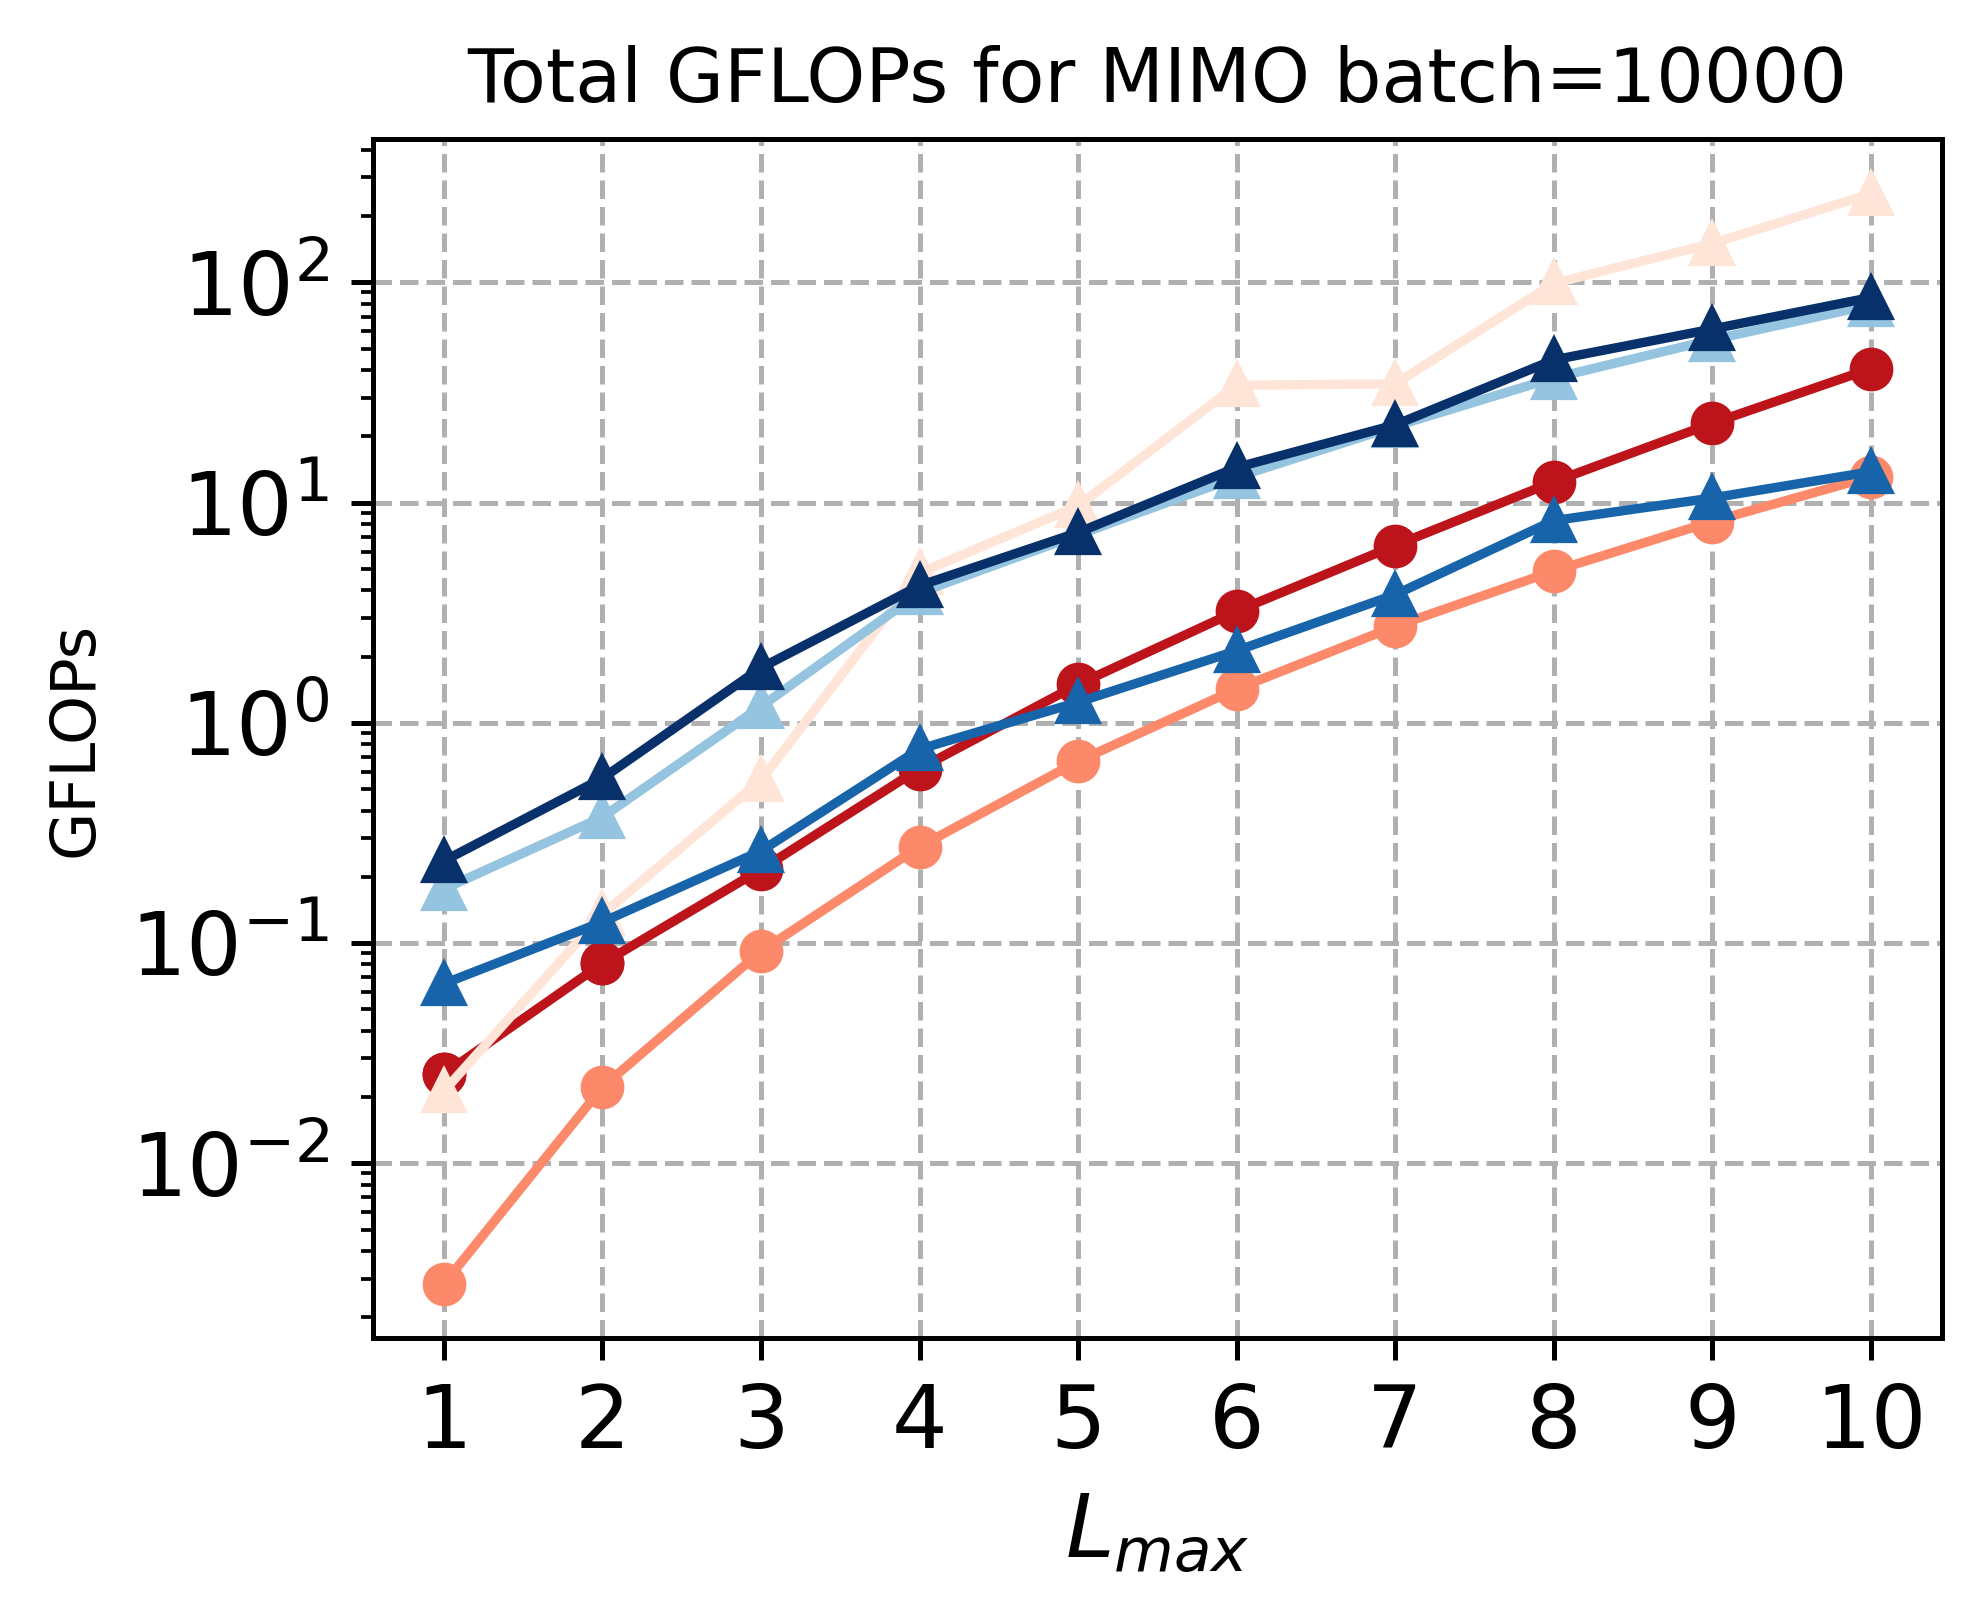

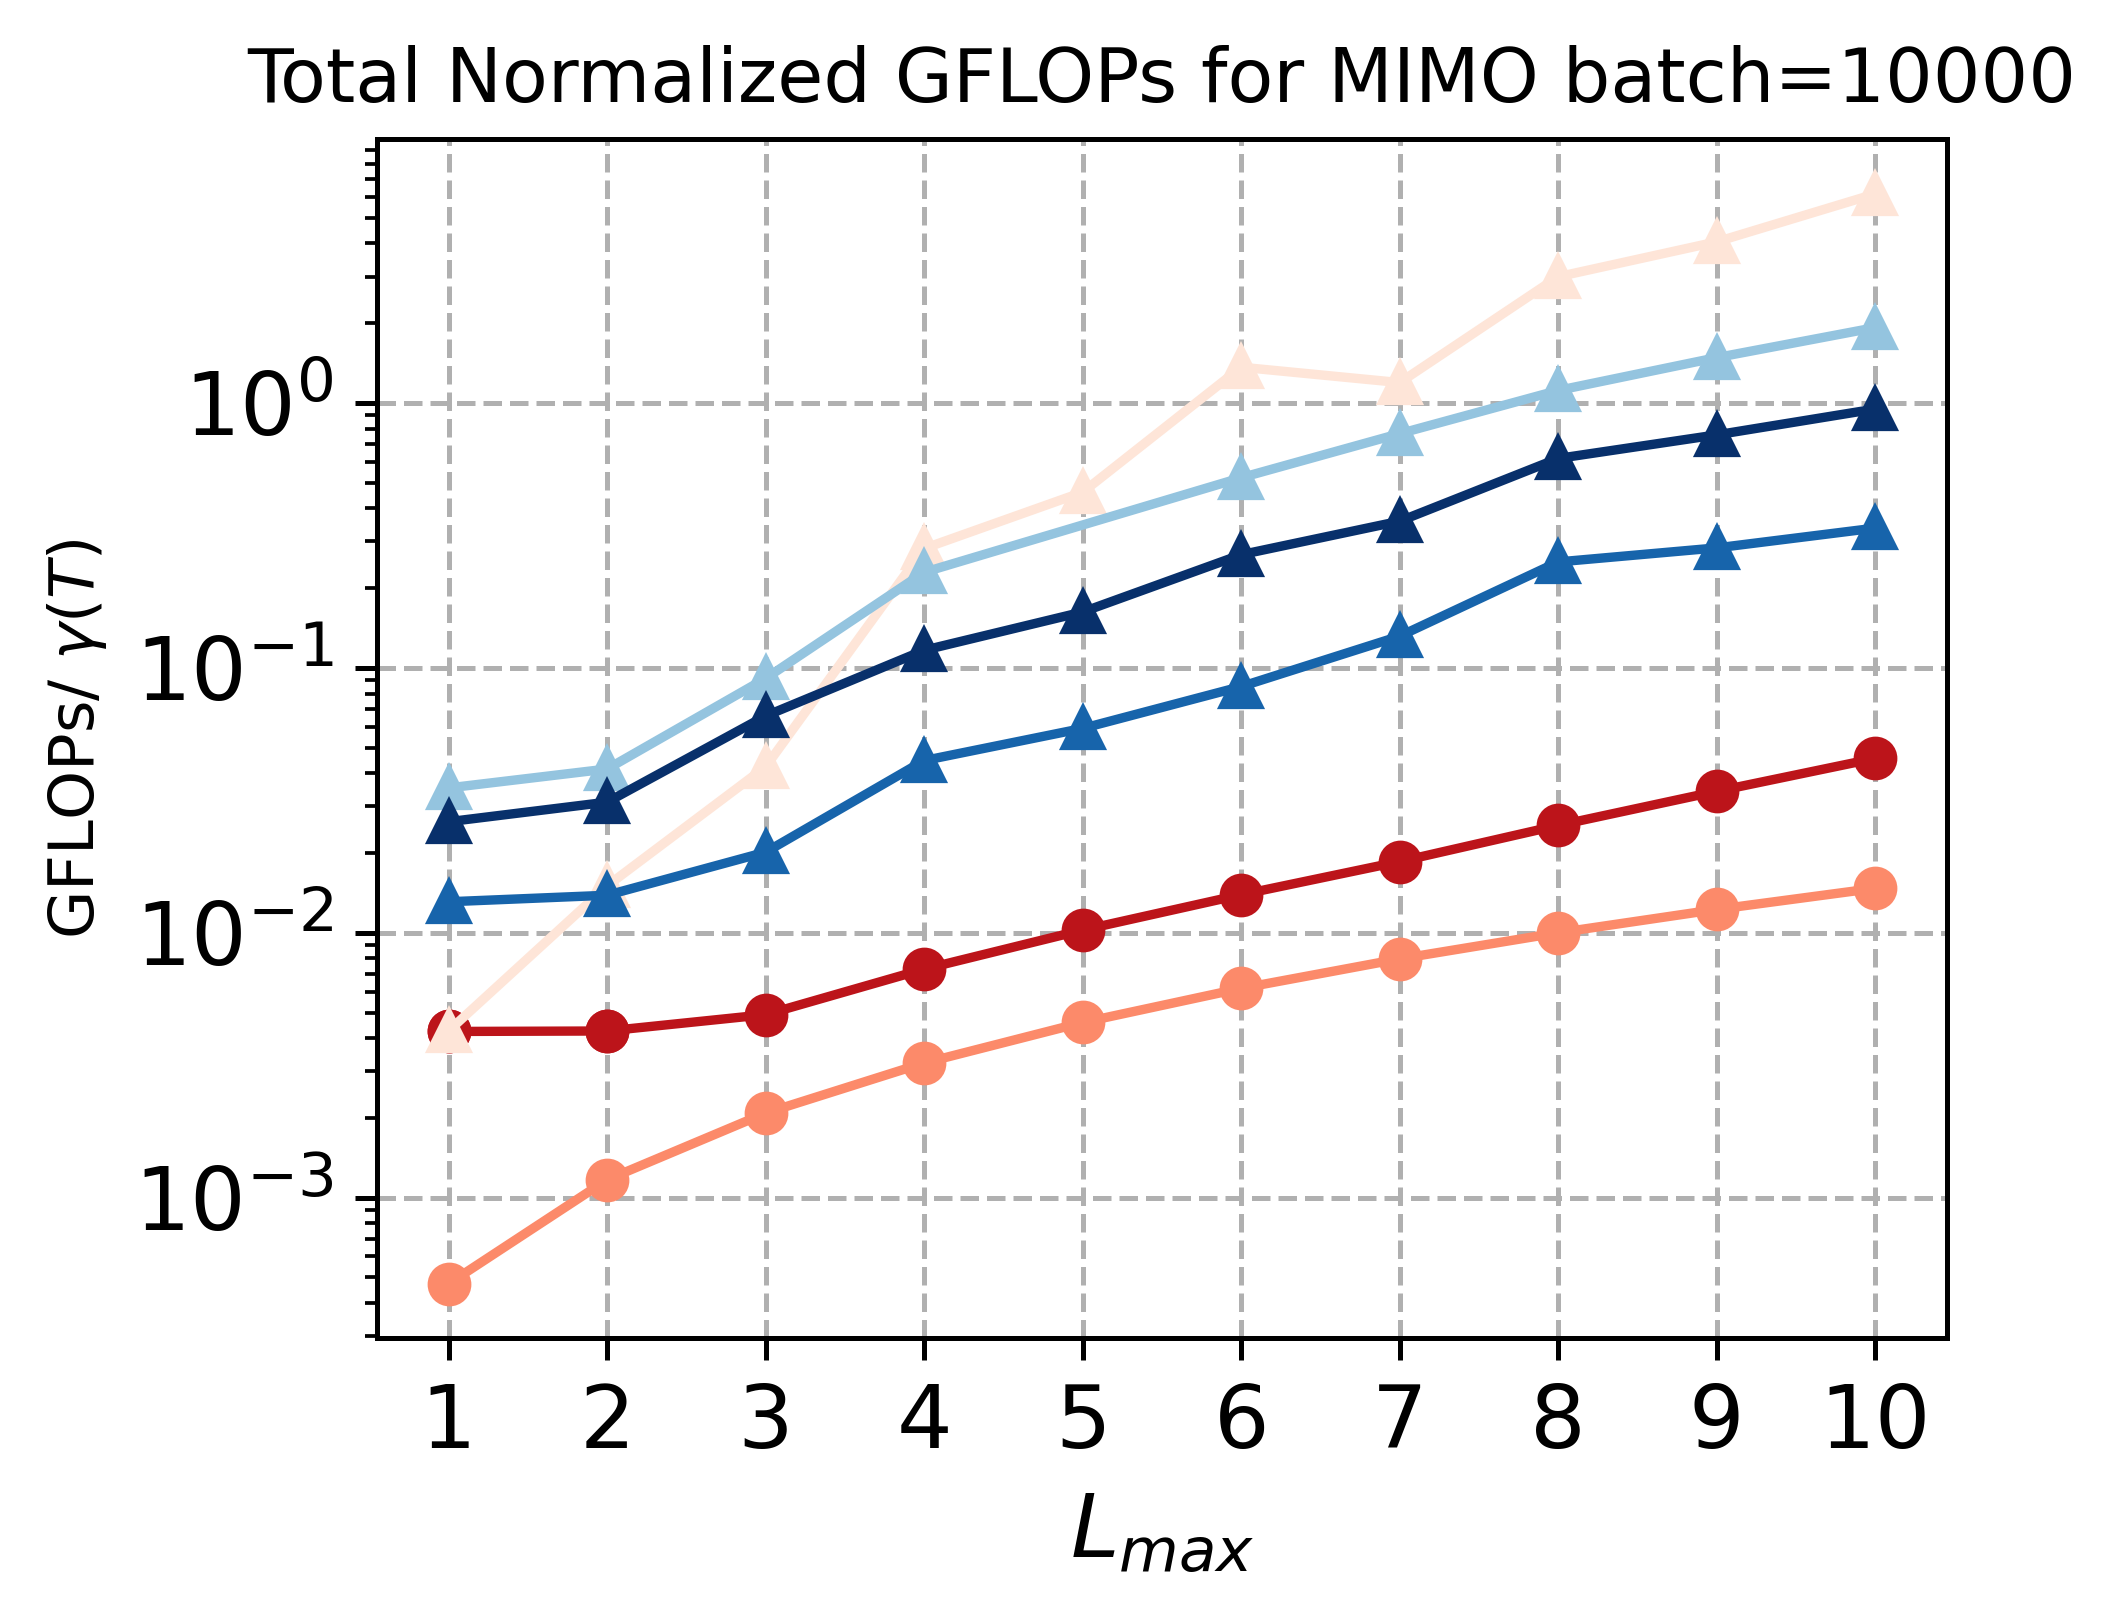

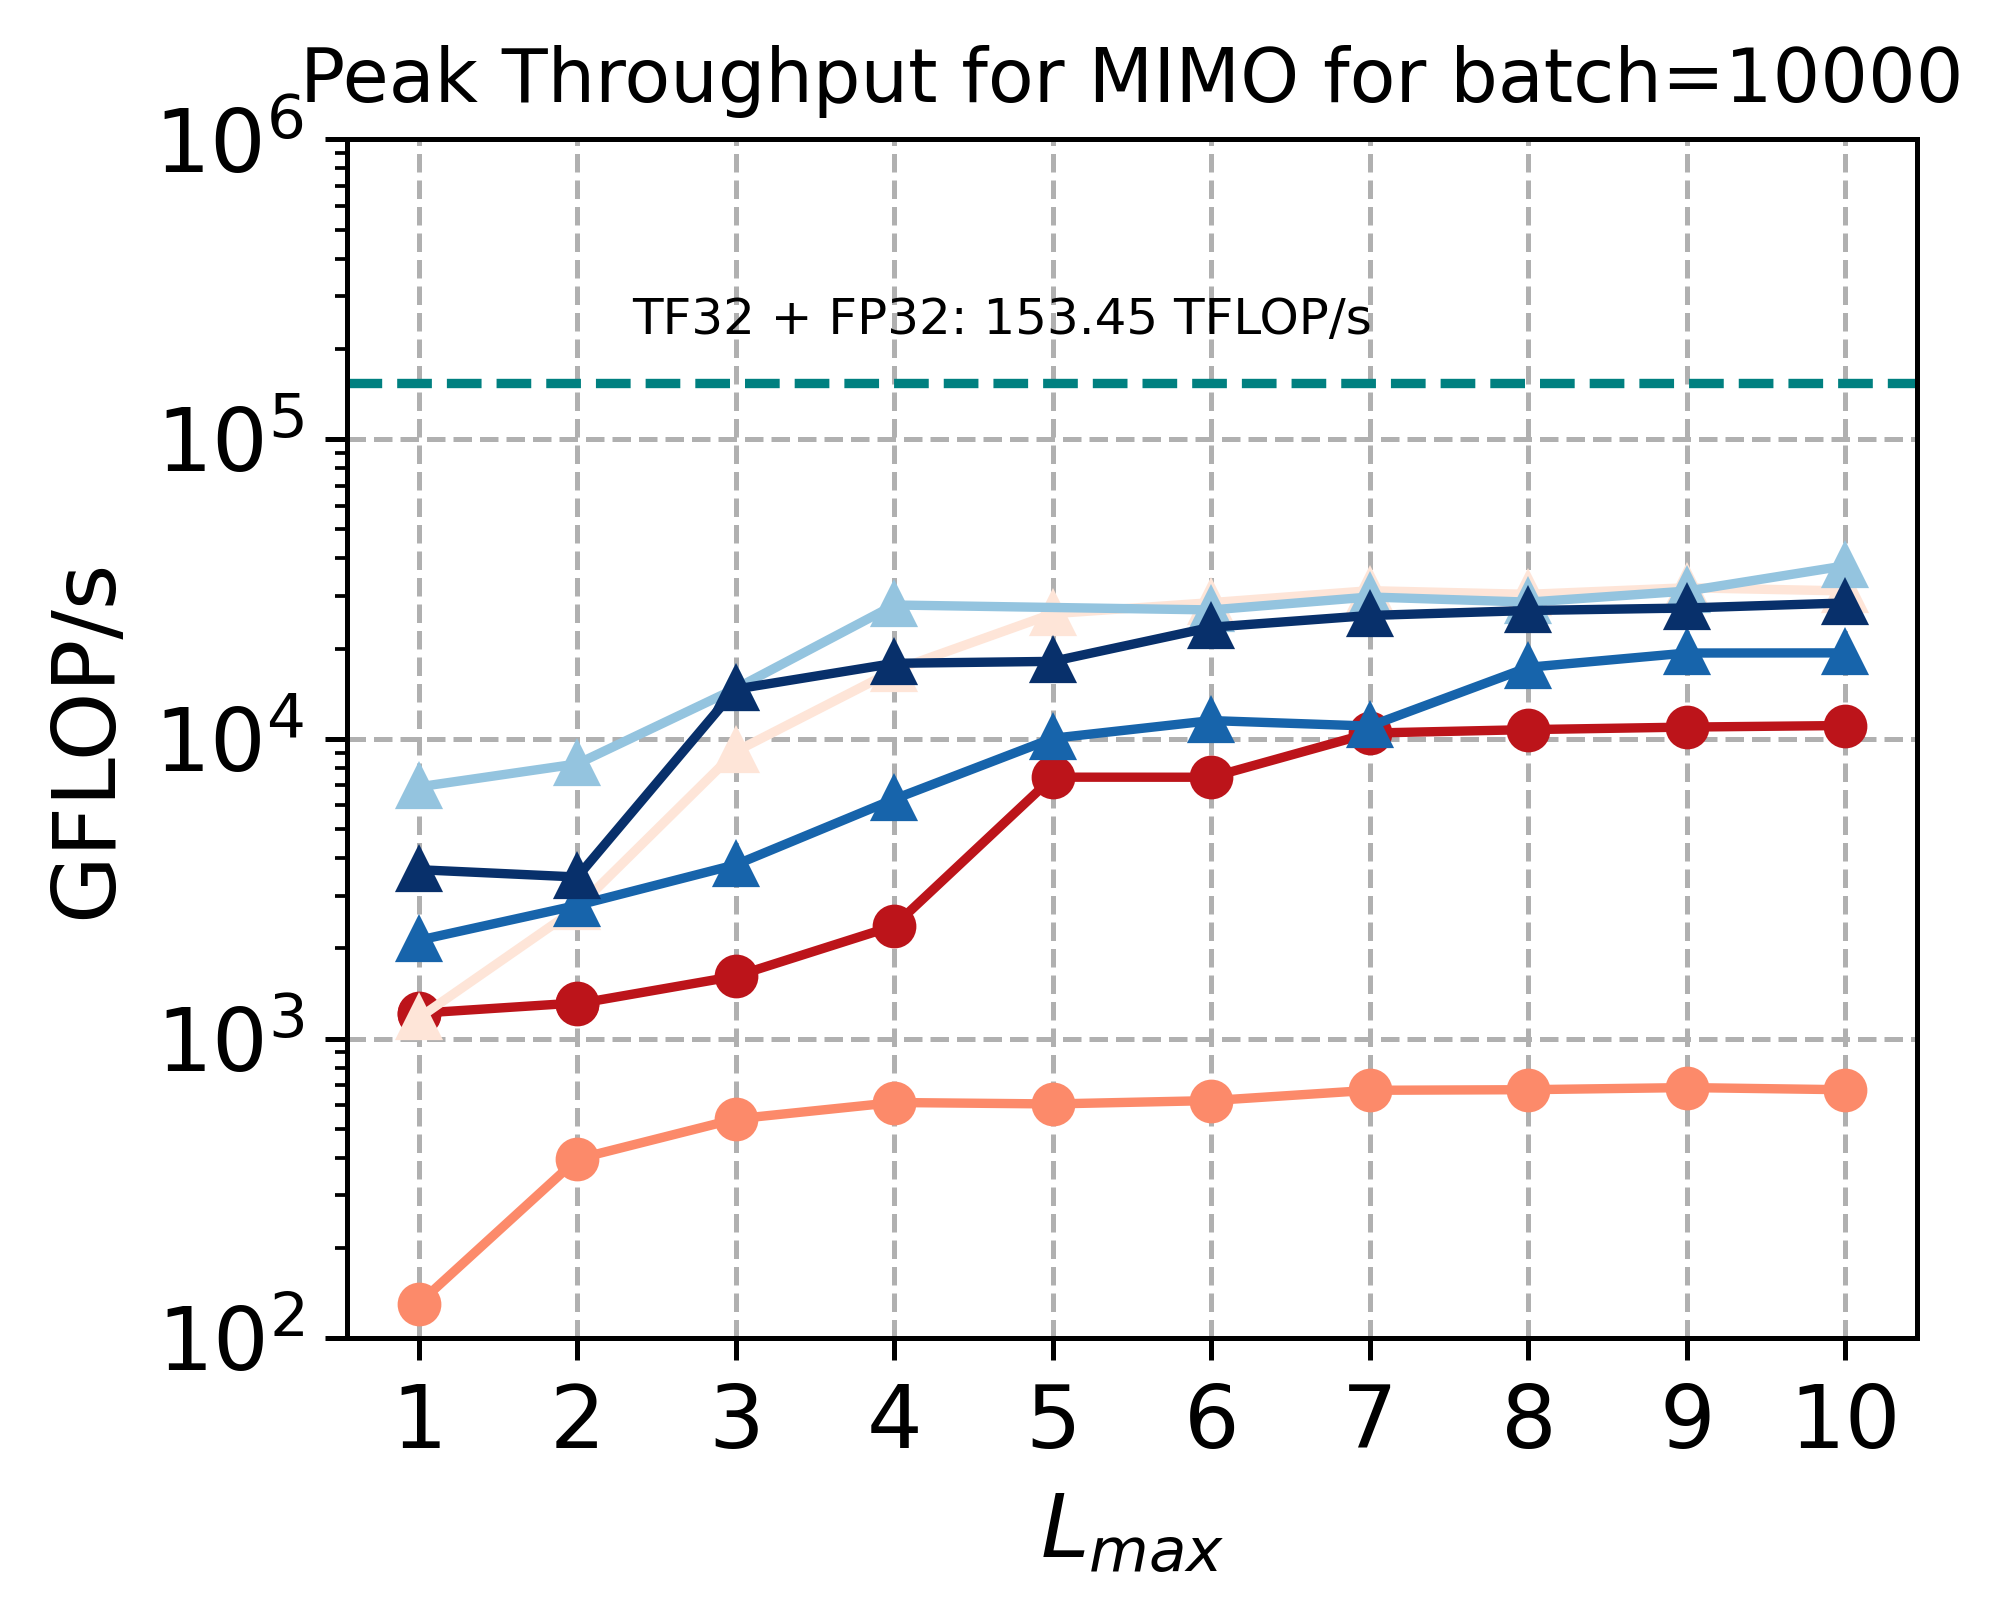

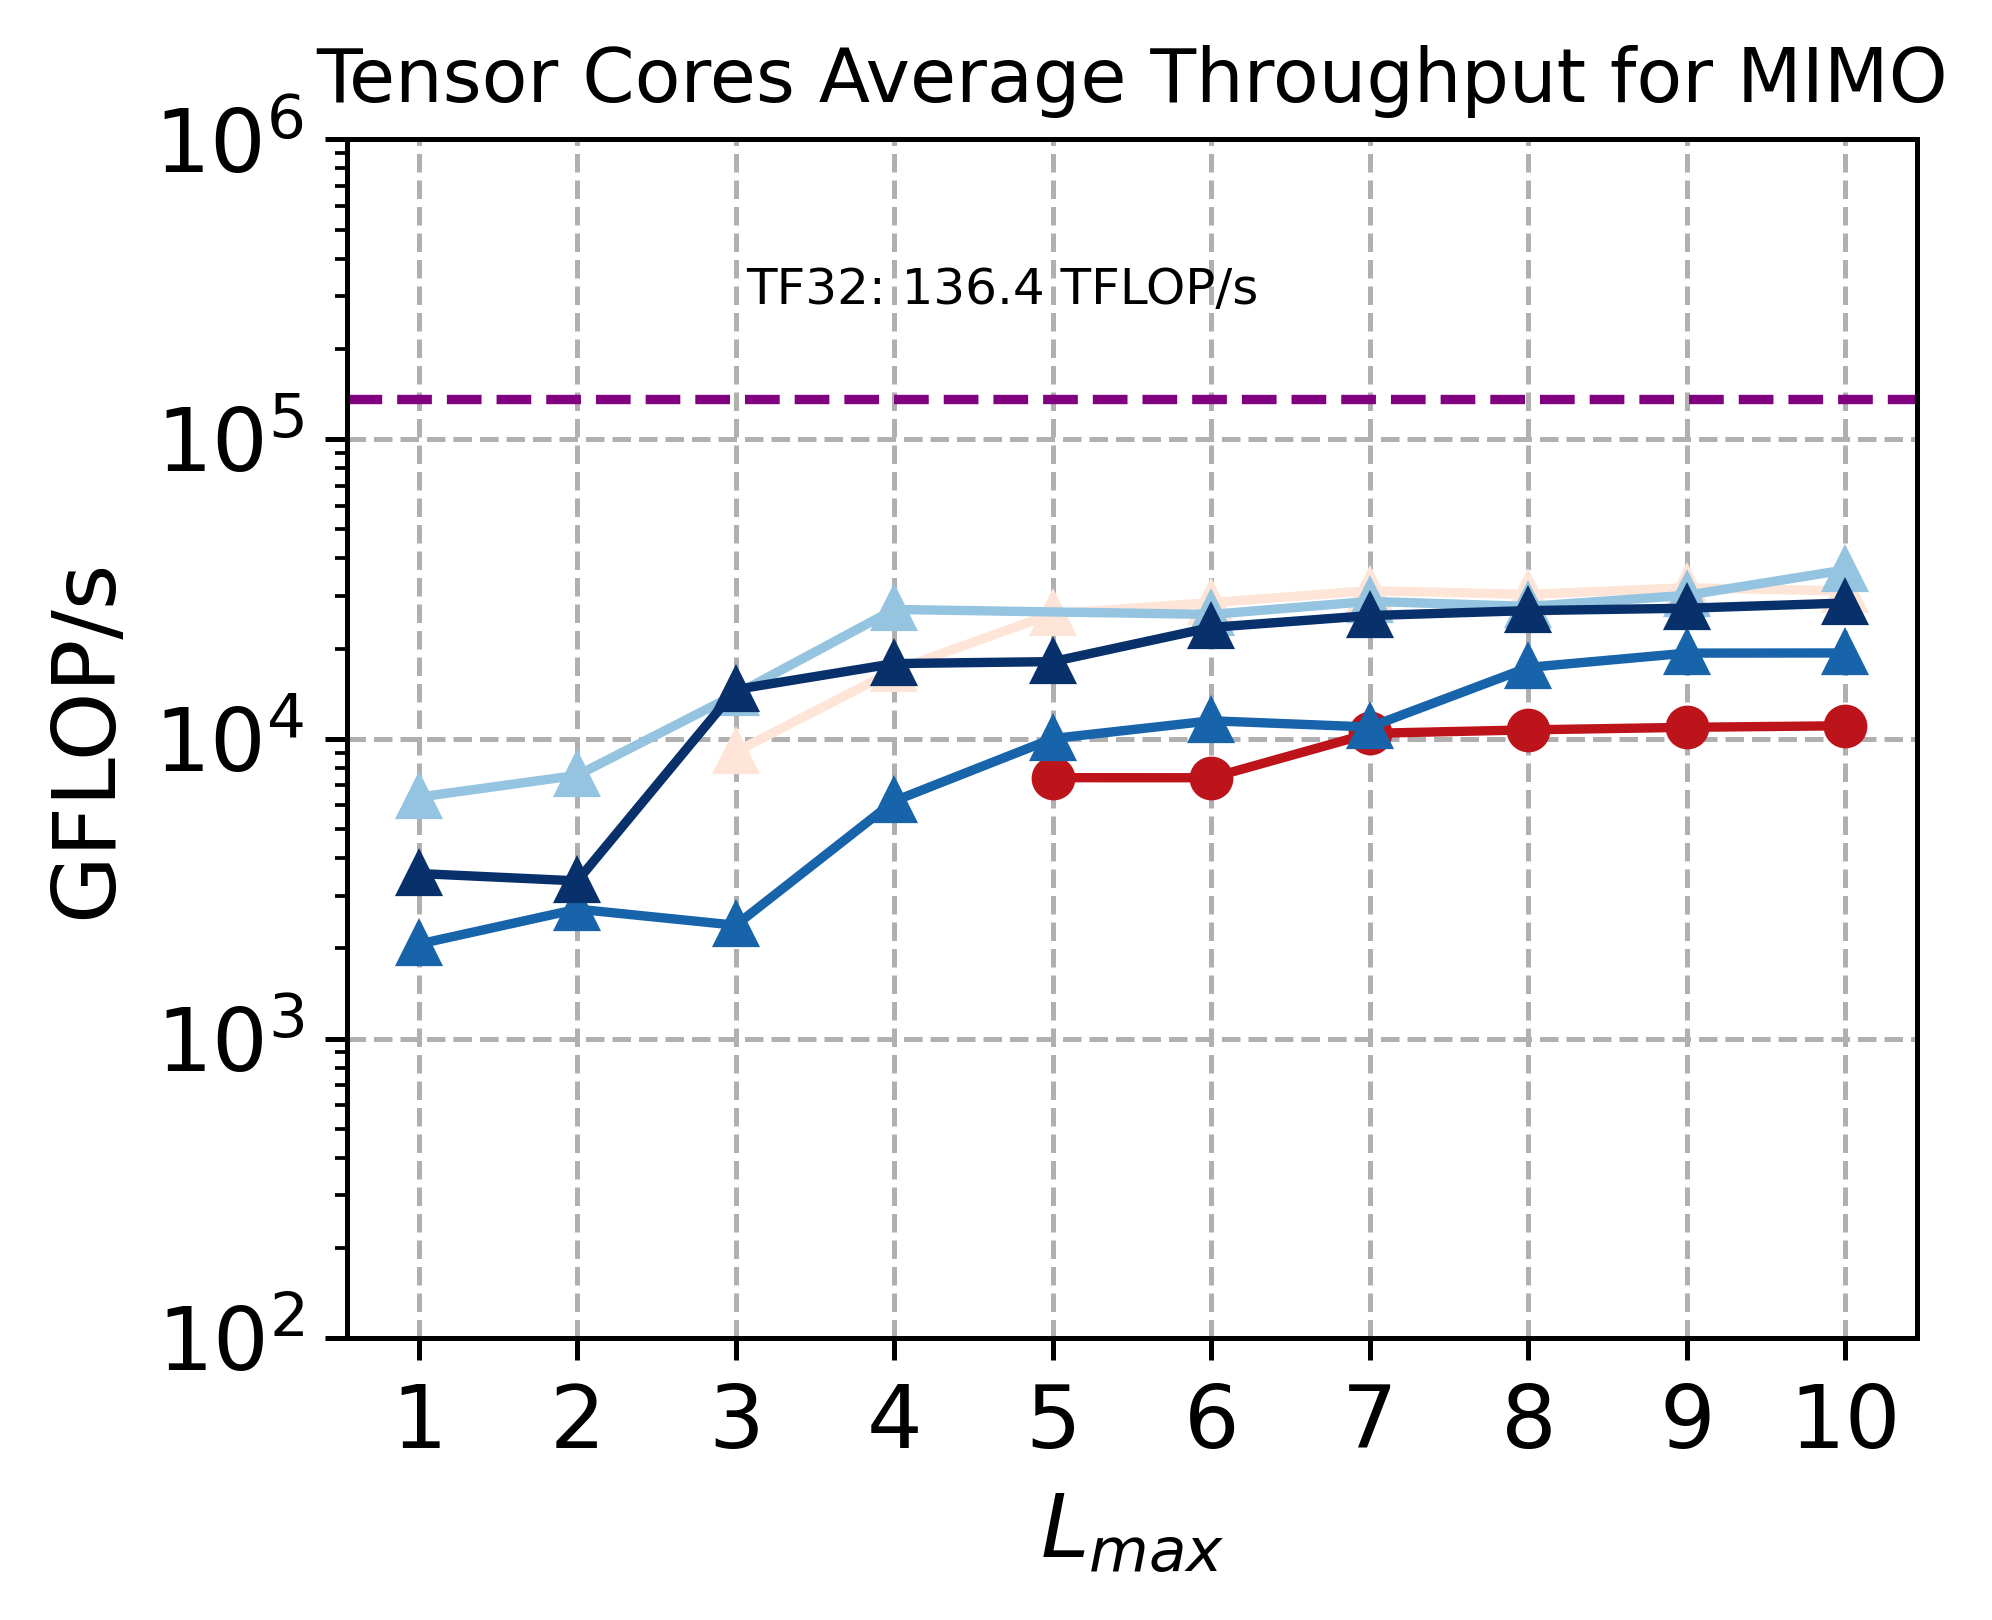

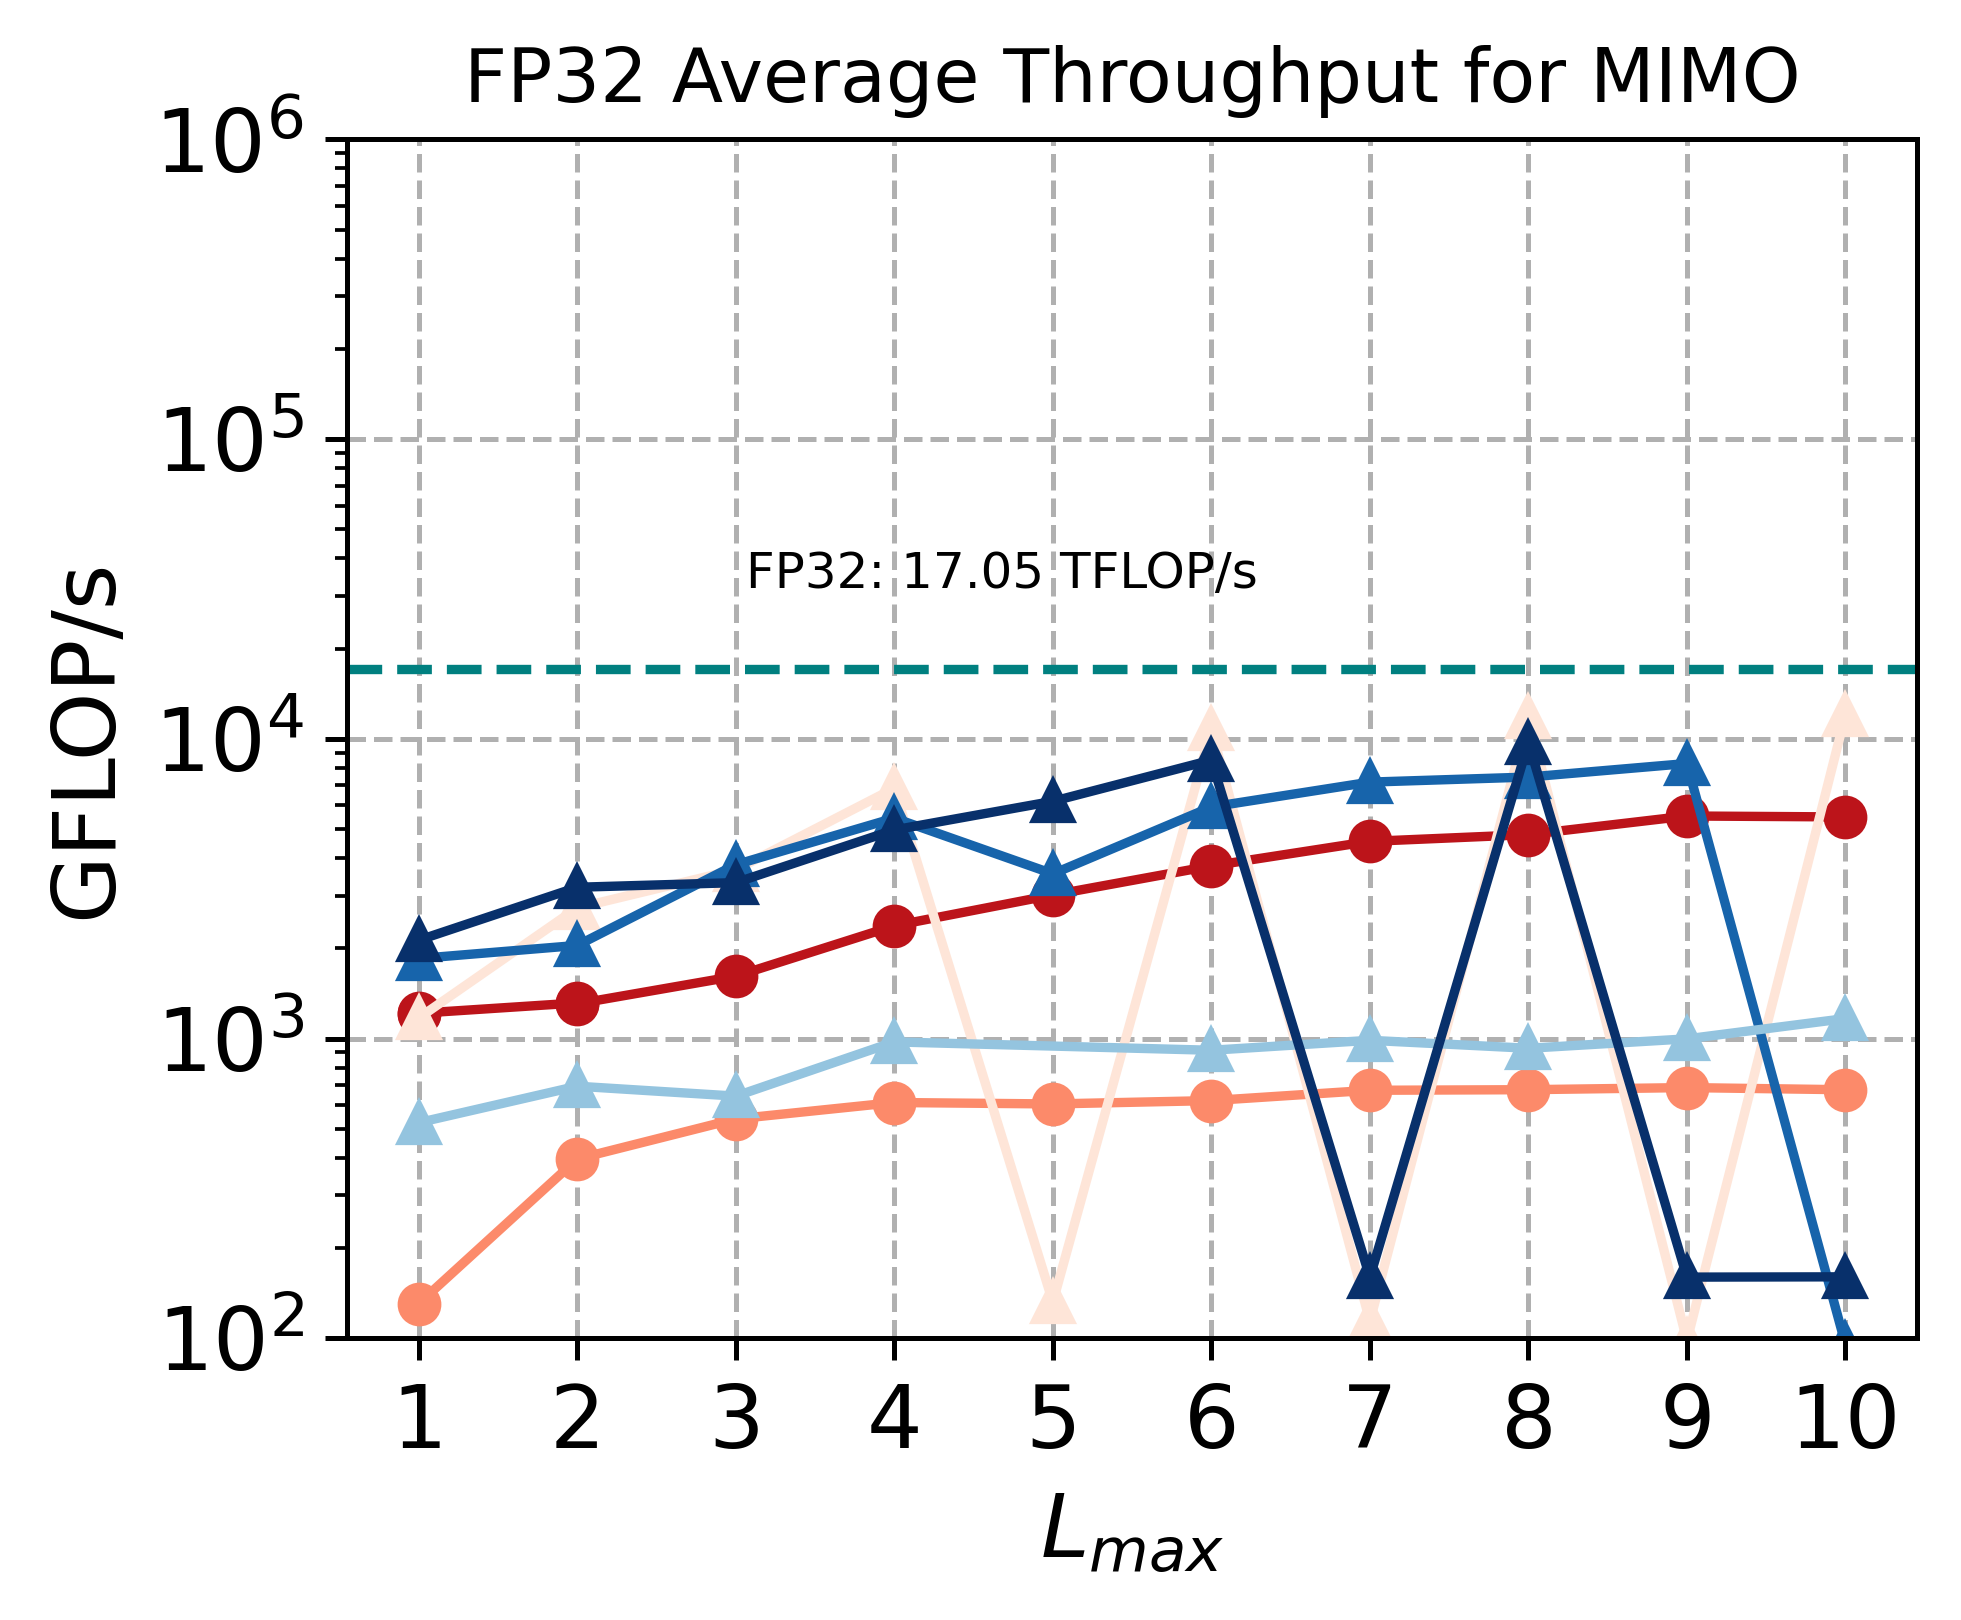

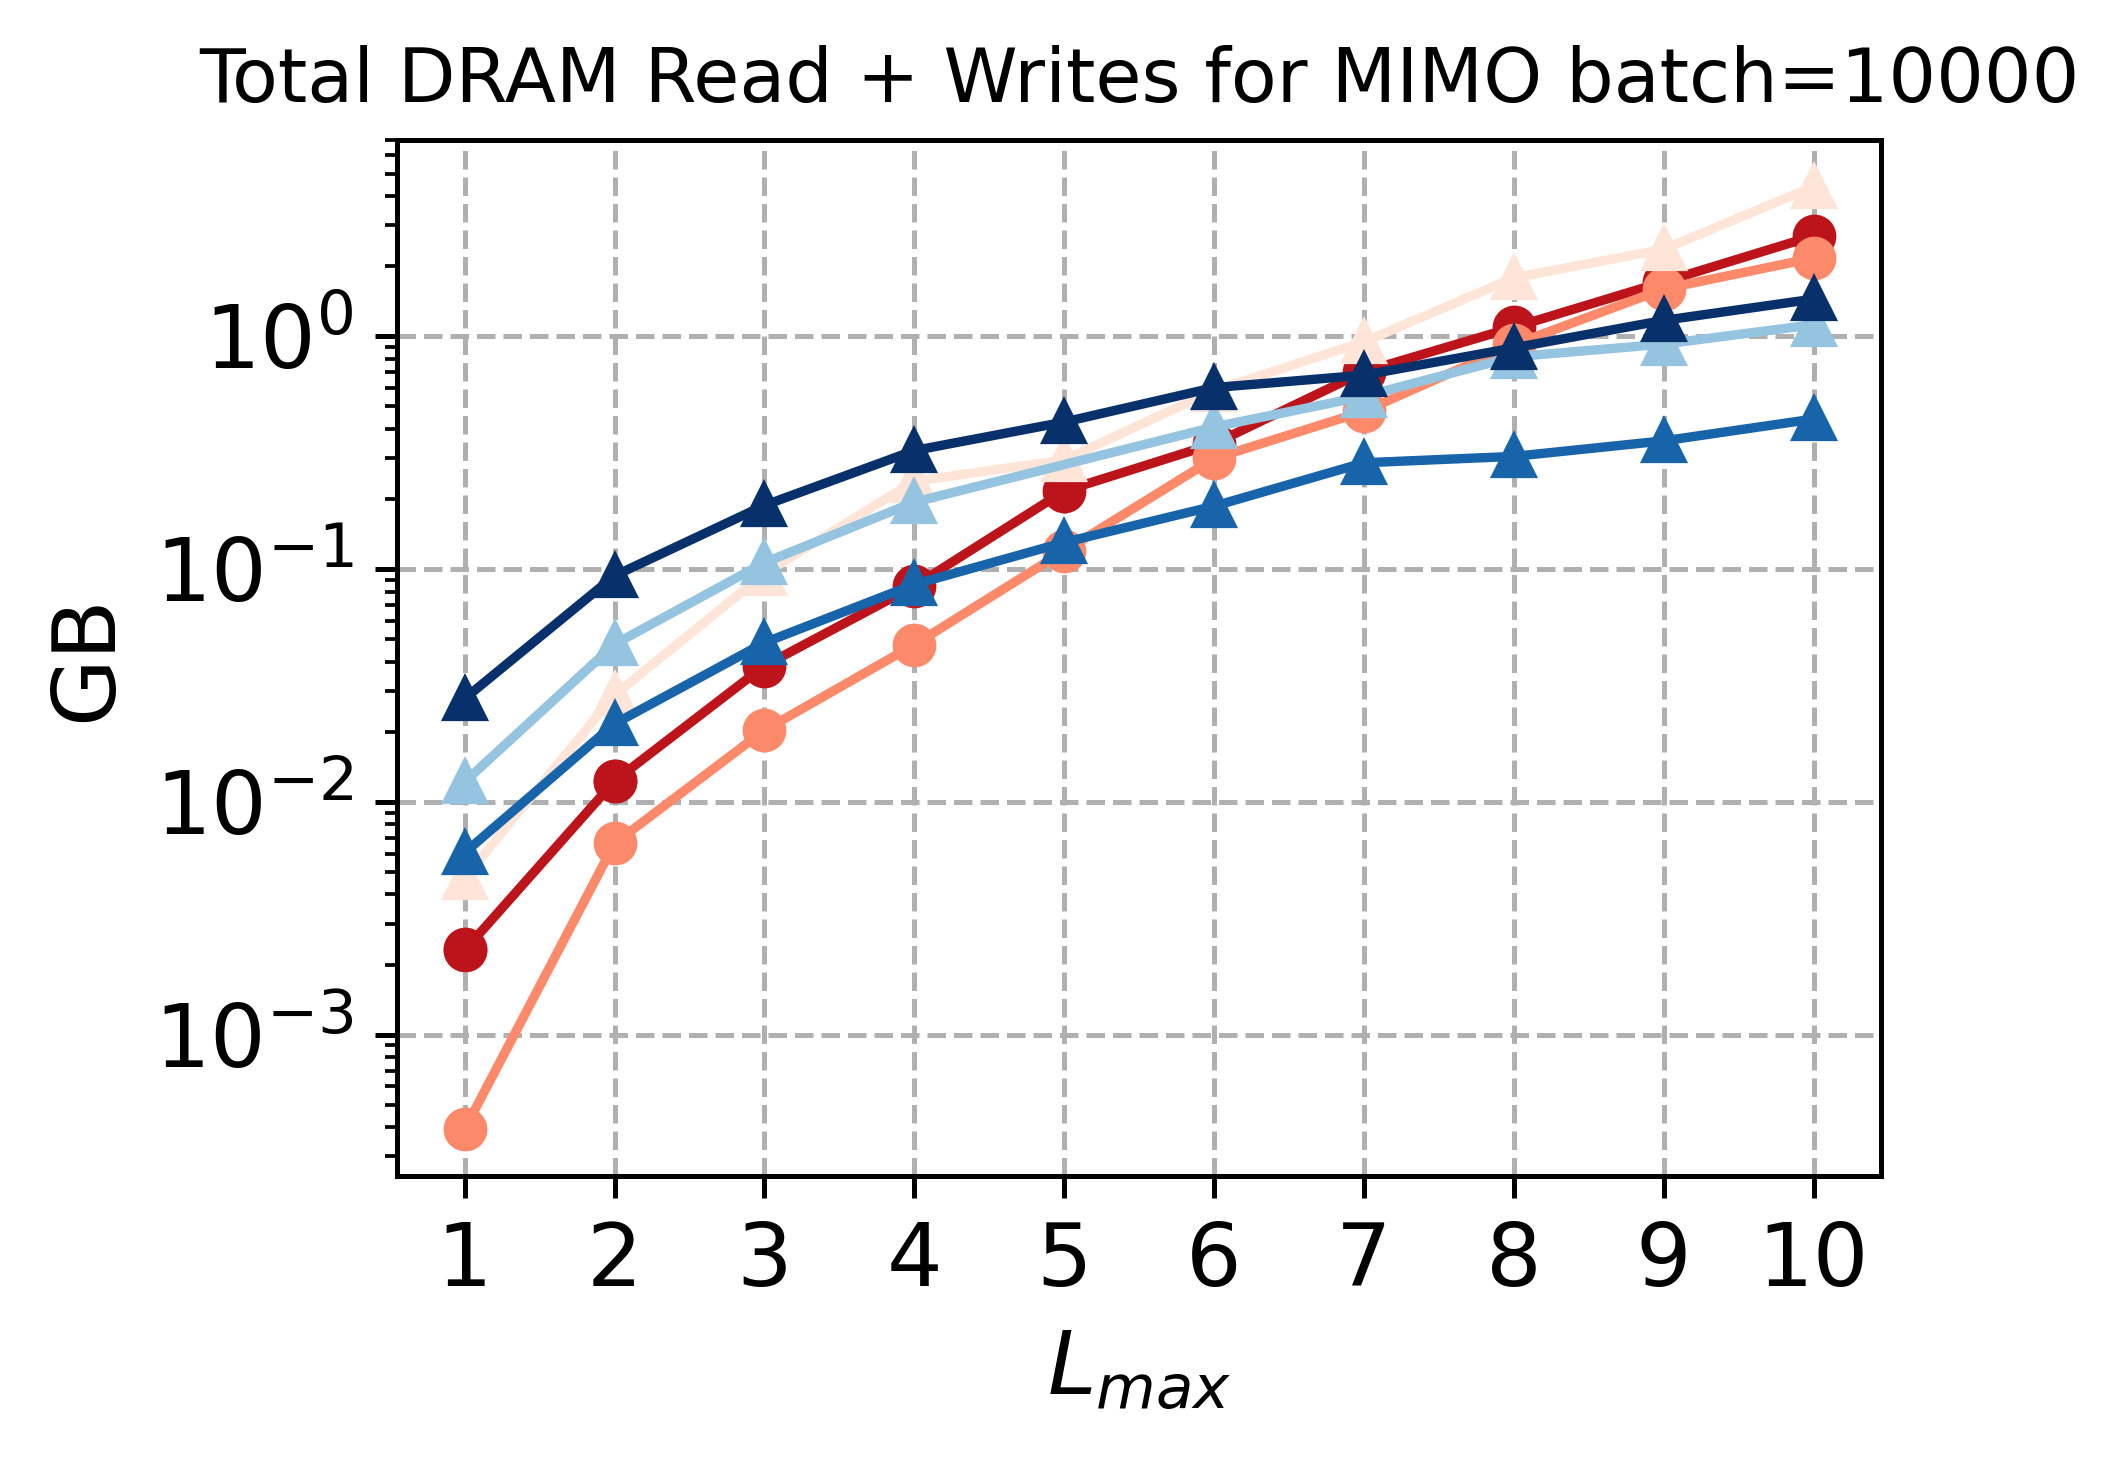

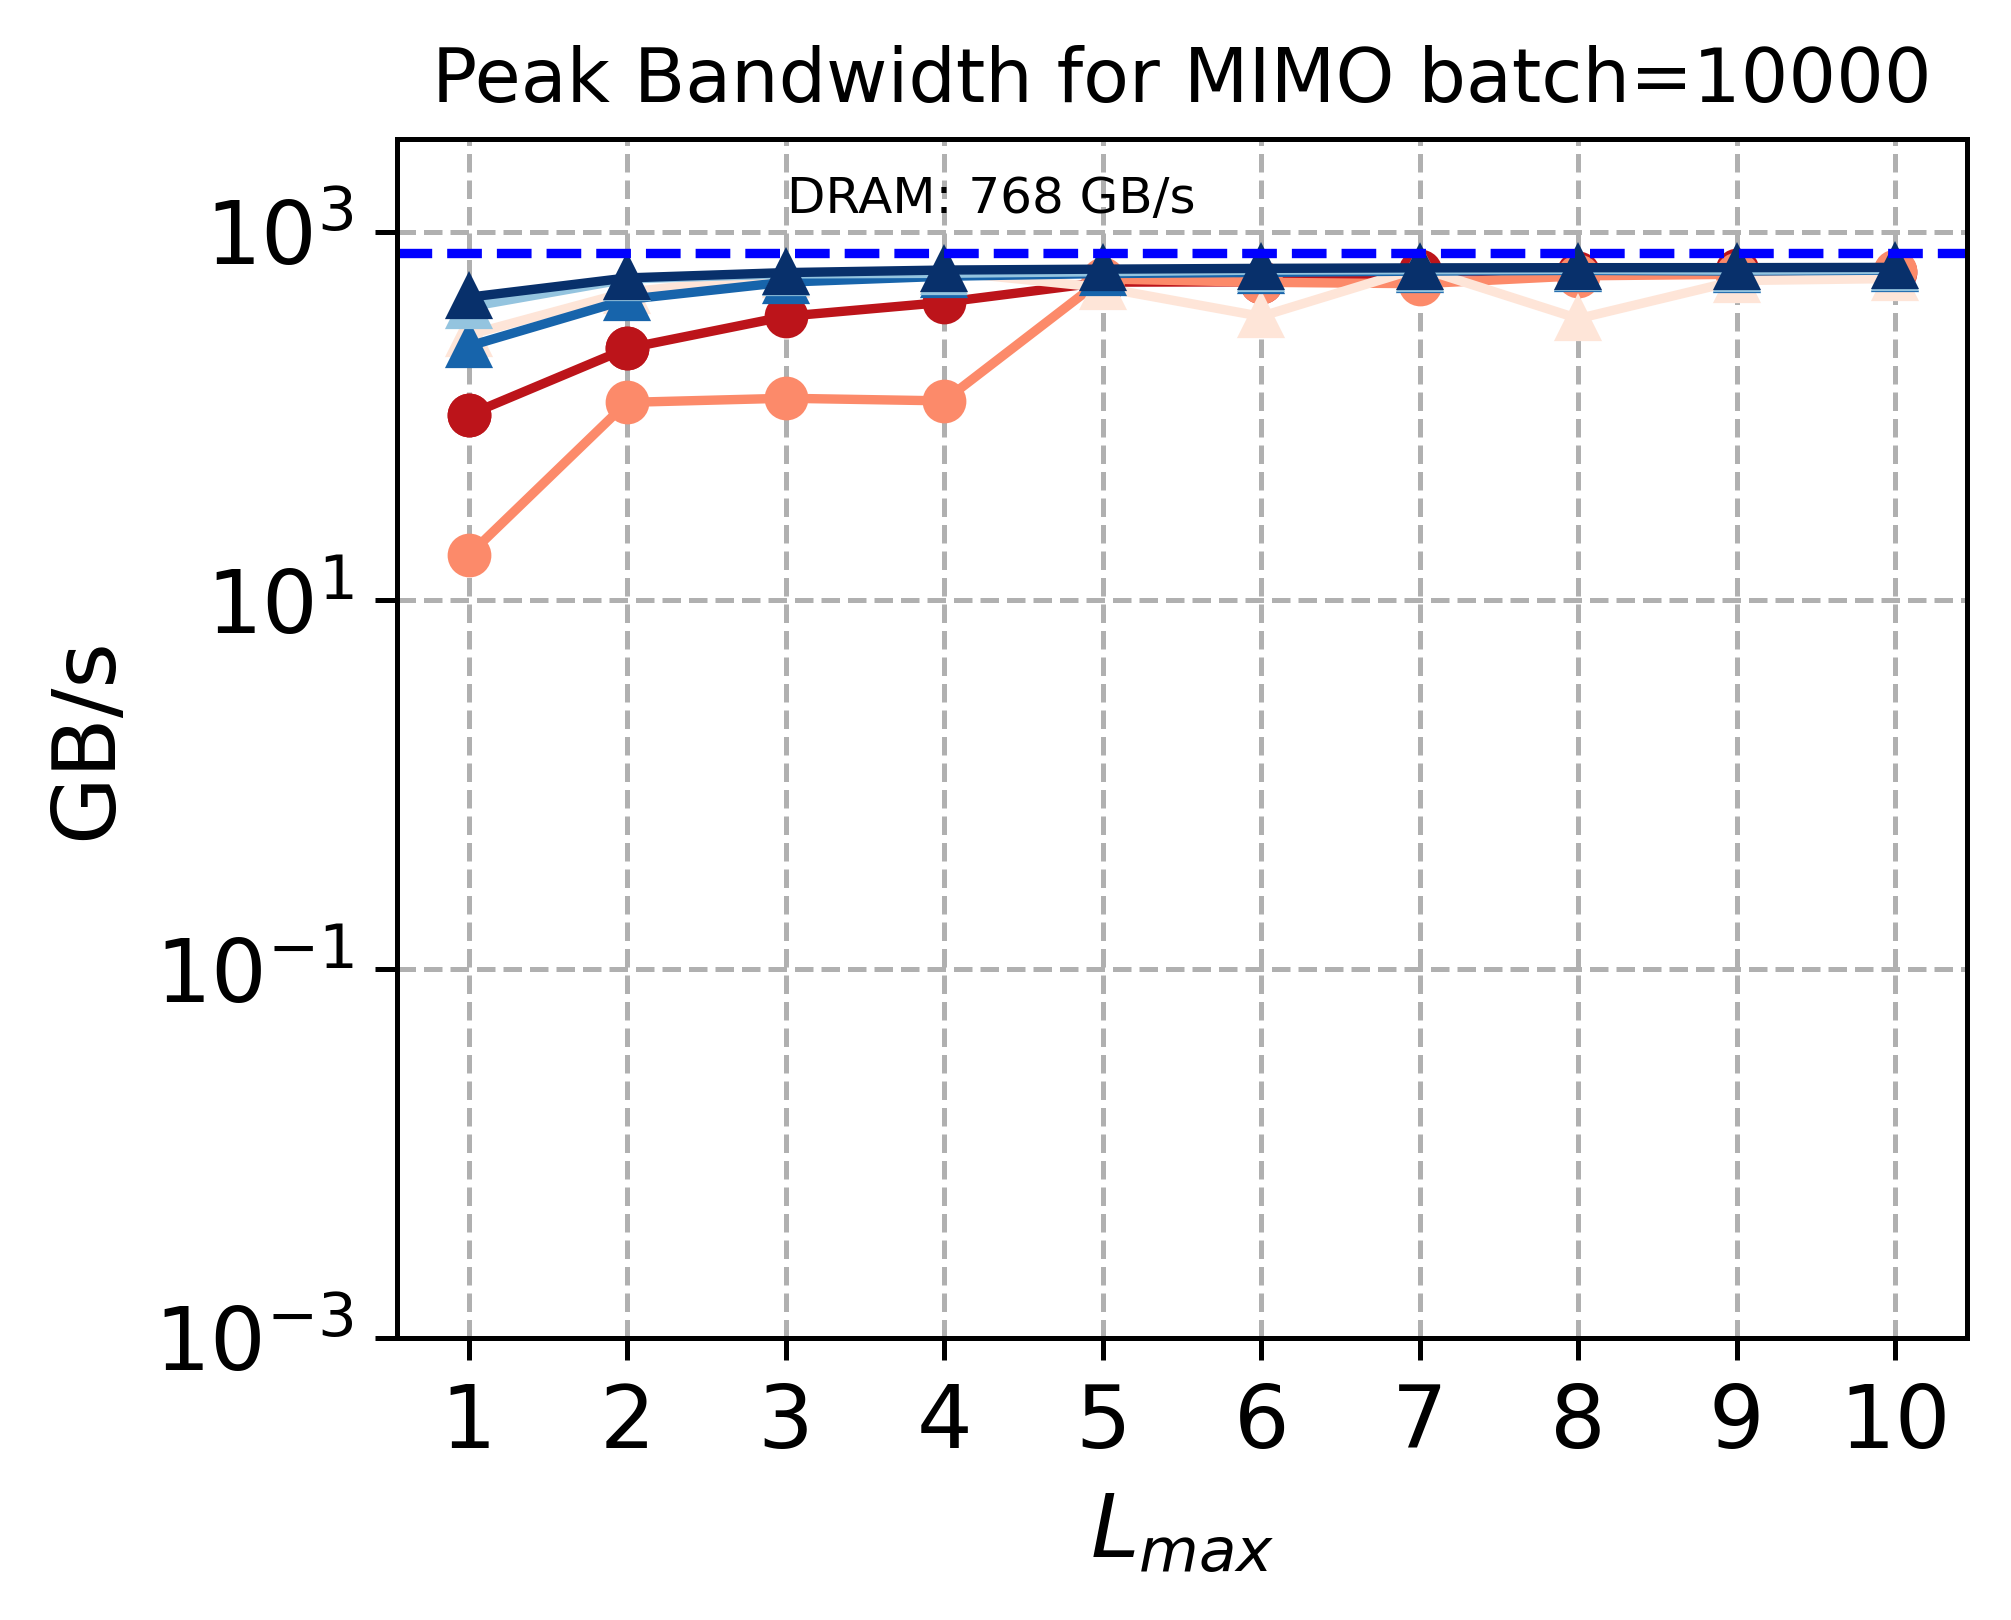

In [12]:
plot_iclr_sweep("MIMO", 10000)

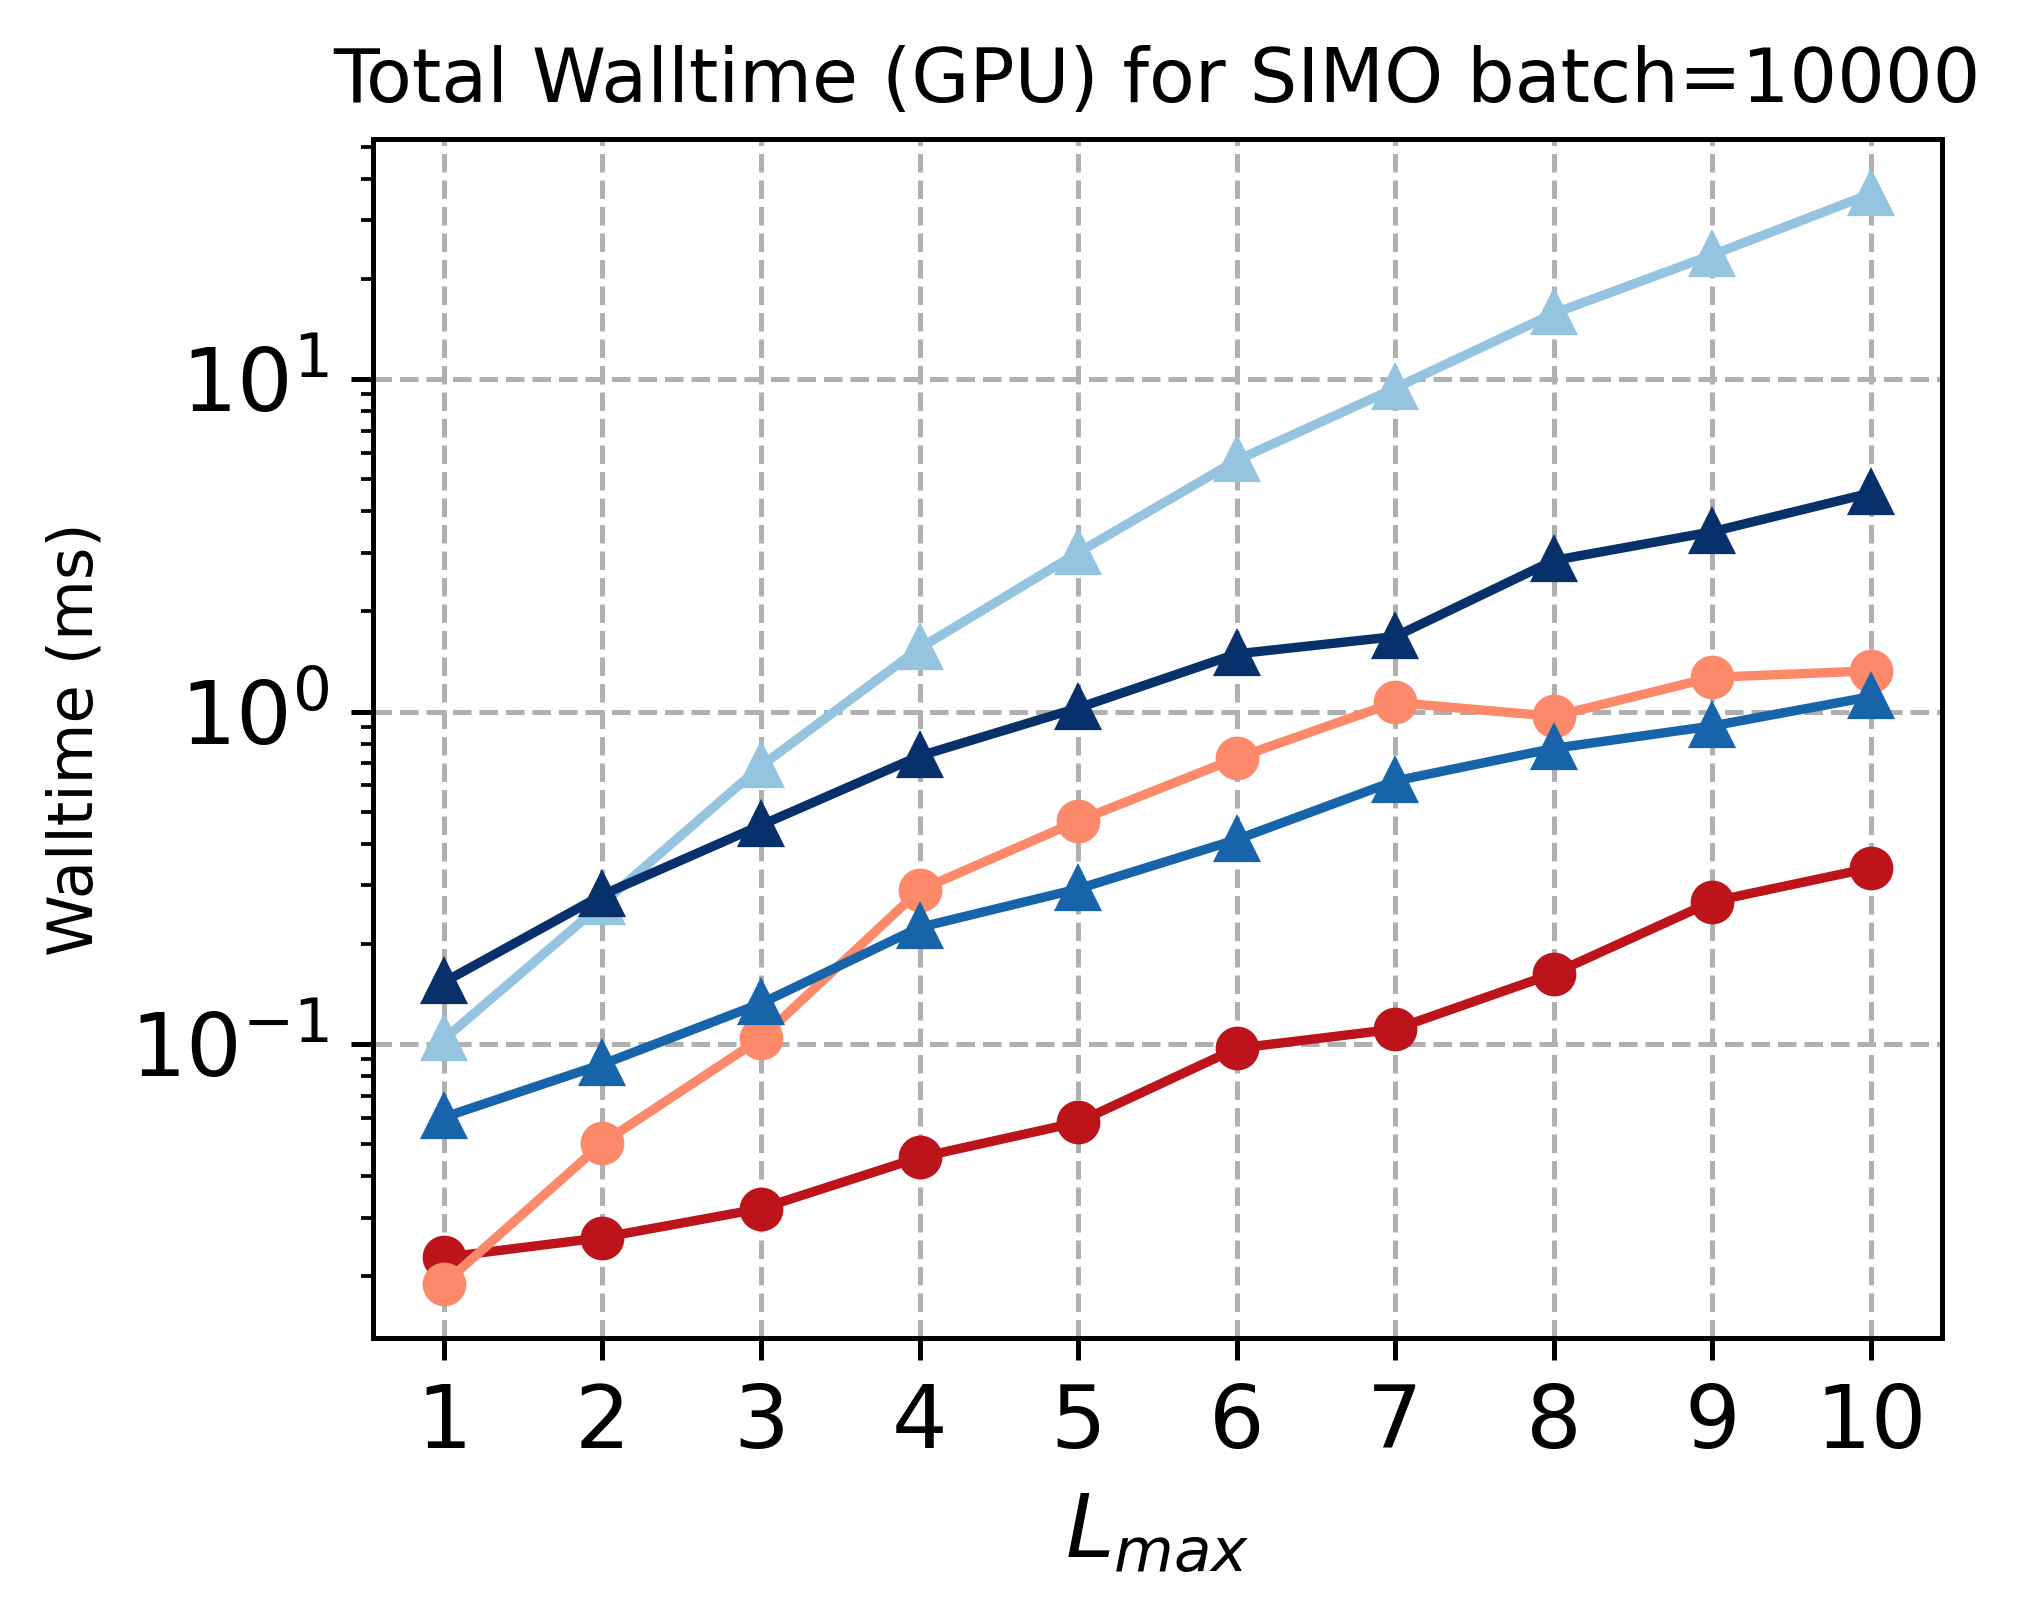

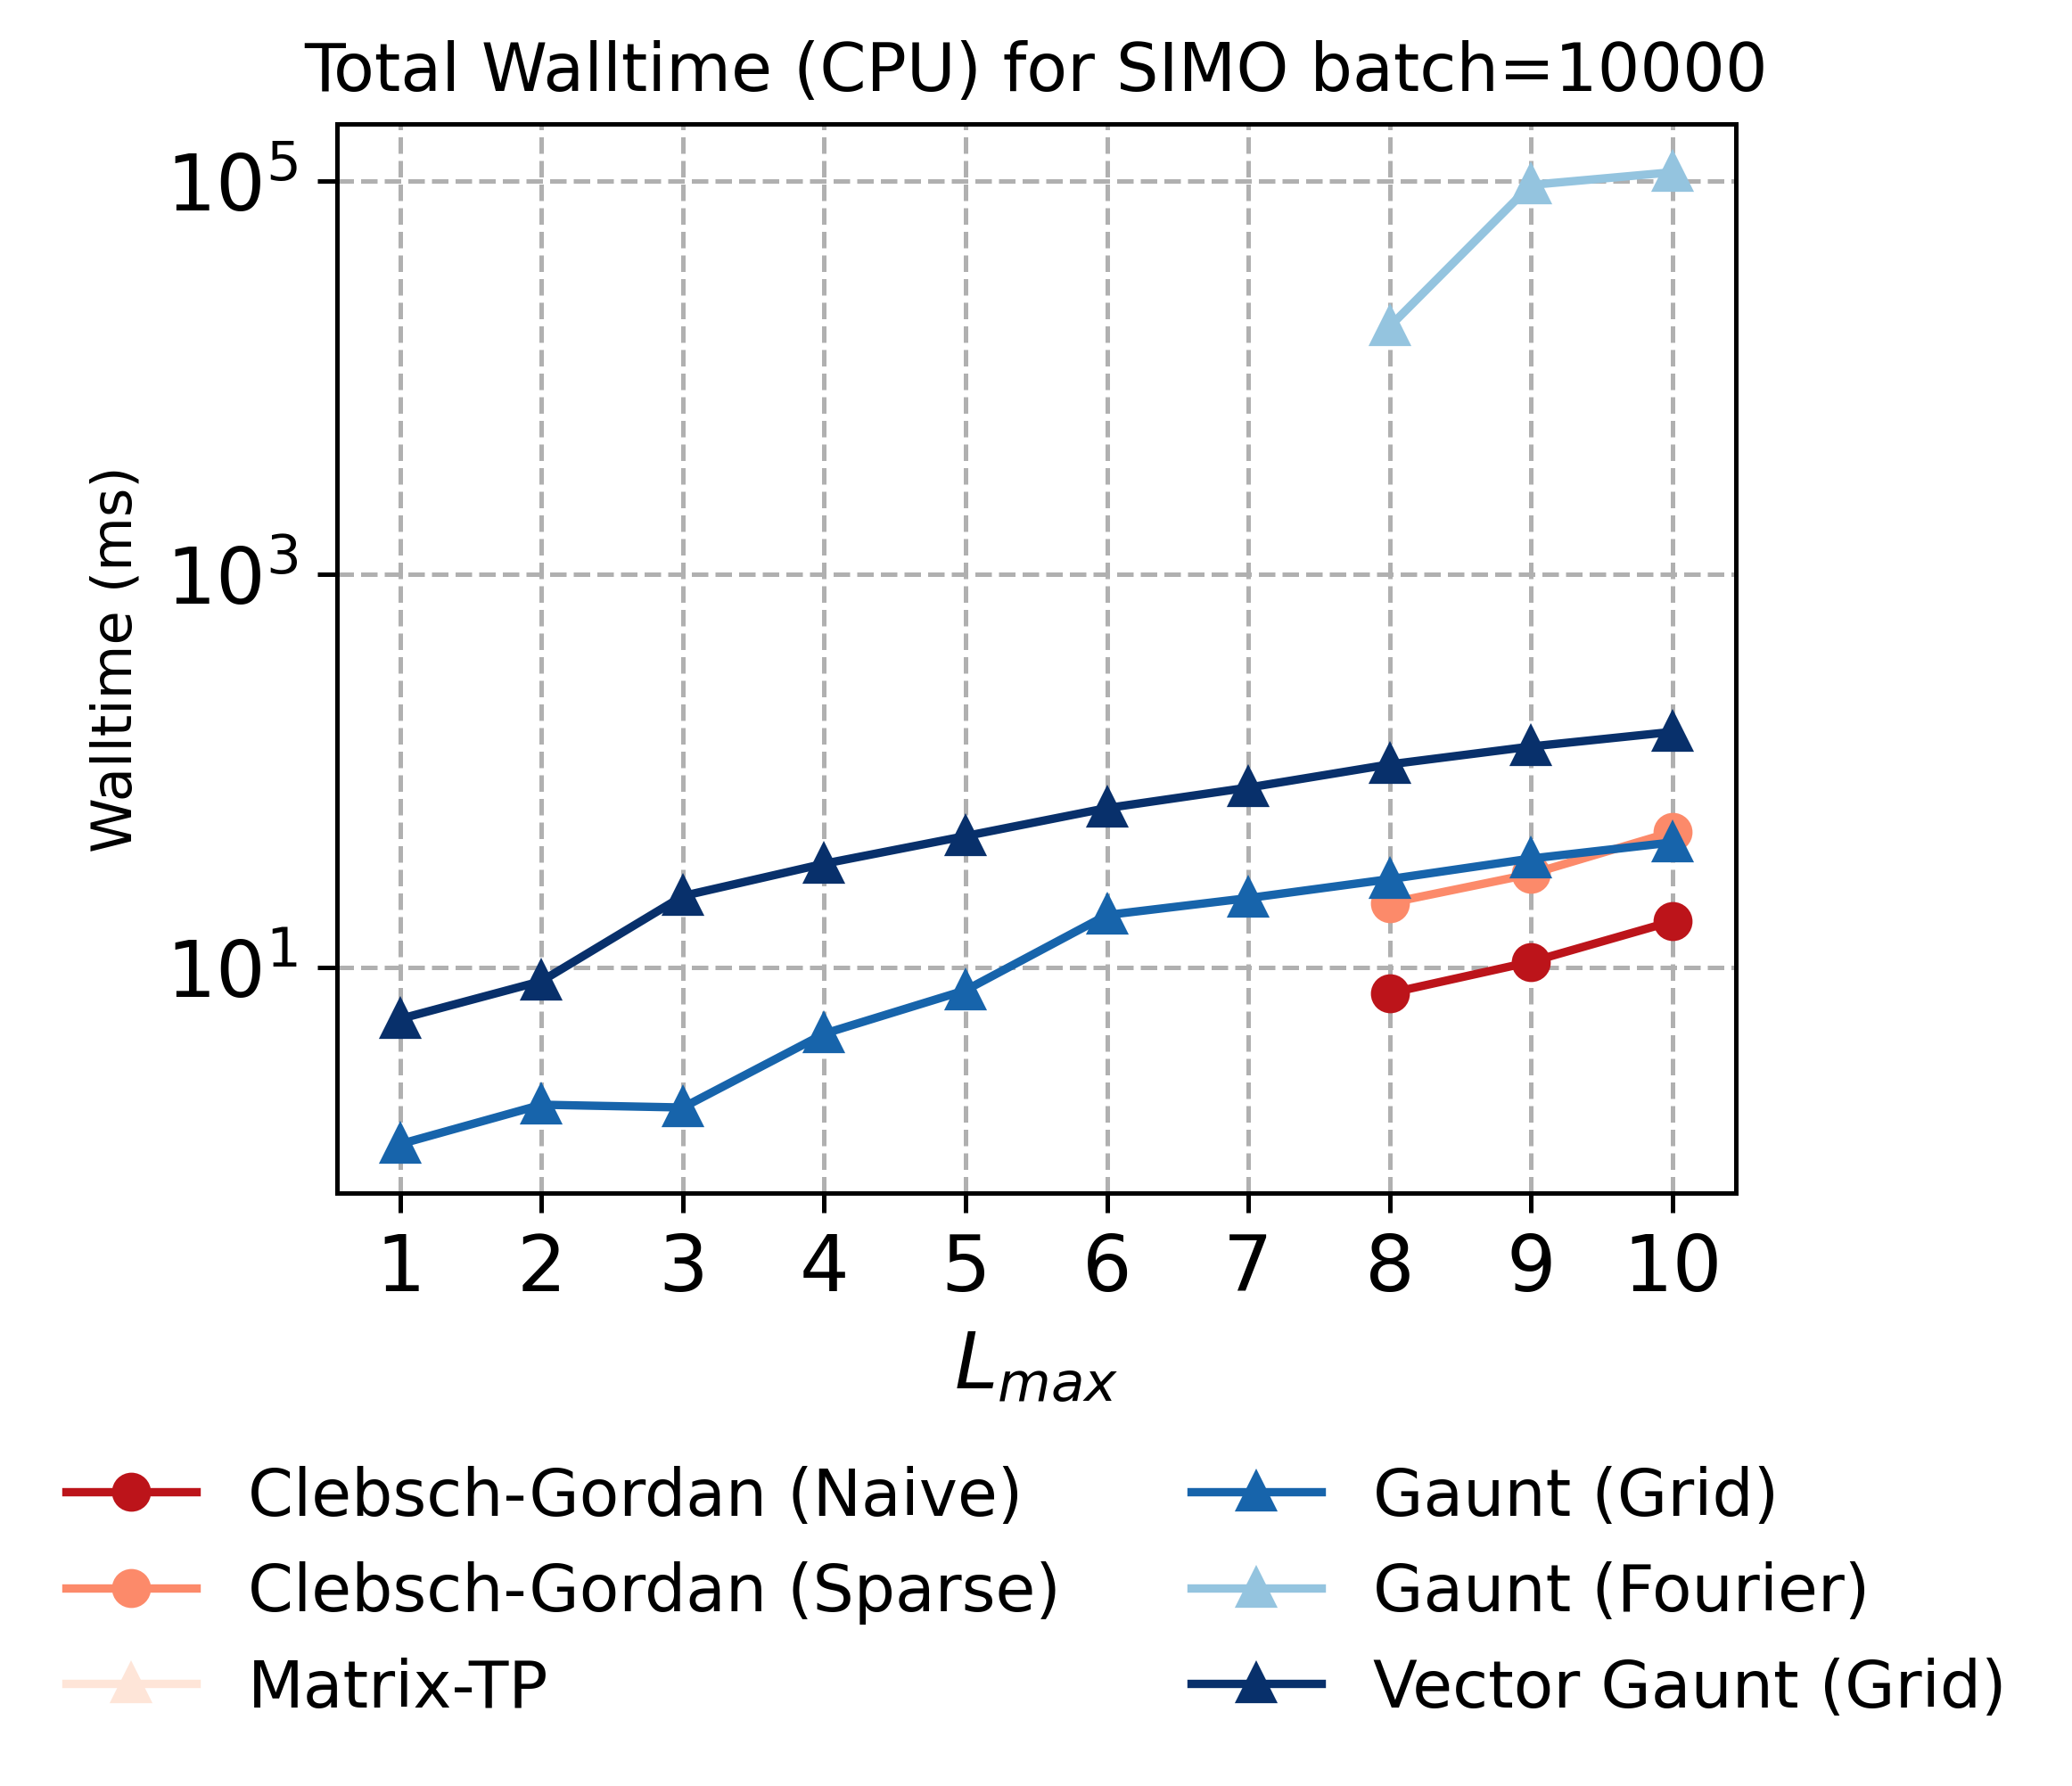

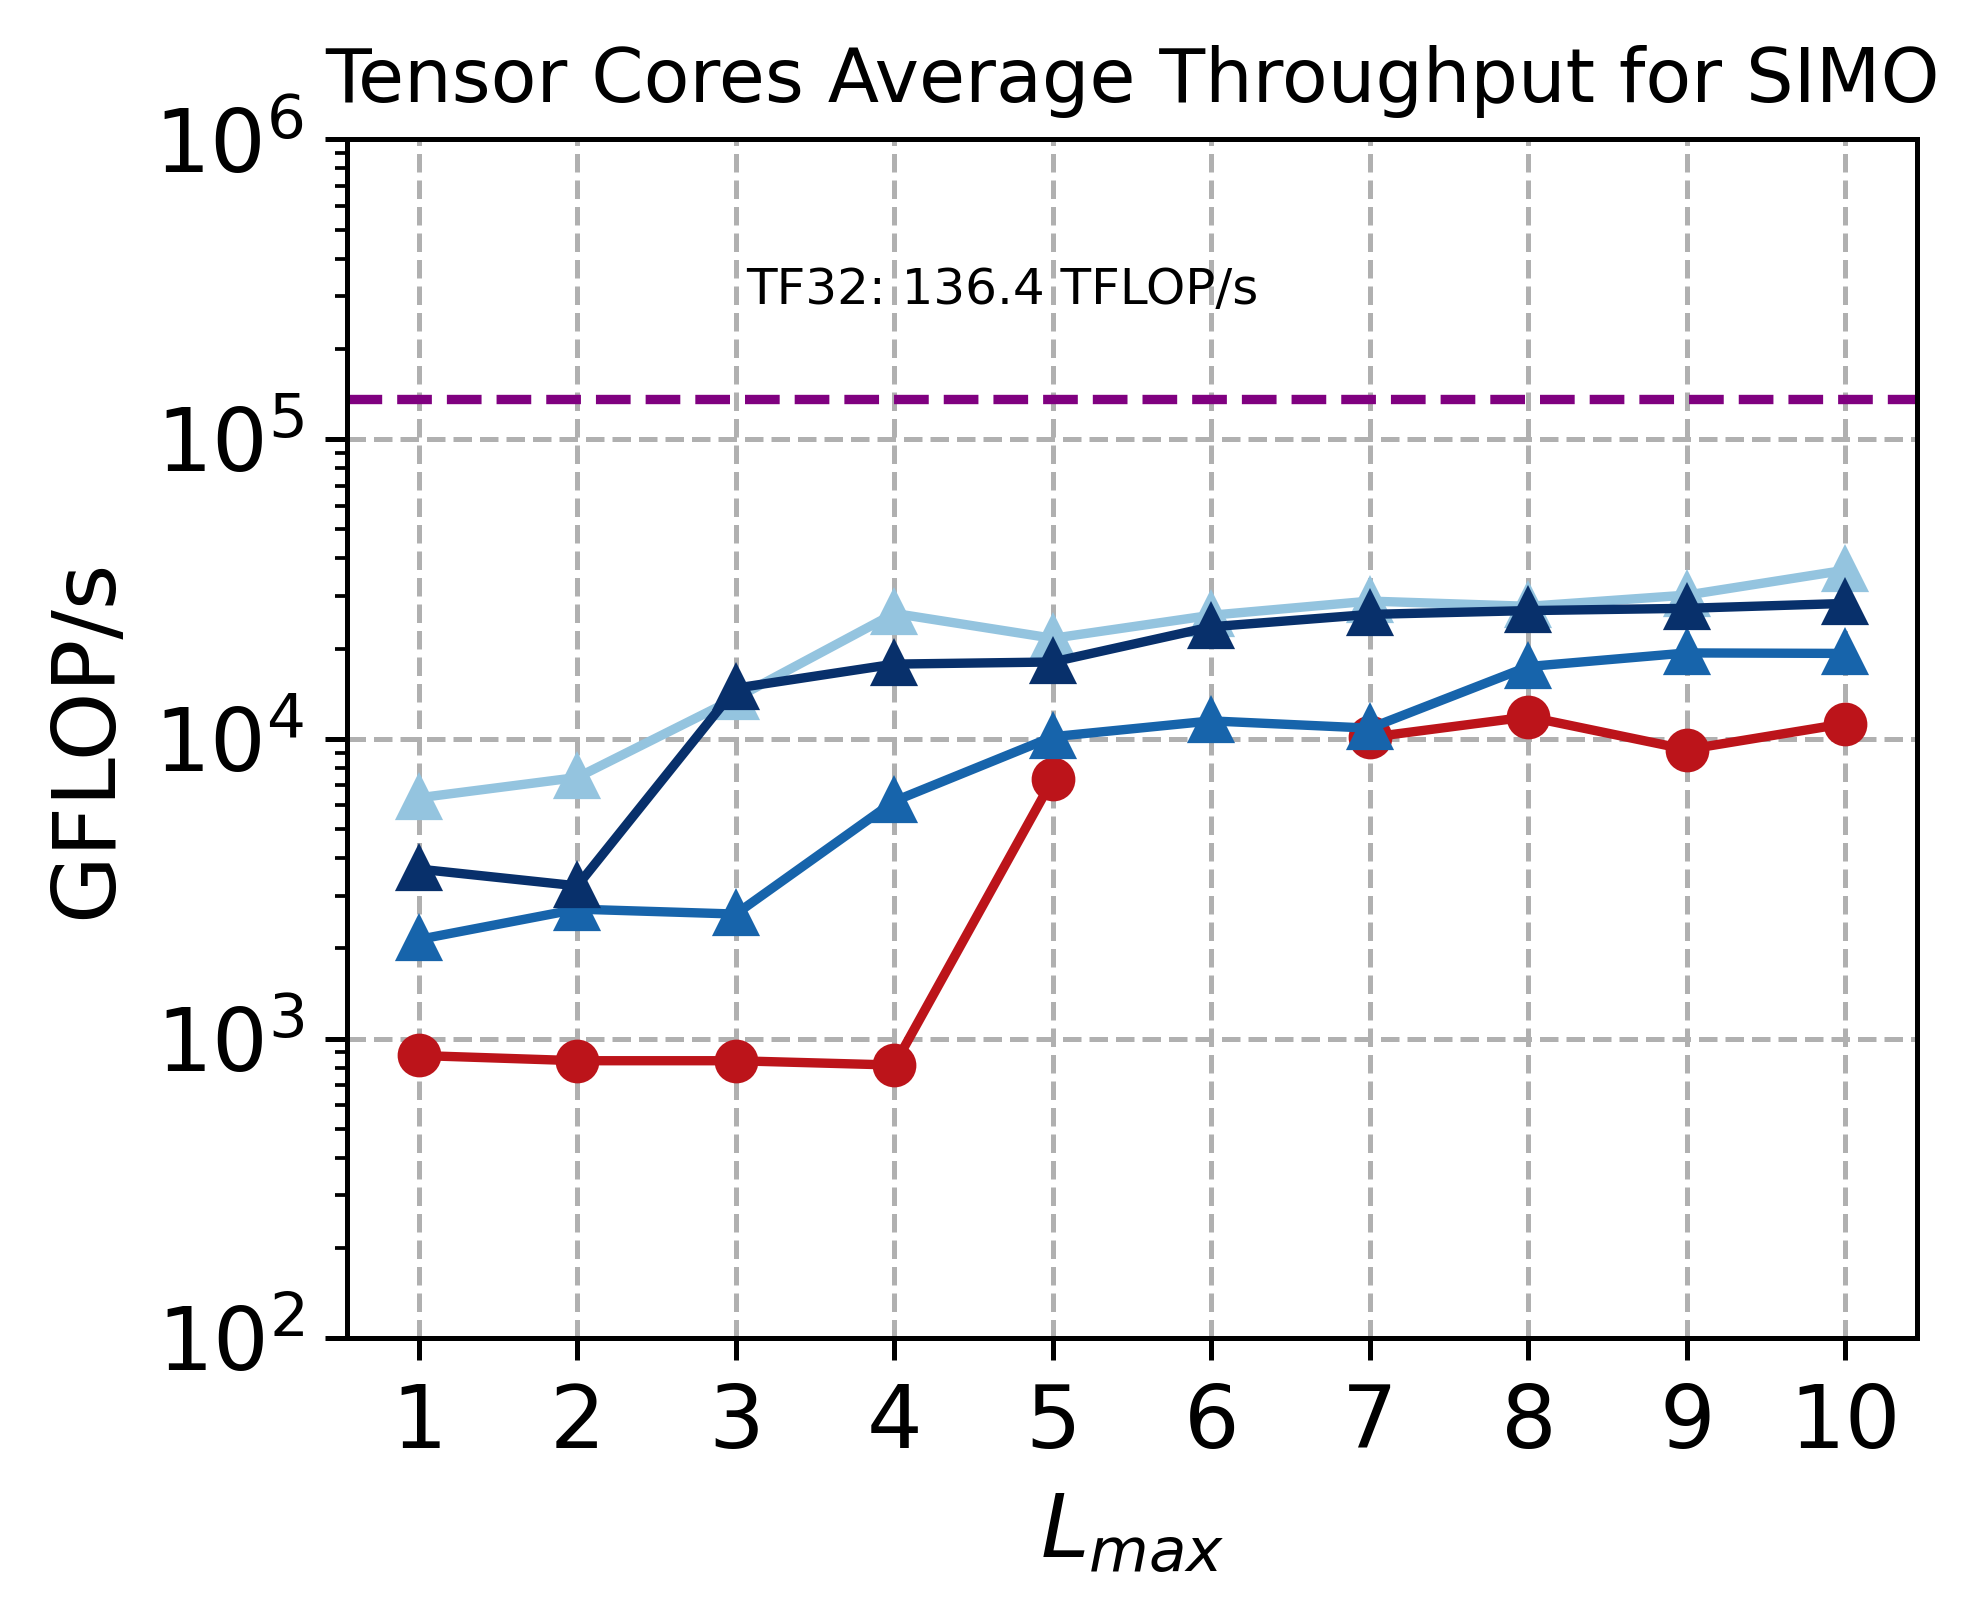

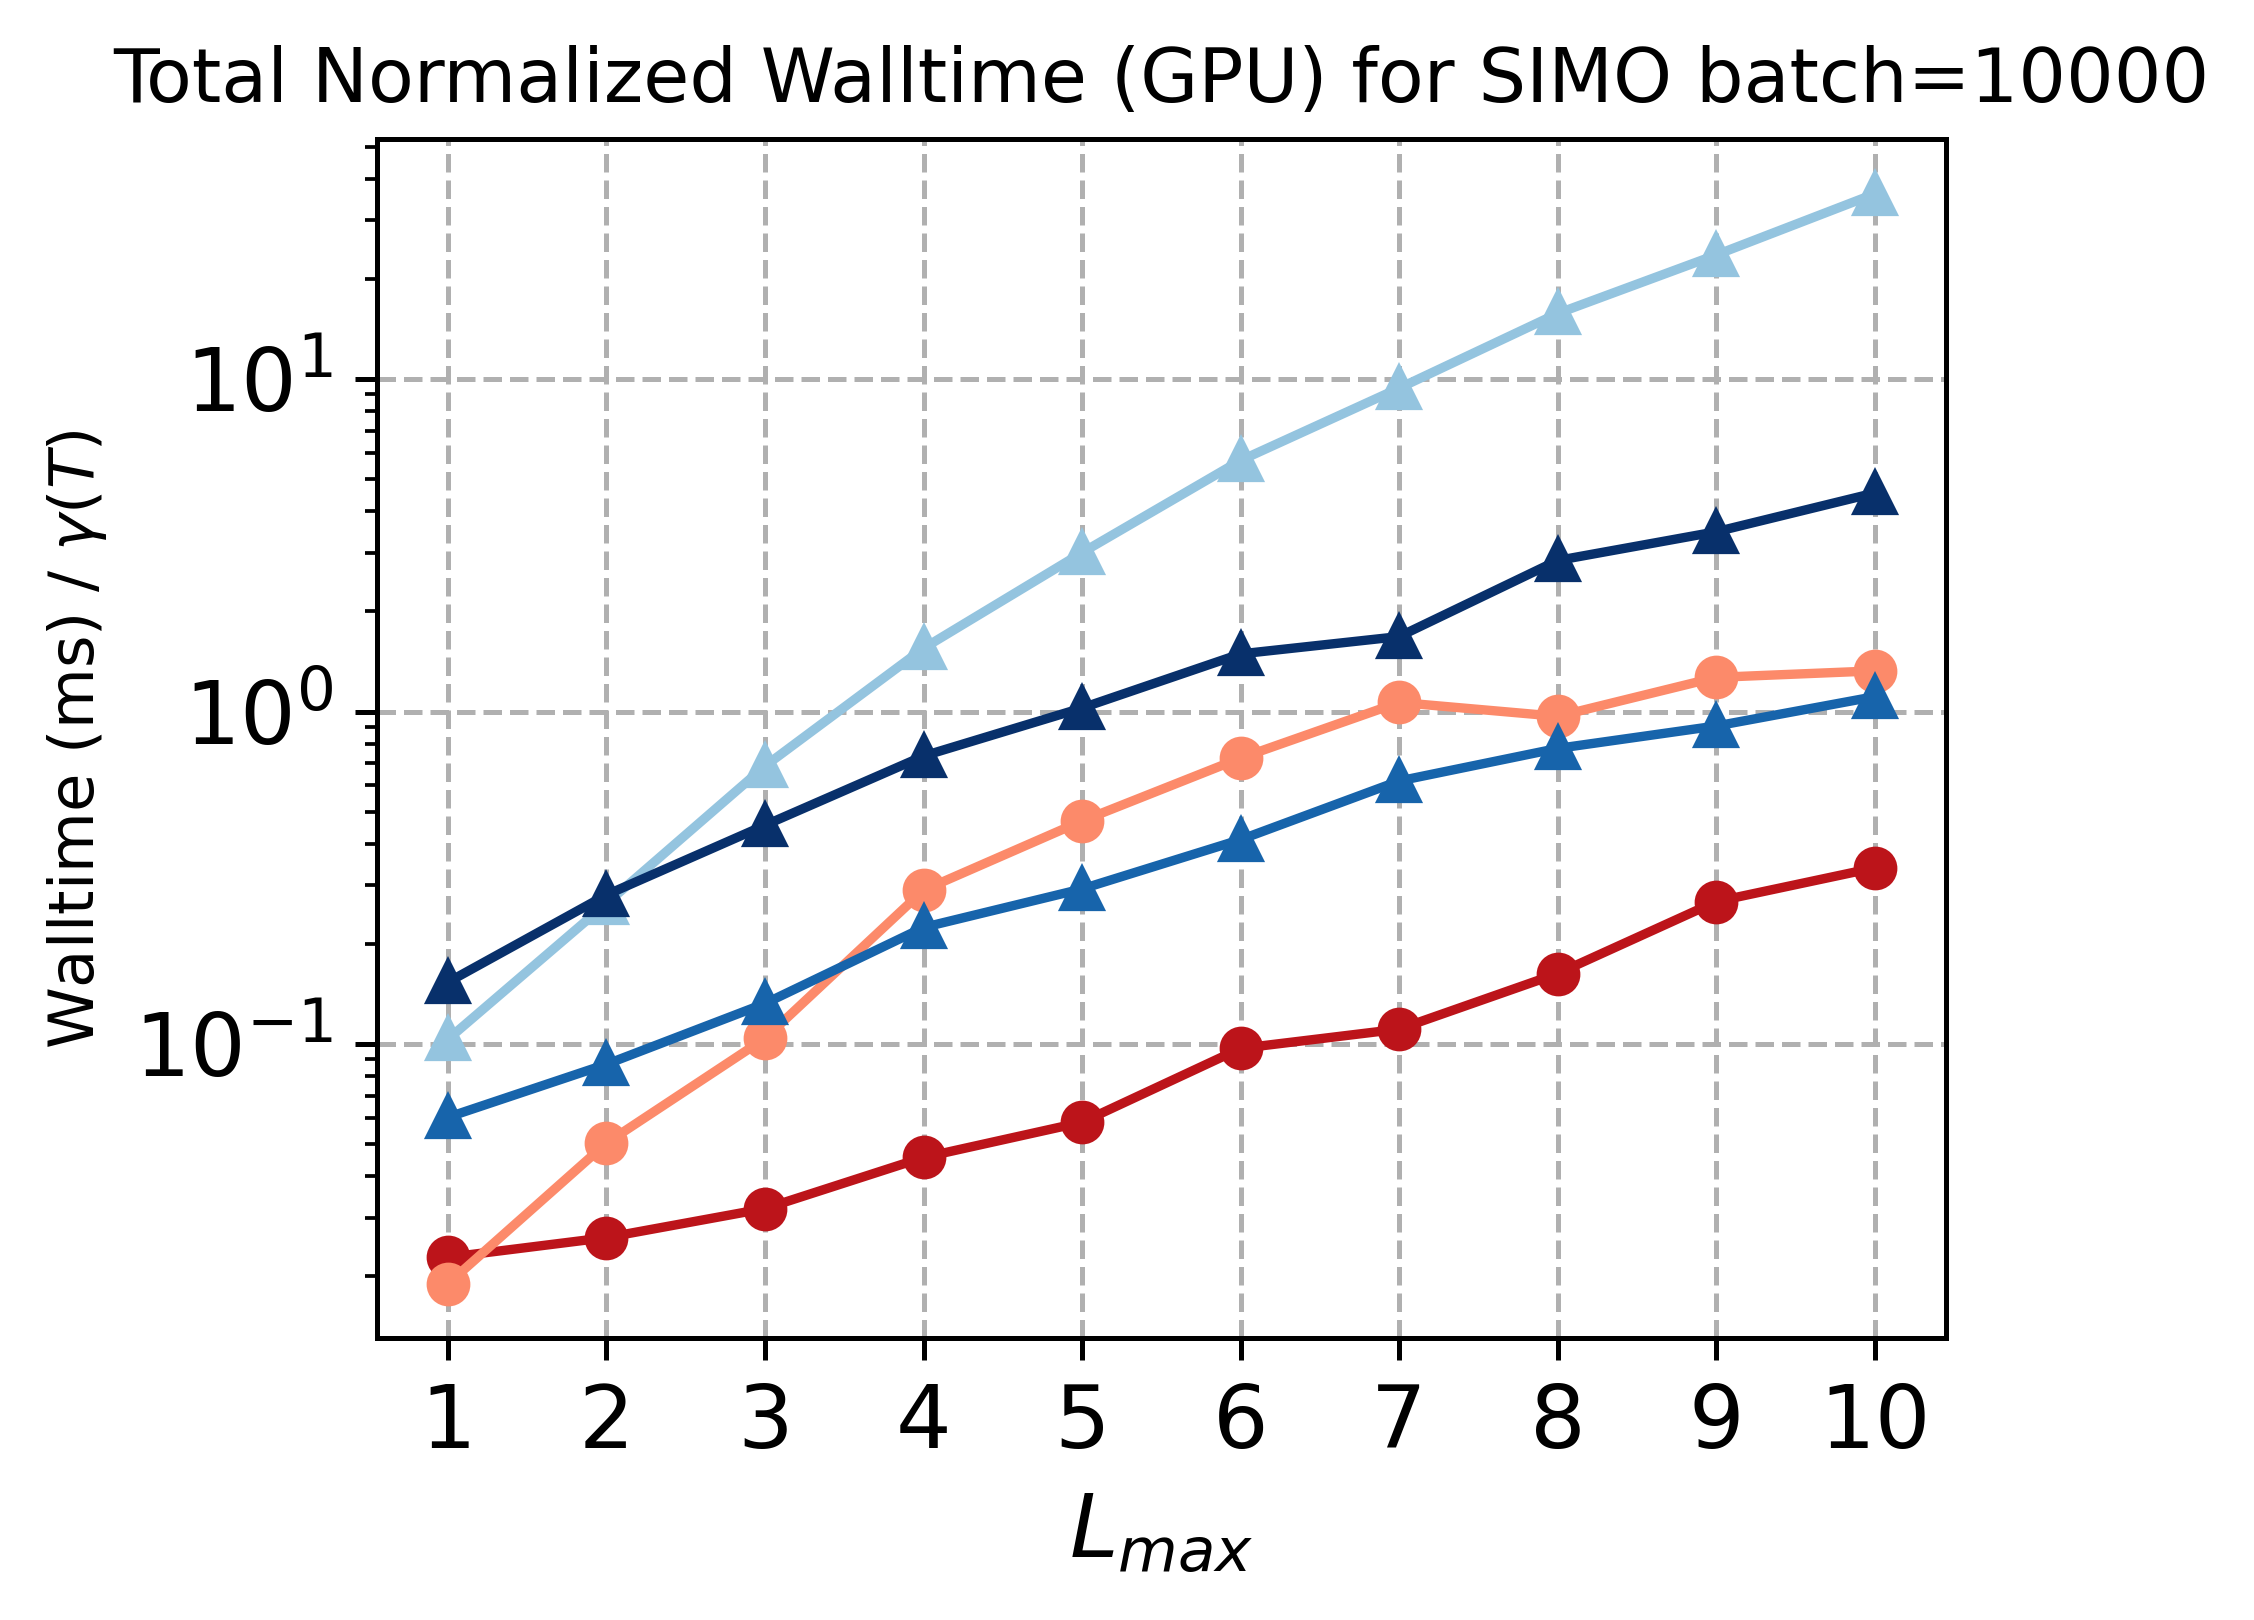

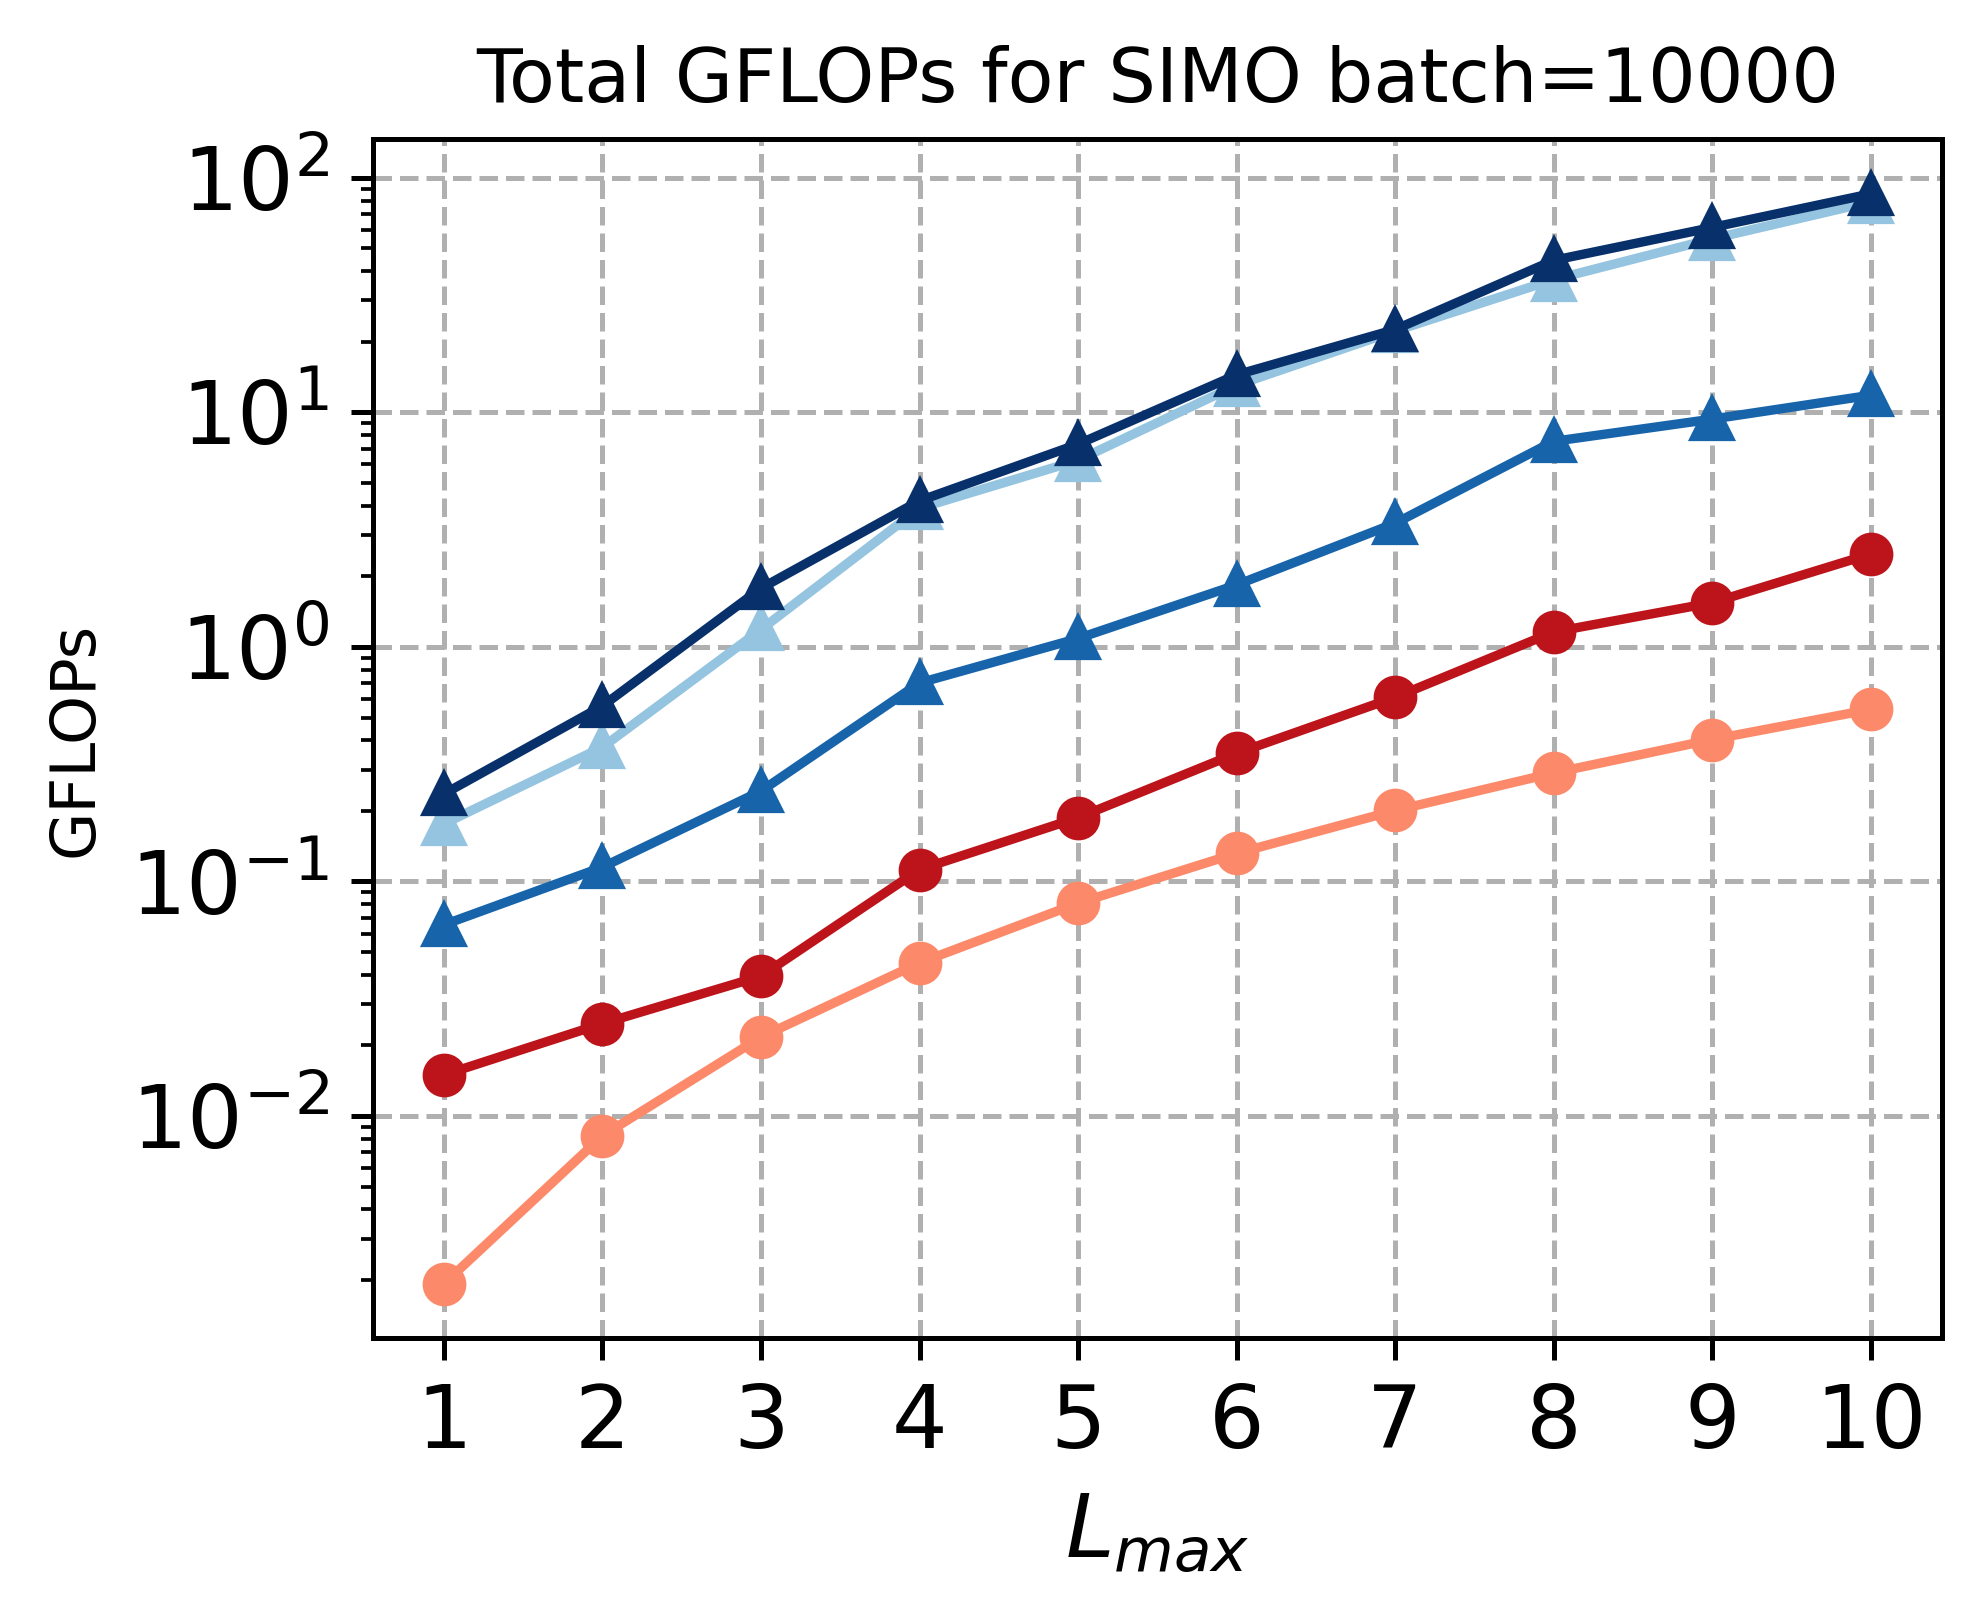

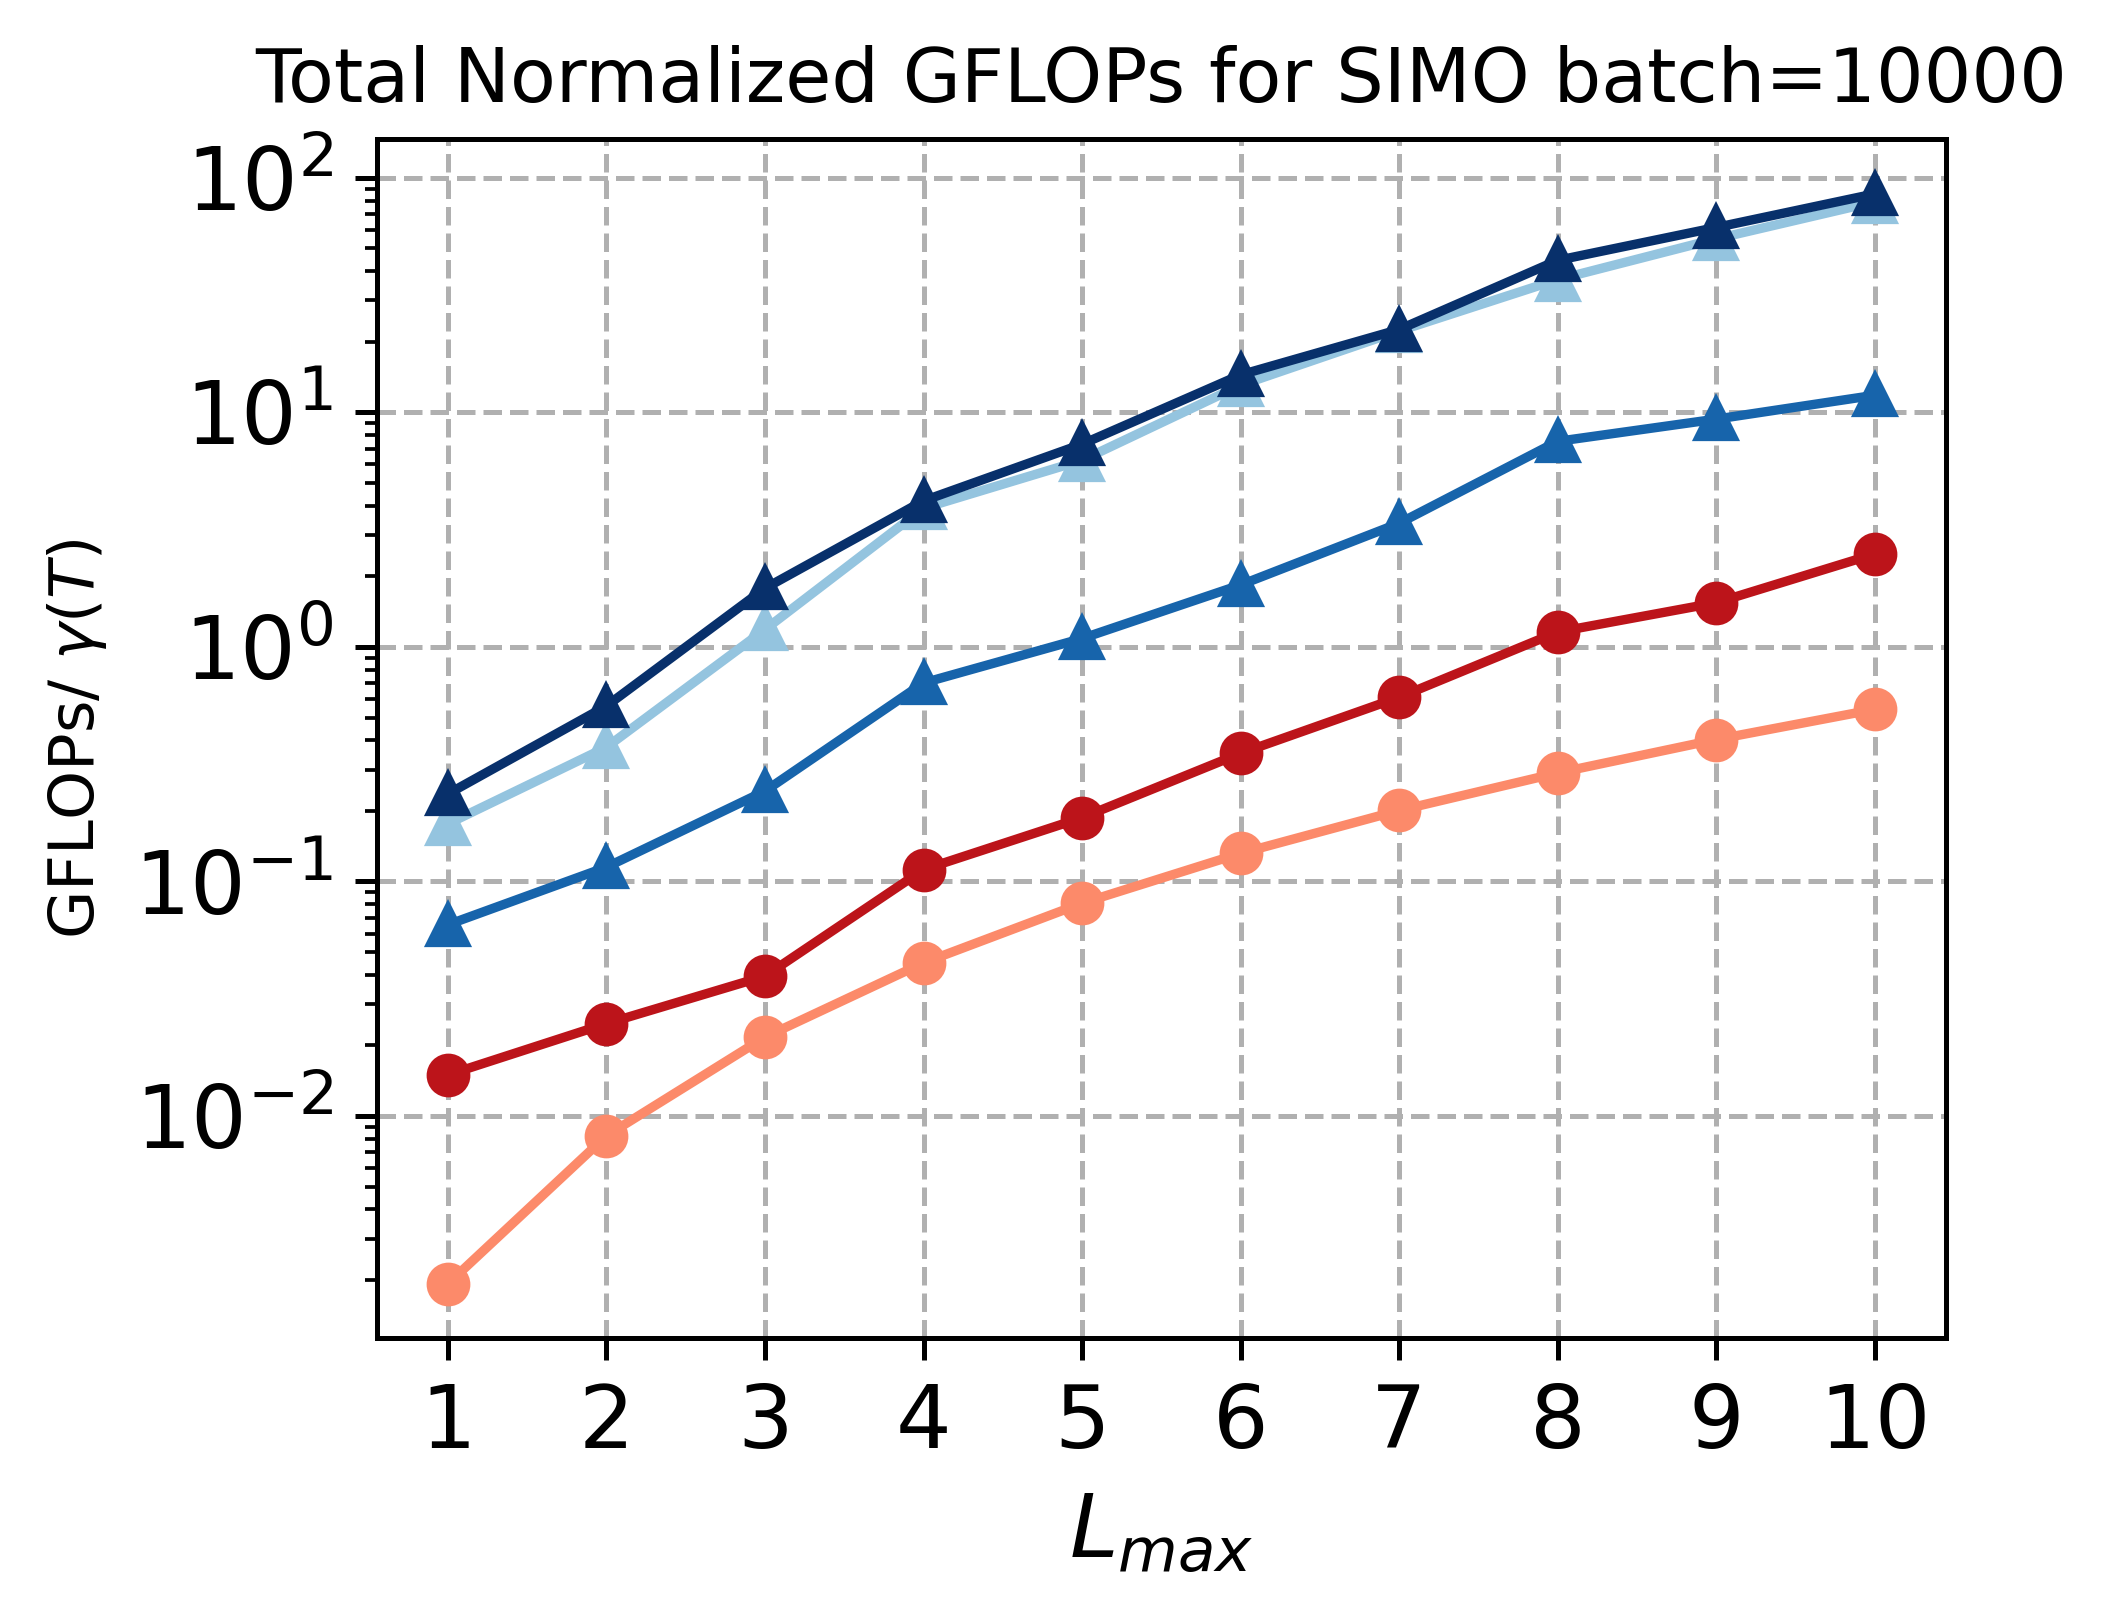

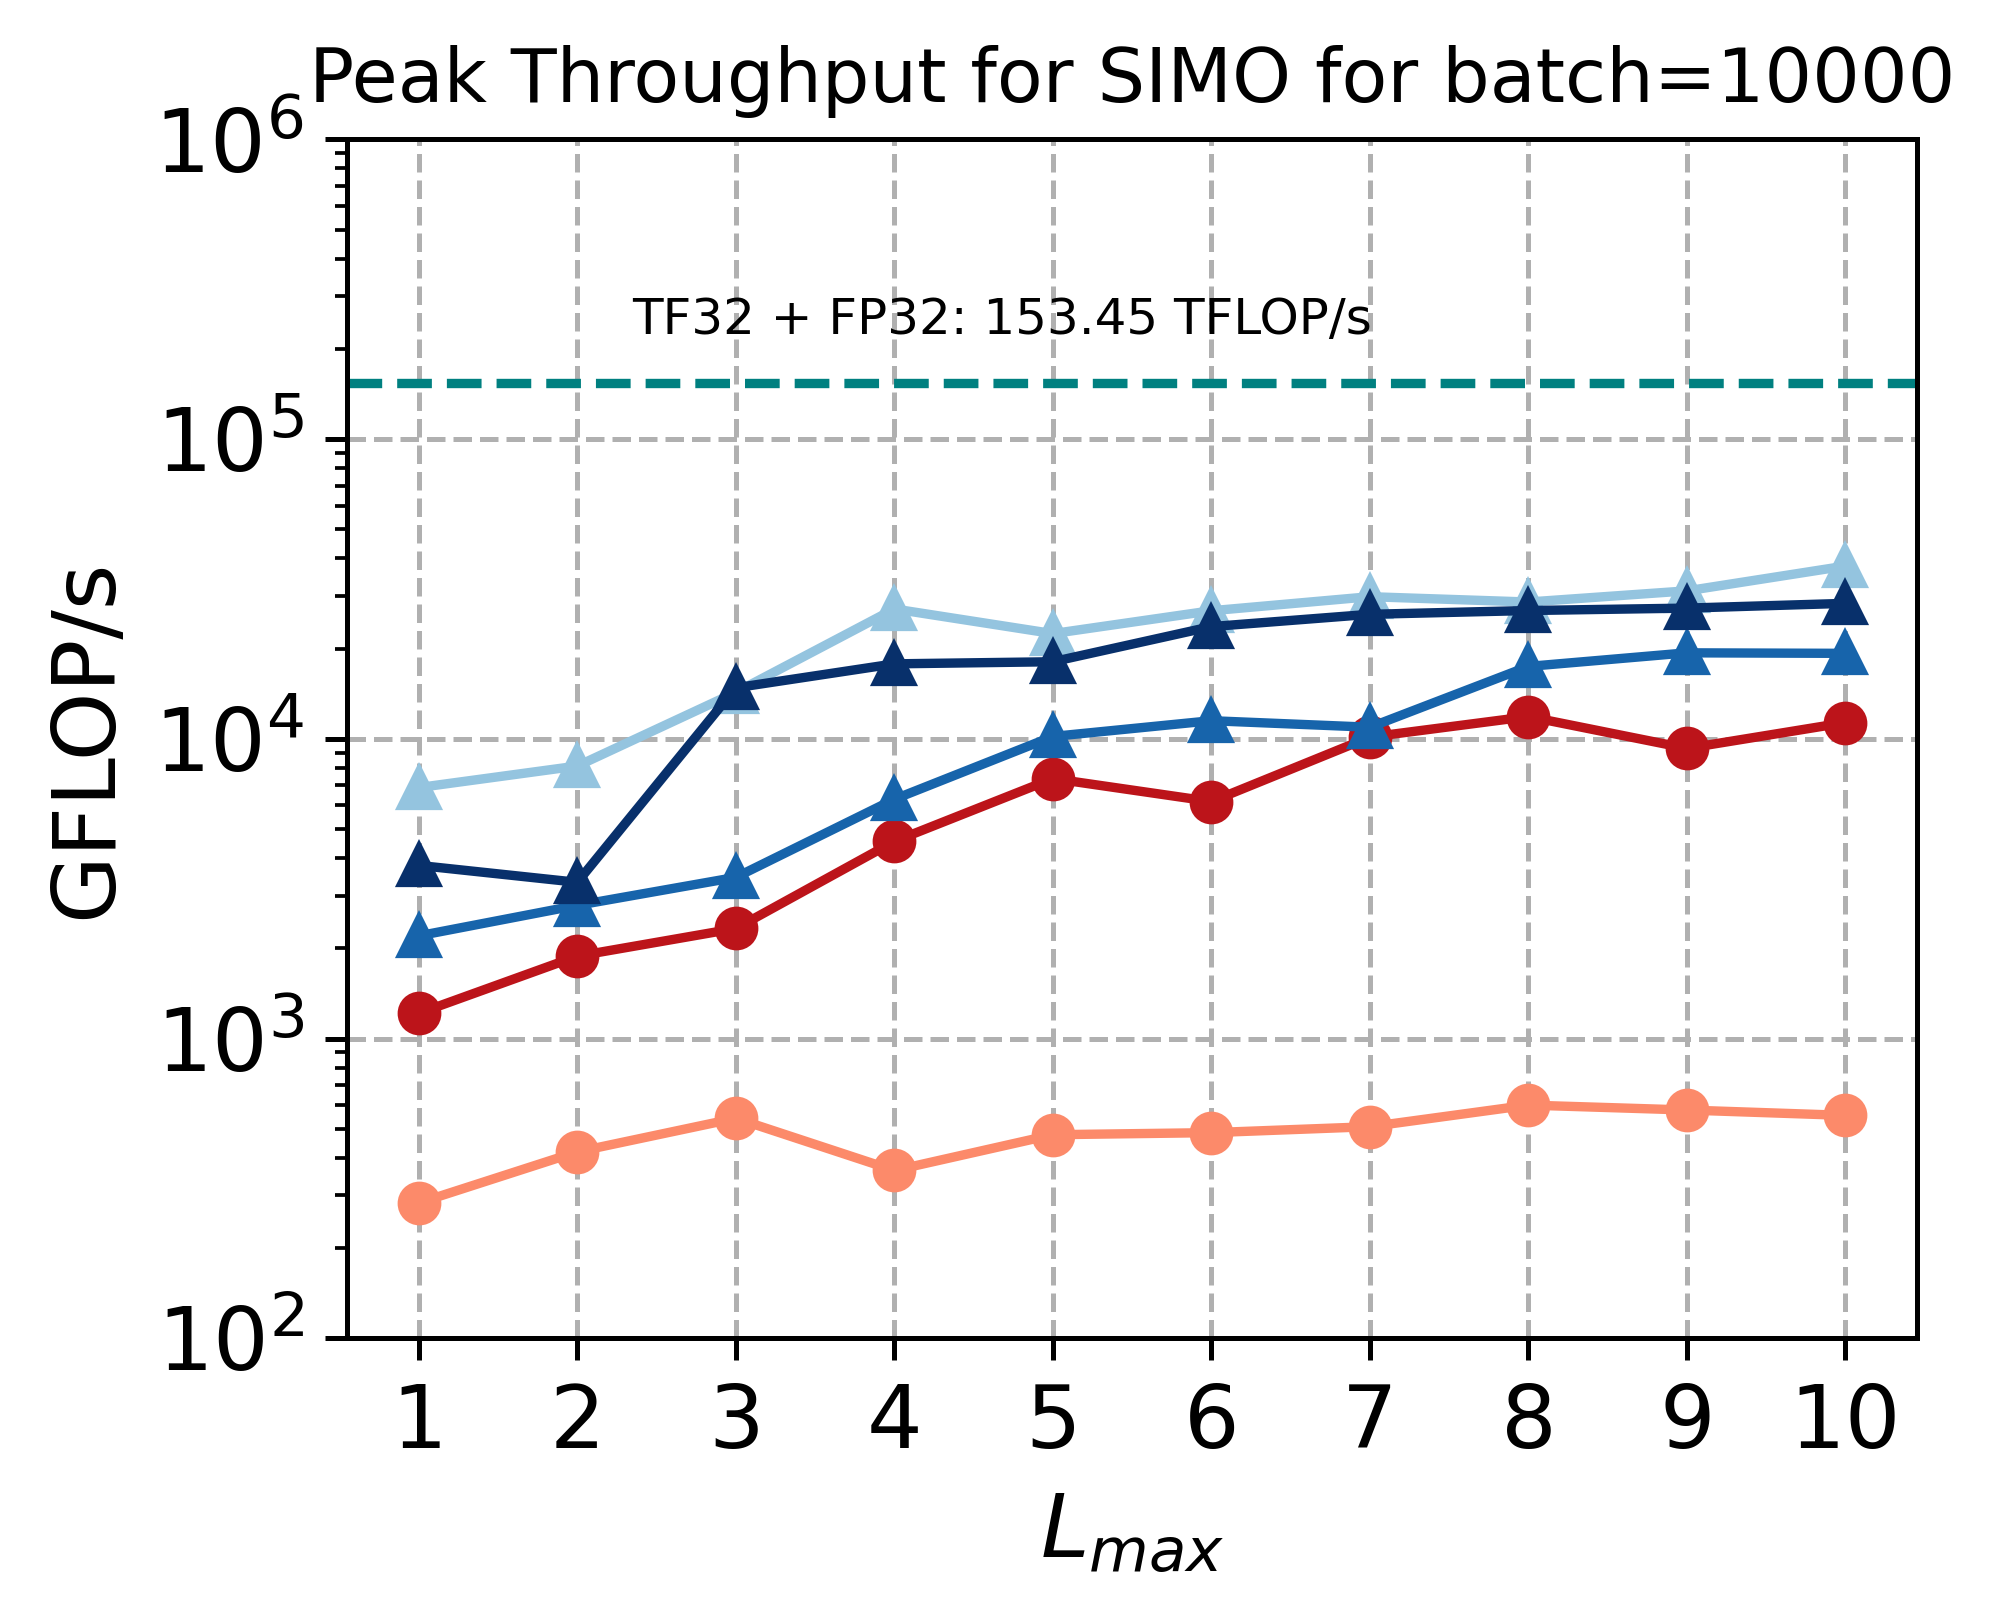

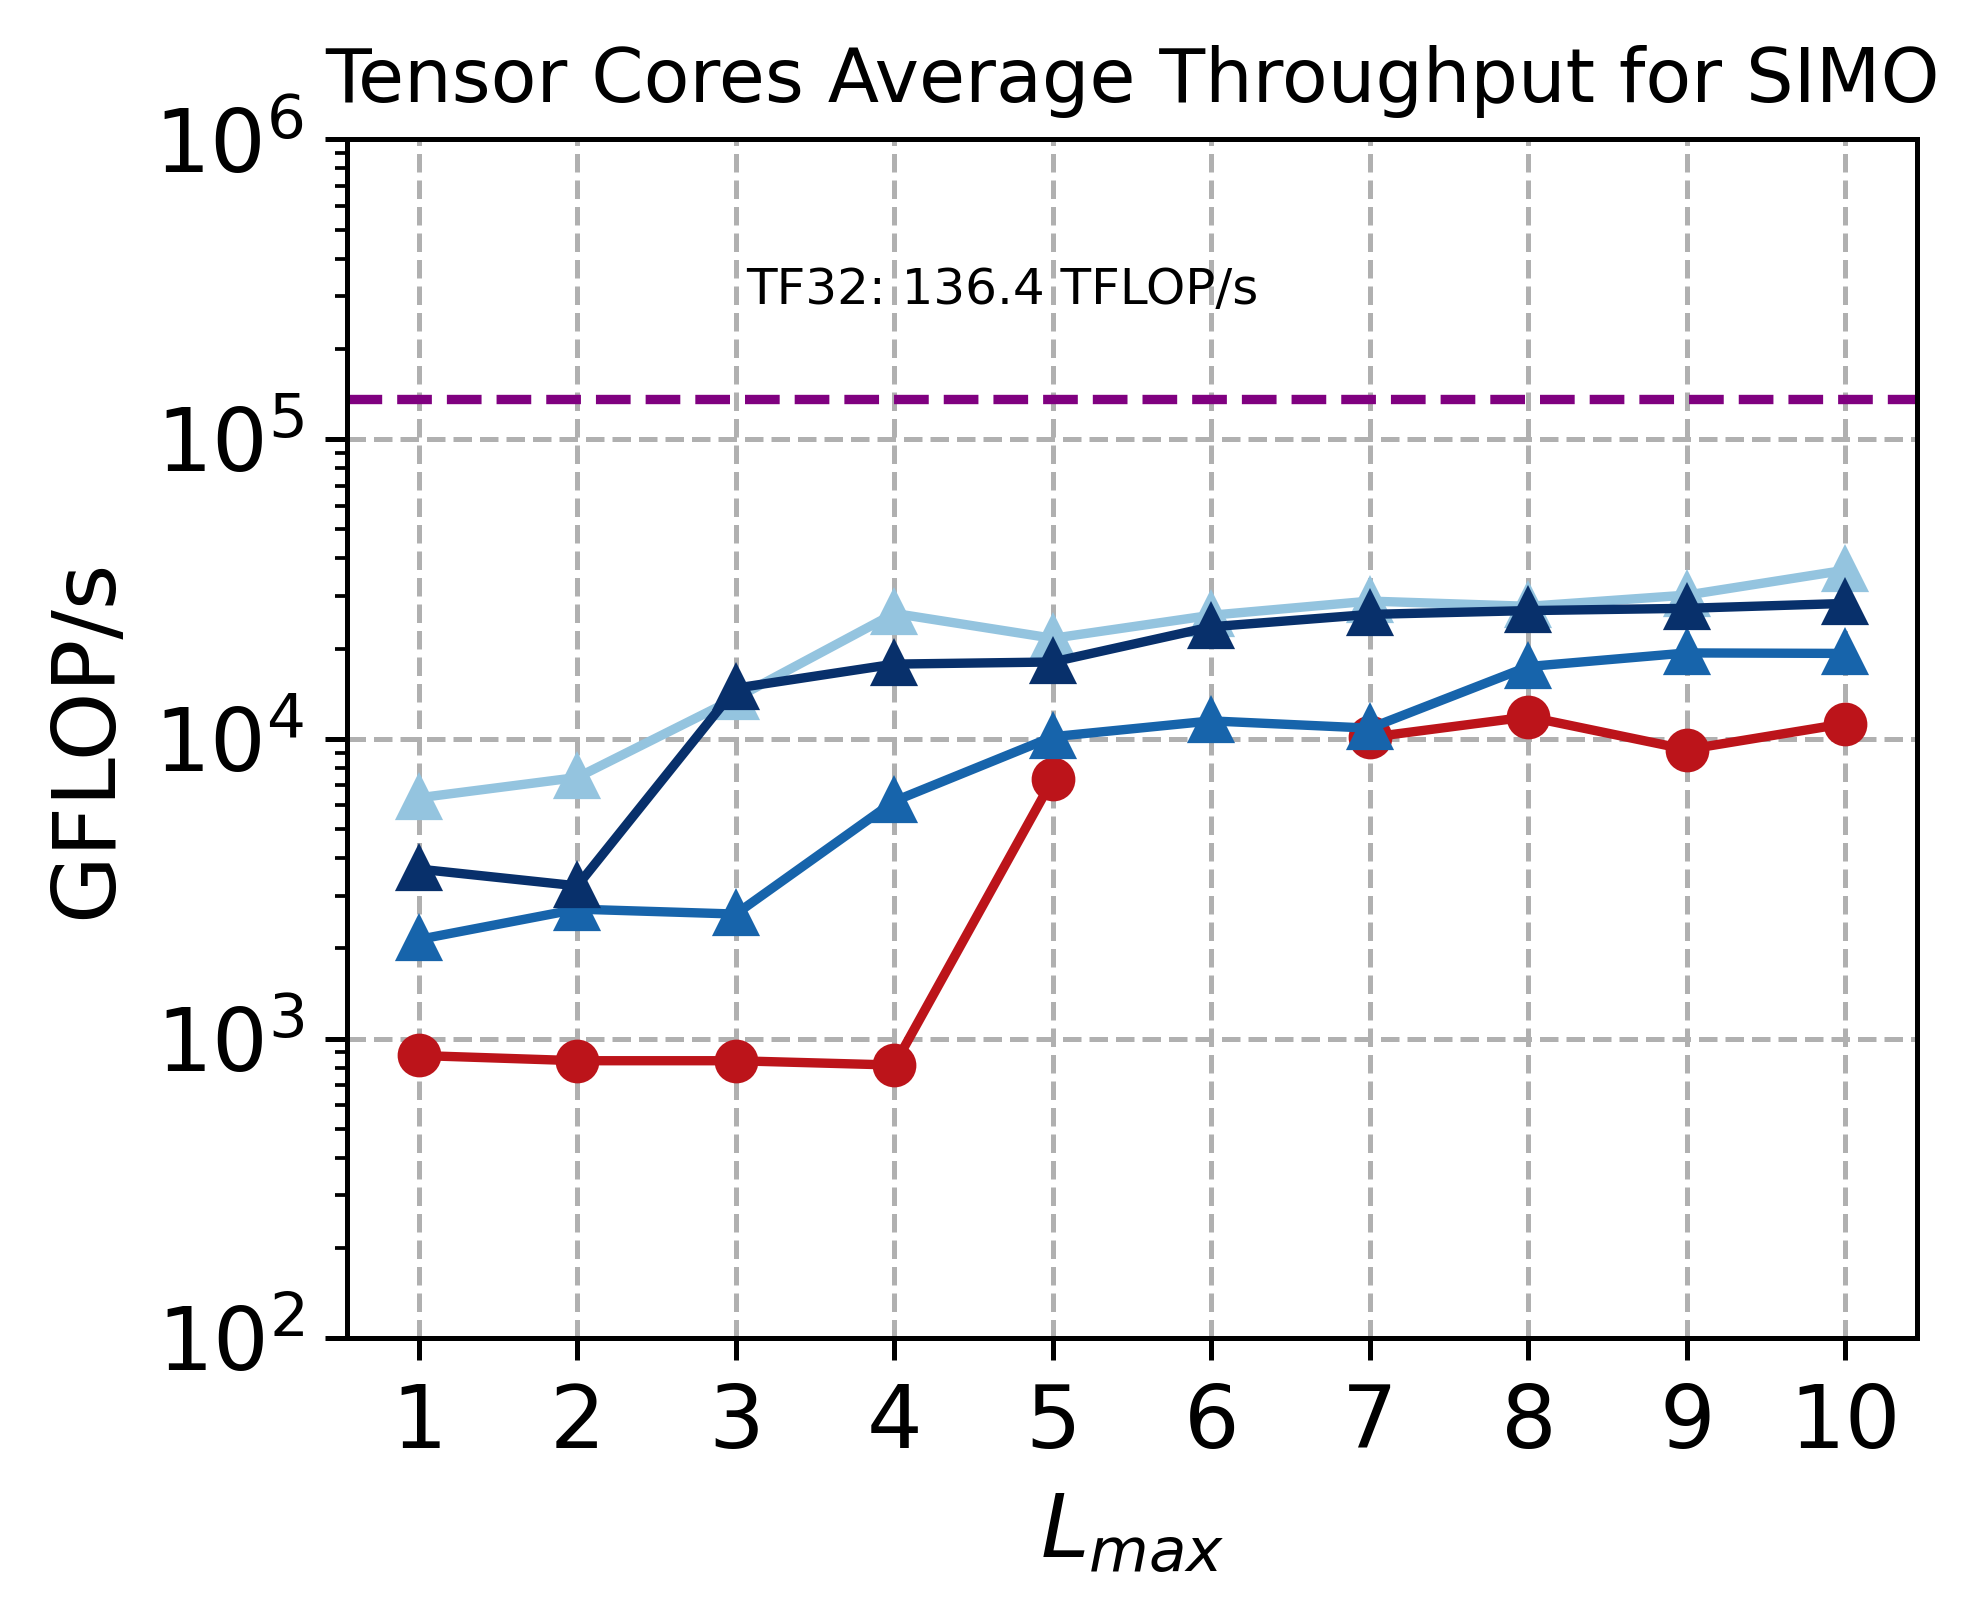

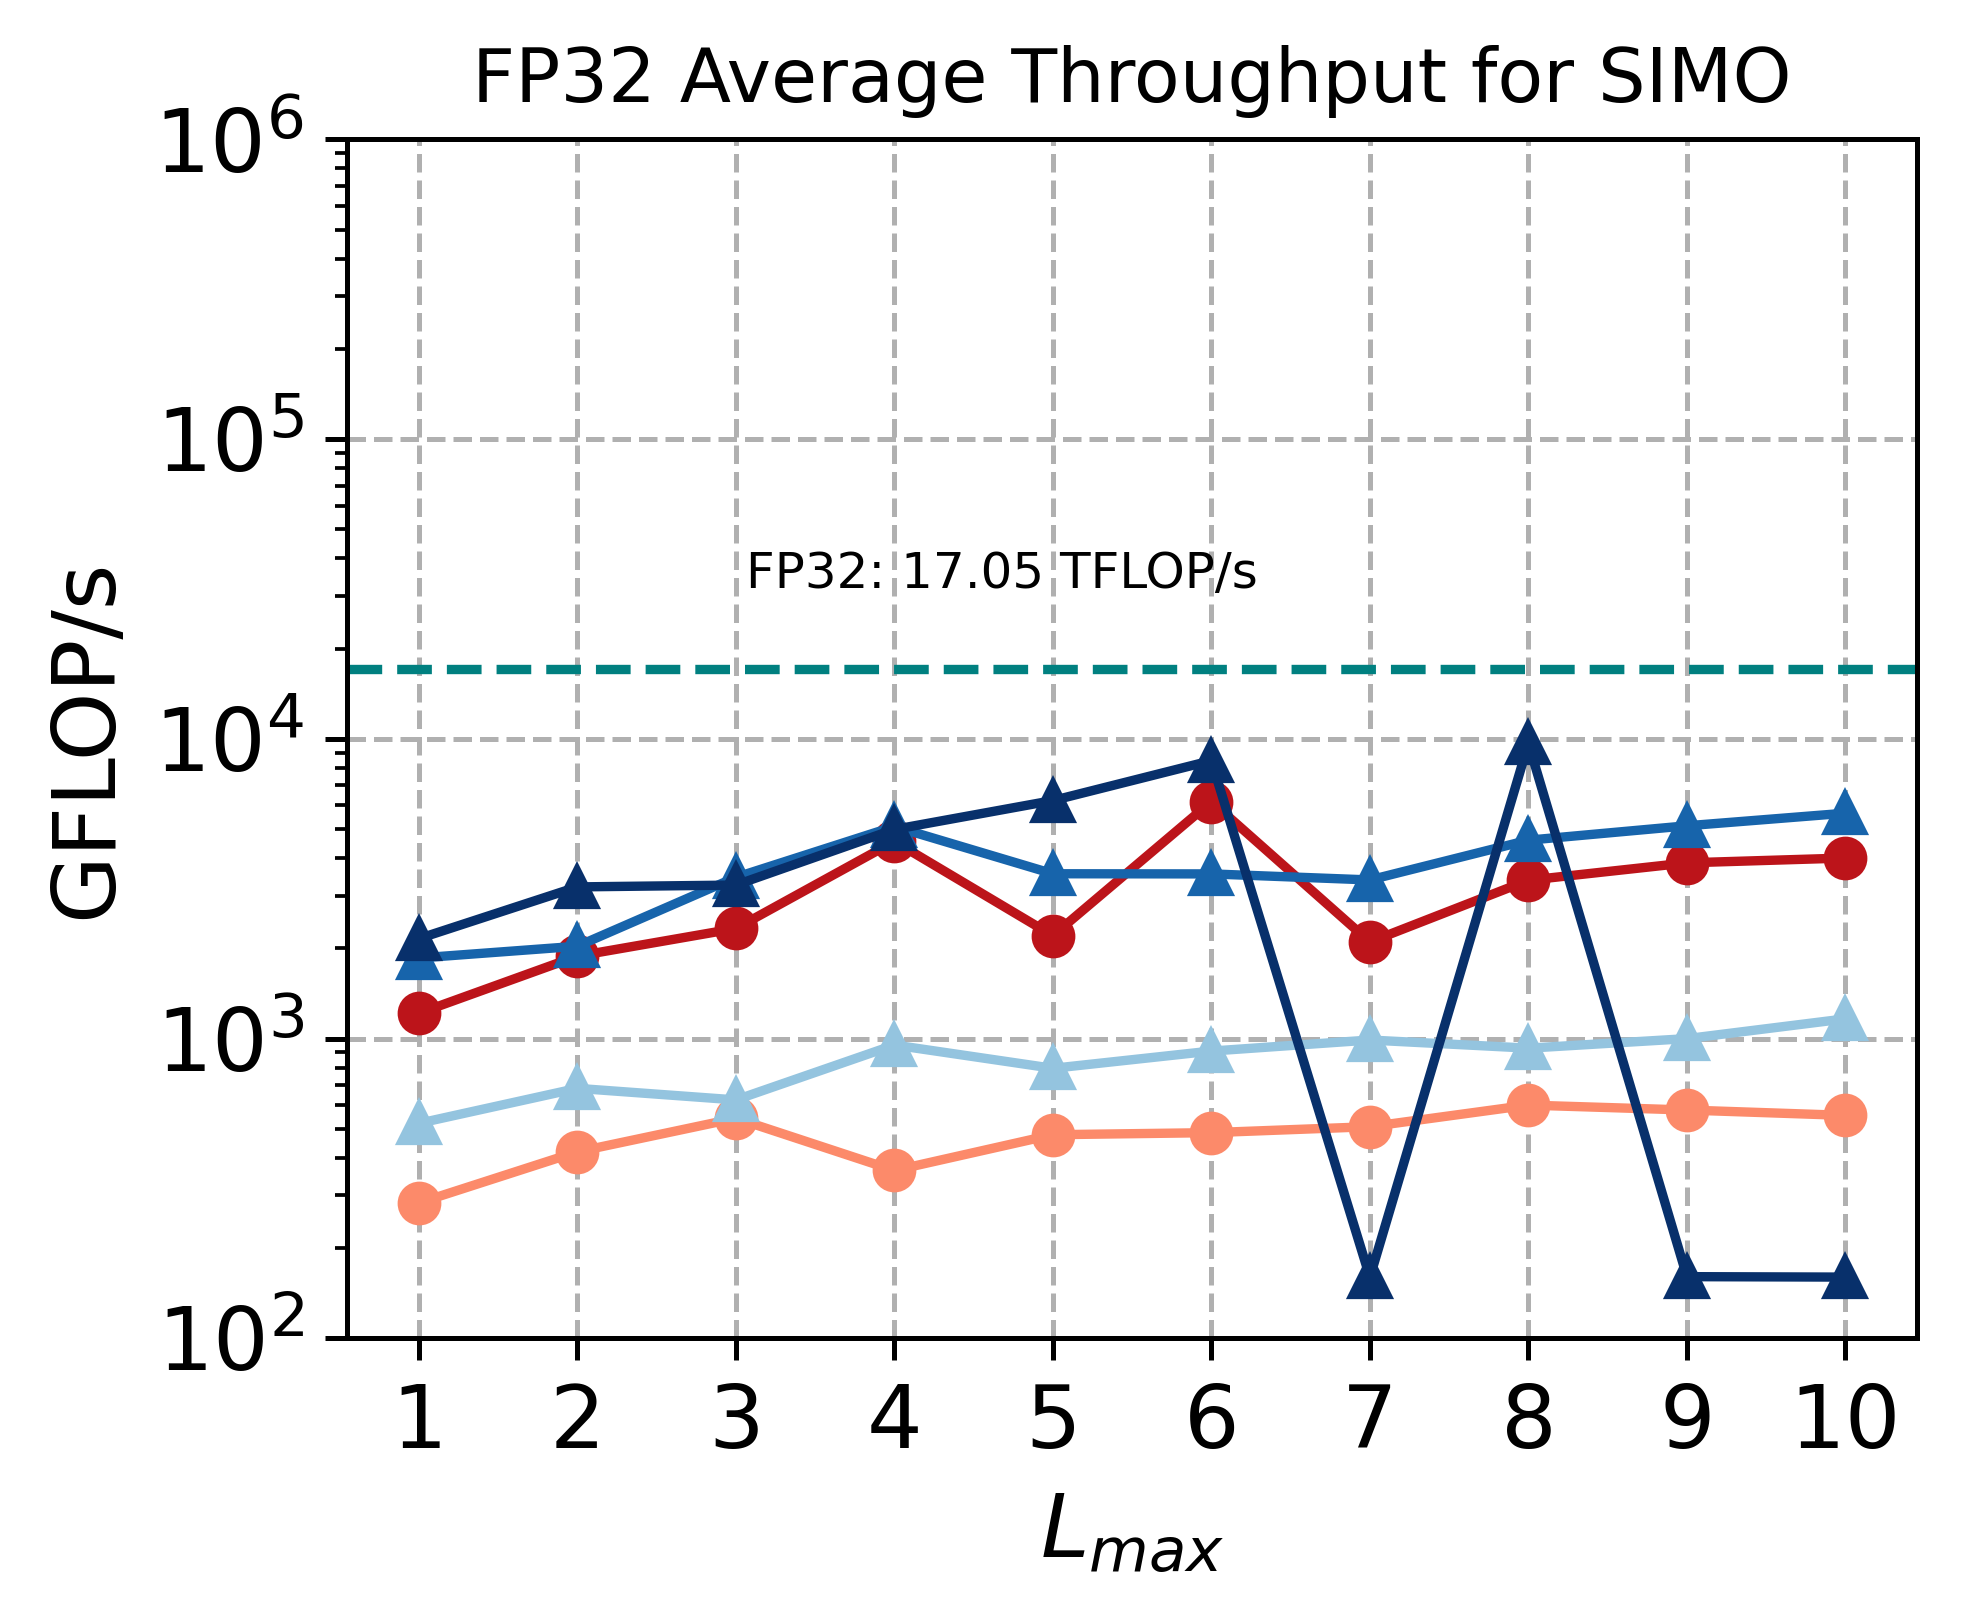

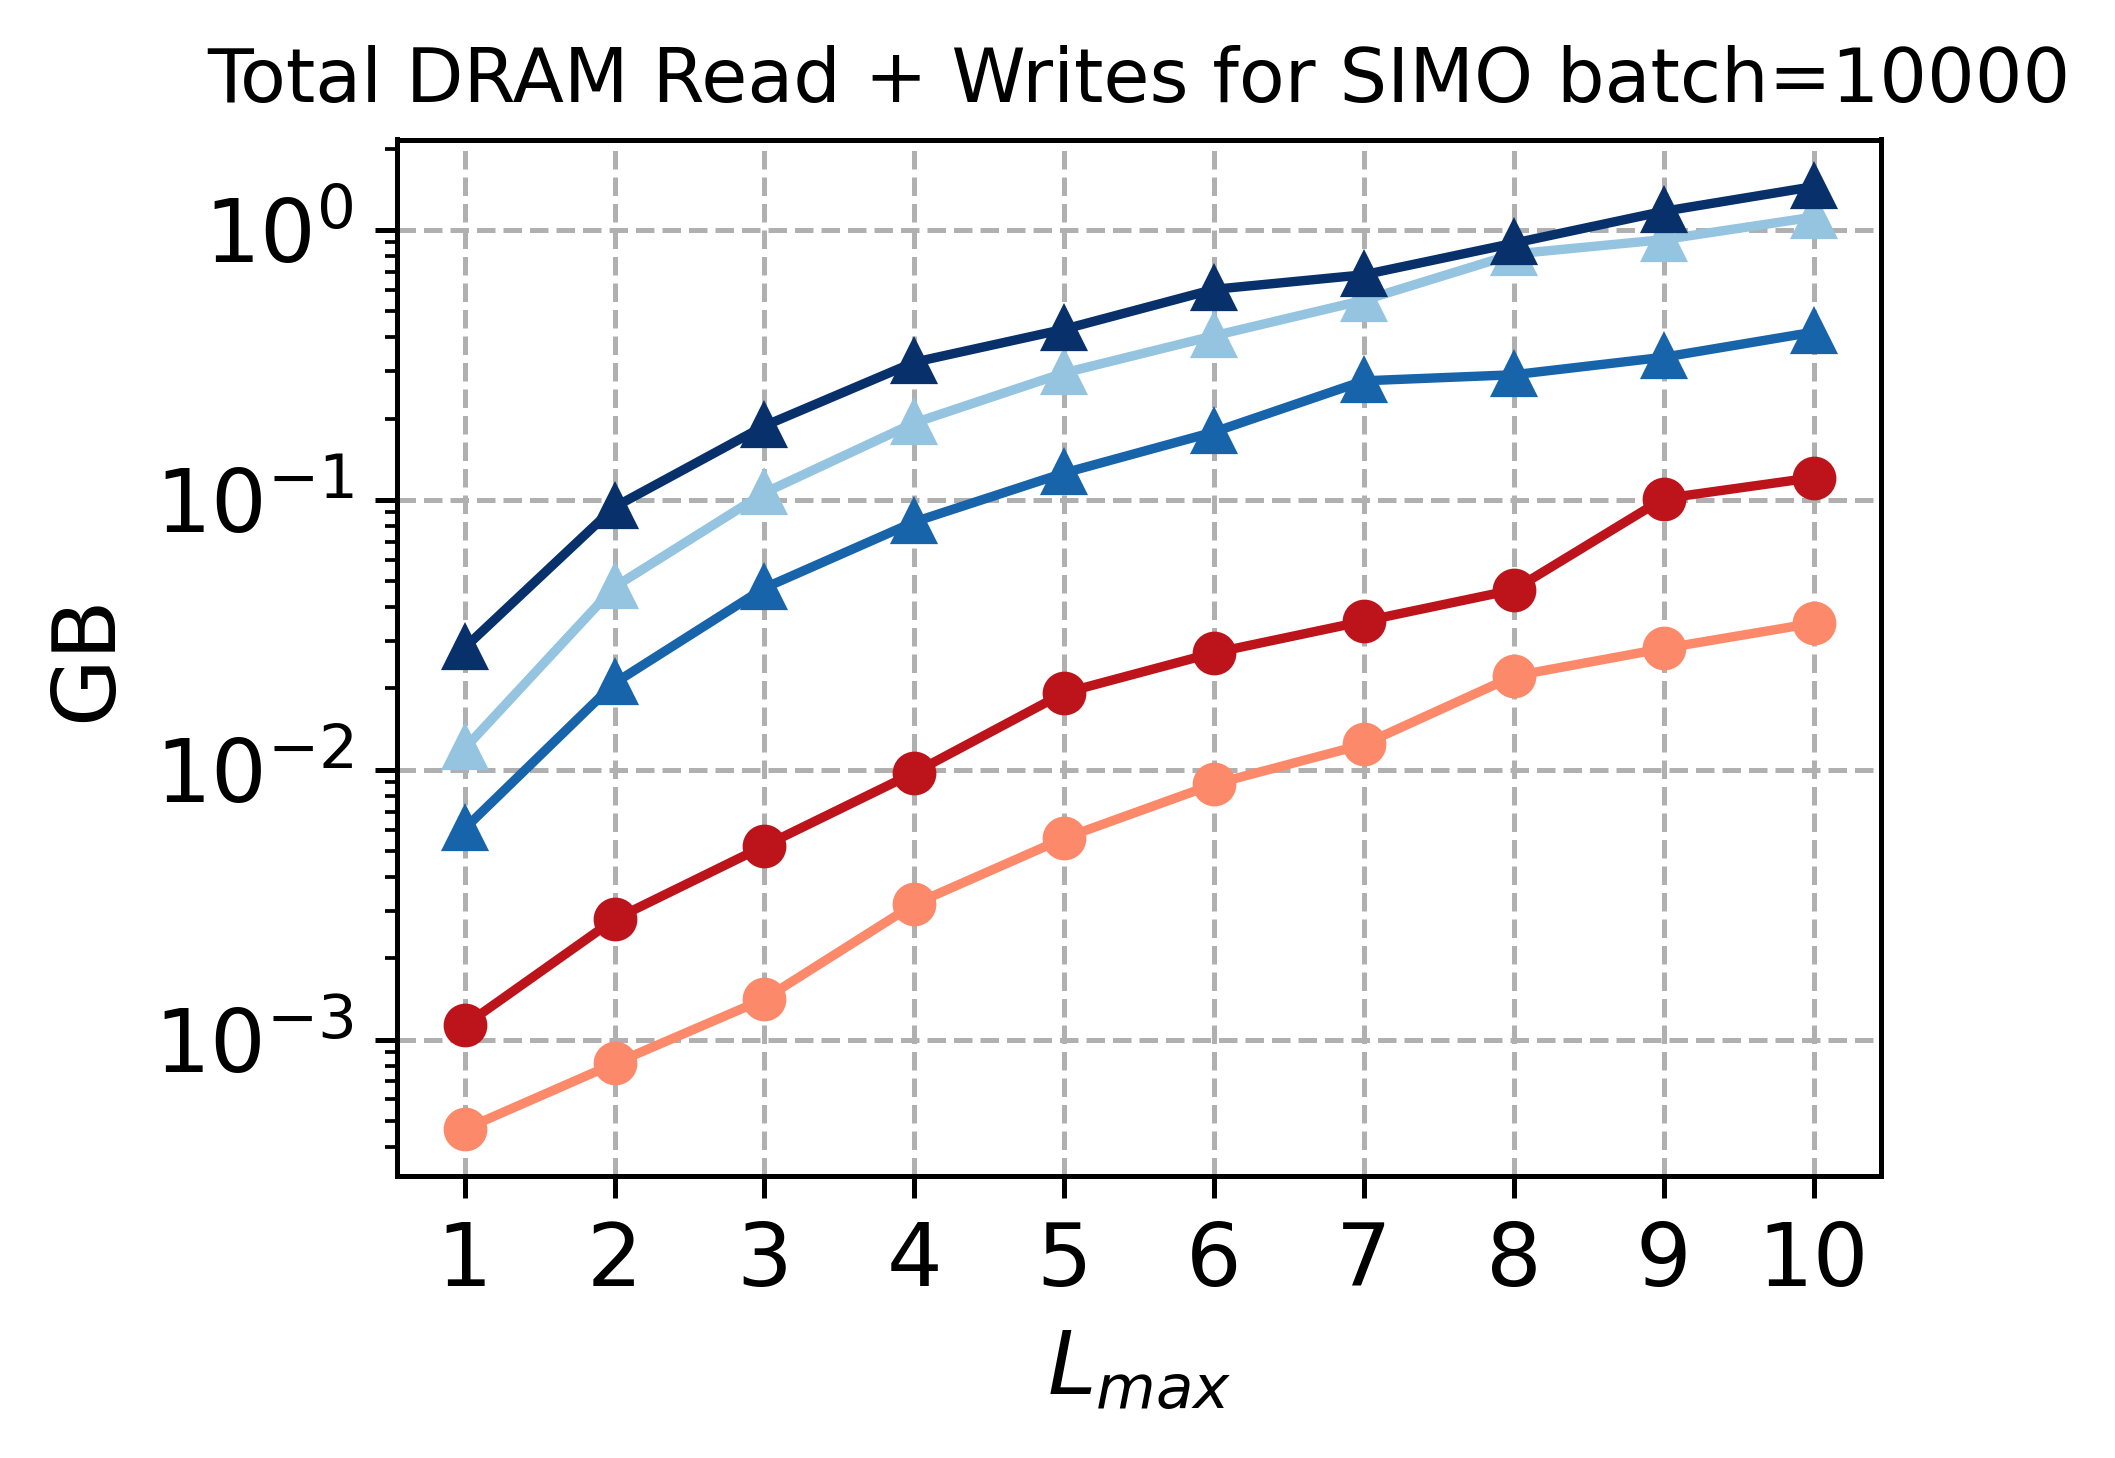

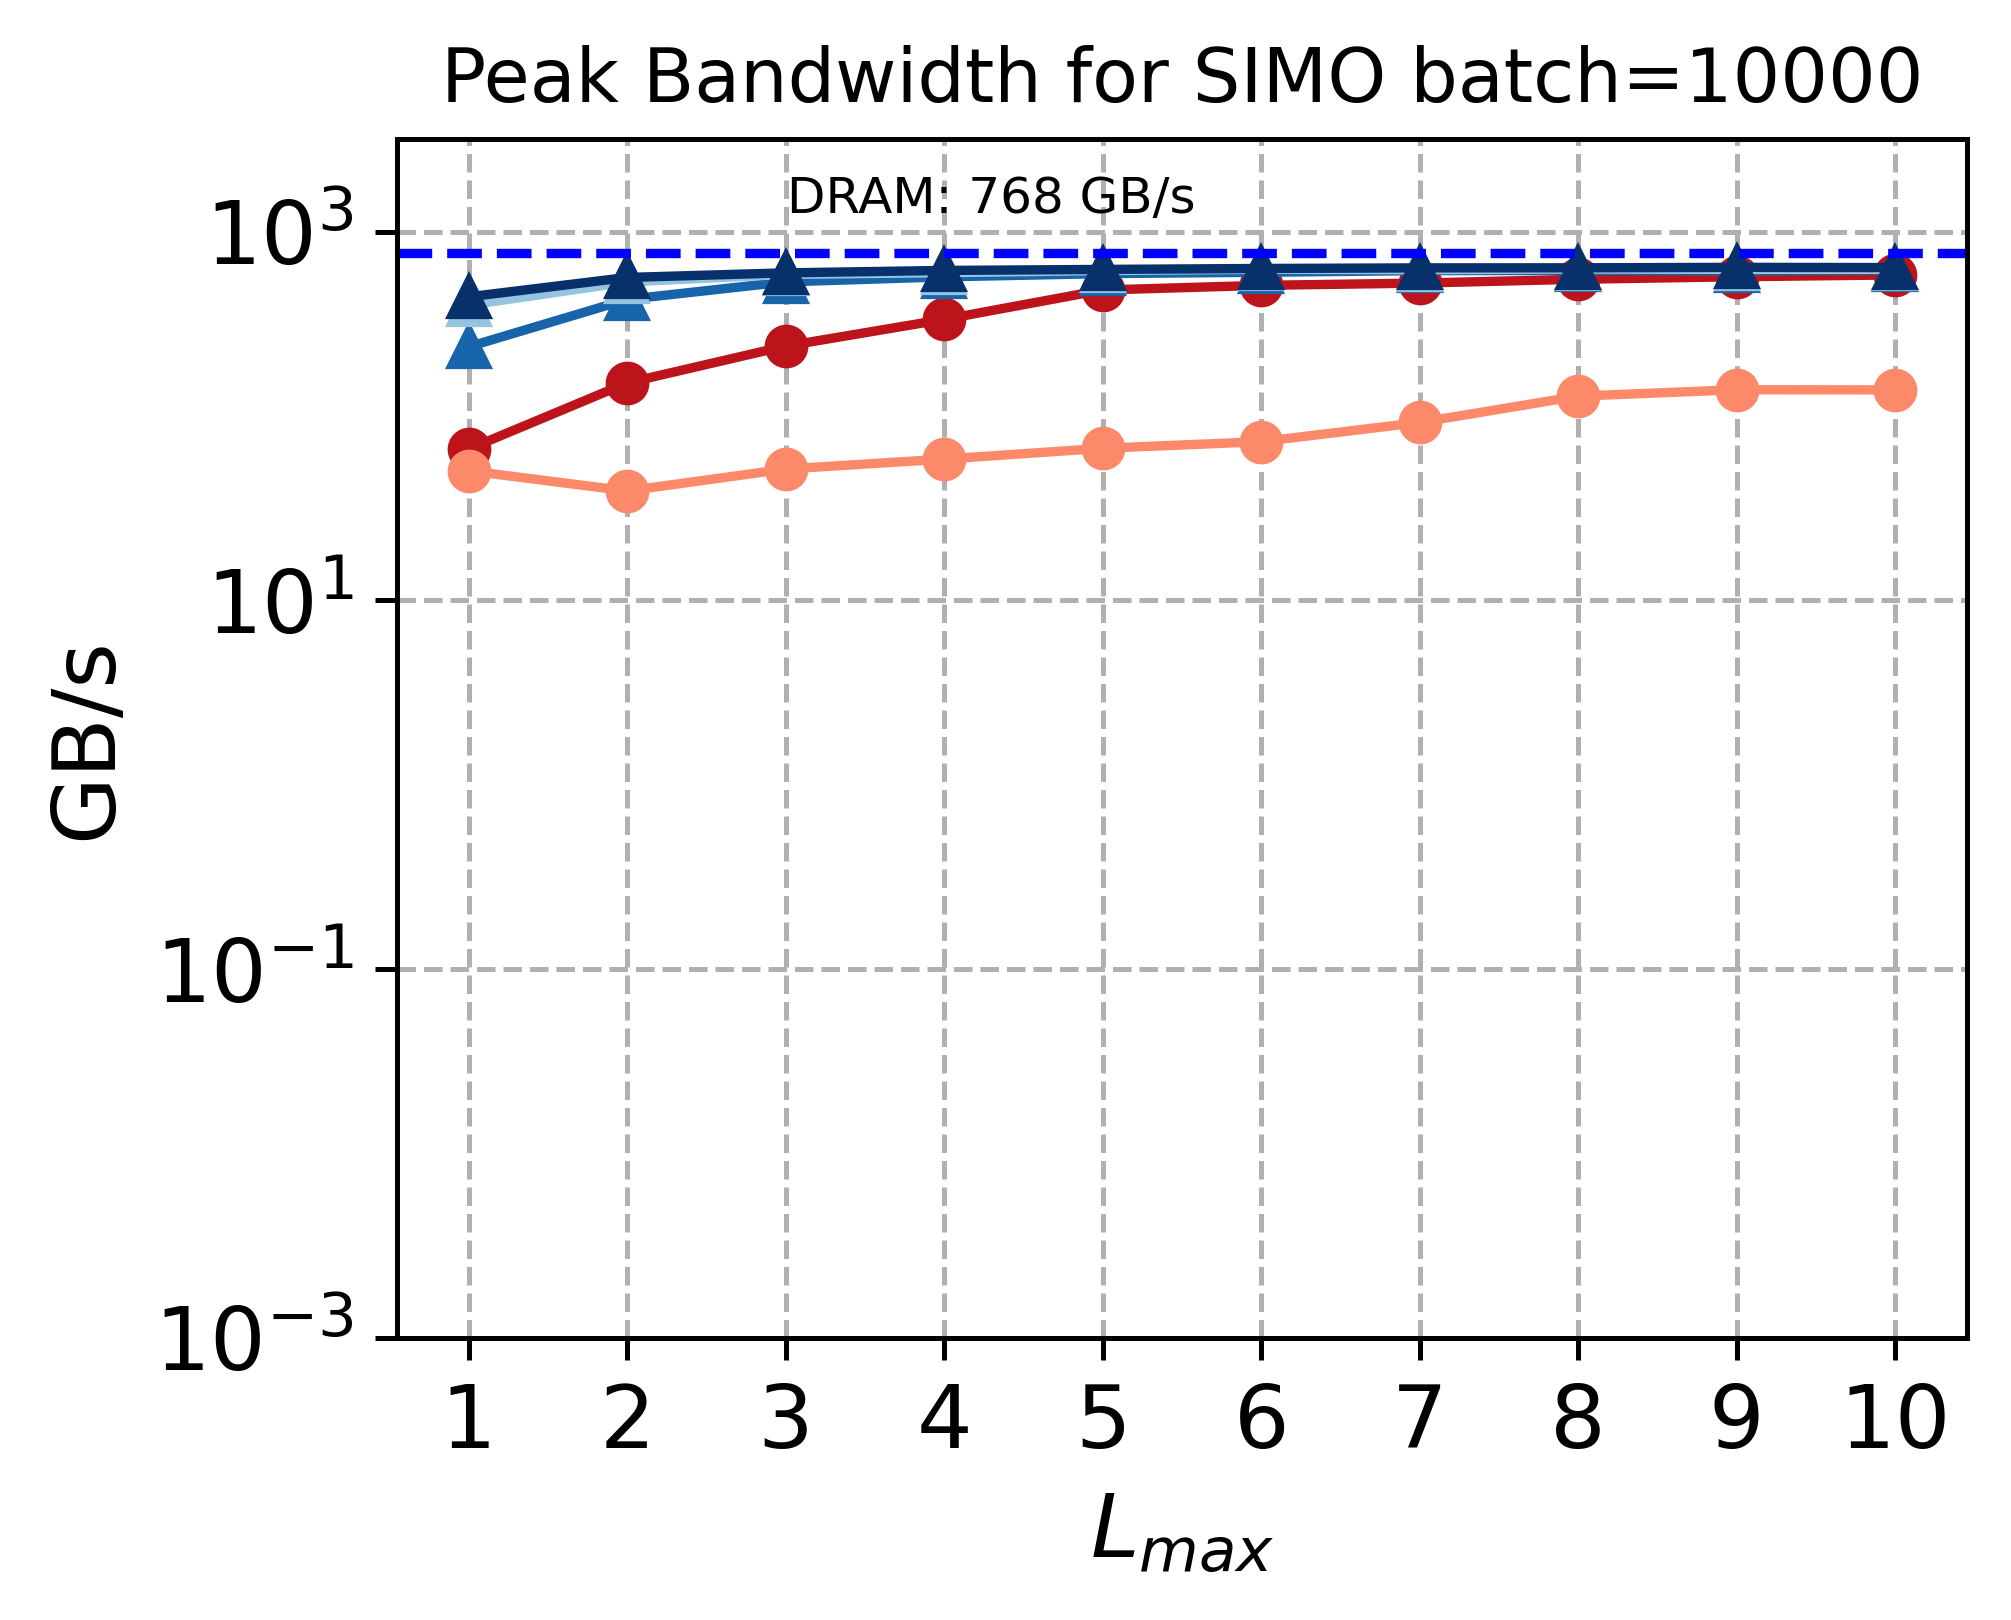

In [13]:
plot_iclr_sweep("SIMO", 10000)

In [ ]:
plot_iclr_sweep("SISO", 10000)